# TODO - 17. 4. 2020
- zmínit, že je jedno, že to jsou kryptoměny
- zmínit na Arbitážích, že to je obměna forexu -> je to forex pro kryptoměny
- ocitovat obchodní knihu, jak je stahuju
- ocitovat struktury, kde to a jak to ukládám
- Mastering Bitcoin
- pondělí 25. května
- adresa serveru stary.fit.cvut.cz
- 31.4. 14:00

# TODO - 3. 4. 2020
- napsat 5 nejzajímavějších kryptoměn a zmínit používaný zbytek
- projít všechna data, vypsat základní statistiky (obecný) ke všem a vyselektovat cca 5 nejlepších a u nich se zaměřit na detaily (závislost v čase, na prodaném objemu, na počtu obchodů)
- průměrná doba výskytu trojúhelníku
- napsat k trojúhelníkům denní statistiky výskytu, nejlepších, nejhorších 
- možnost zaměřit se na neefektivitu trhu, zmínit že není regulovaný a proto na něm vznikají arbitráže
- zmínit problémy vytěžitelnosti a jak by to reálně pobíhalo
- průměrný objem nasbíraných dat
- v praktické části popsat strukturu ukládaných dat (csv, json)
- v praktické části se zaměřit na používané algoritmy (jak sbírám order book, do jaké hloubky, jak ho procházím a znovu ukládám) 

In [1]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join, isdir
from typing import Dict, Tuple, Sequence
from copy import deepcopy
import threading
import os
from datetime import datetime

In [2]:
#  Exchange rates from cryptocurrencies to USDT (USD) (Binance.com, 13.4.2020) 
rate = {
    "BTC": 6837.51,
    "LTC": 41,
    "ETH": 156.7,
    "XRP": 0.185965,
    "USDT": 1,
    "BCH": 222.98,
    "BNB": 15.53,
    "EOS": 2.44,
    "XMR": 53.37,
    "TRX": 0.012597
}
title_font_size = 20  # title font size for the charts
label_font_size = 13

In [3]:
def fetch_directories(path: str) -> [str]:
    '''
    Fetches all directories in the given path 
    '''
    directories = []
    try:
        directories = [join(path, f) for f in listdir(path) if isdir(join(path, f))] 
    except:
        print("Trouble opening a directory")
        return directories
    return directories

def fetch_files(path: str) -> [str]:    
    '''
    Fetches all files in the given path 
    '''
    files = []
    try:
        files = [f for f in listdir(path) if isfile(join(path, f))] 
    except:
        print("Trouble opening a directory")
        return files
    return files

In [4]:
class FileHandler:
    def __init__(self, file: str, path: str):
        self.filename = file
        self.total_gain = 0
        self.average_gain = 0
        self.max_gain = 0
        self.best_gains = None
        self.date = file[-15:-5:]
        with open(join(path, file)) as f:
            tmp = json.loads(f.read())
            self.content = tmp["arbitrage_stats"]
            self.arbitrages_count = tmp["arbitrages_count"]
            self.without_fees_count = tmp["without_fees_count"]
            self.all_count = tmp["all_count"]
        self.scores = [x["score"] for x in self.content]
    
    @property
    def filename(self) -> str:
        return self.__filename
    
    @filename.setter
    def filename(self, filename: str):
        self.__filename = filename
        
    @property
    def content(self) -> str:
        return self.__content
    
    @content.setter
    def content(self, content: str):
        self.__content = content
        
    @property
    def total_gain(self) -> float:
        return self.__total_gain
    
    @total_gain.setter
    def total_gain(self, total_gain: float):
        self.__total_gain = total_gain
        
    @property
    def max_gain(self) -> float:
        return self.__max_gain
    
    @max_gain.setter
    def max_gain(self, max_gain: float):
        self.__max_gain = max_gain
        
    @property
    def average_gain(self) -> float:
        return self.__average_gain
    
    @average_gain.setter
    def average_gain(self, average_gain: float):
        self.__average_gain = average_gain
        
    @property
    def scores(self) -> [float]:
        return self.__scores
    
    @scores.setter
    def scores(self, scores: [float]):
        self.__scores = scores
        
    @property
    def arbitrages_count(self) -> int:
        return self.__arbitrages_count
    
    @arbitrages_count.setter
    def arbitrages_count(self, arbitrages_count: int):
        self.__arbitrages_count = arbitrages_count     
        
    @property
    def without_fees_count(self) -> int:
        return self.__without_fees_count
    
    @without_fees_count.setter
    def without_fees_count(self, without_fees_count: int):
        self.__without_fees_count = without_fees_count  
        
    @property
    def all_count(self) -> int:
        return self.__all_count
    
    @all_count.setter
    def all_count(self, all_count: int):
        self.__all_count = all_count  
        
    @property
    def date(self) -> str:
        return self.__date
    
    @date.setter
    def date(self, date: str):
        self.__date = date  
        
    def get_best_indexes_count(self) -> Dict[int, int]:
        indexes = np.array([x['supply_gain_index'] for x in self.content]).ravel()
        tmp = np.array([x['demand_gain_index'] for x in self.content]).ravel()
        indexes = np.array((indexes, tmp)).ravel()
        unique, counts = np.unique(indexes, return_counts = True)
        return dict(zip(unique, counts))
    
    def get_number_of_arbitrages(self) -> int:
        return len(self.scores)
    
    def get_average_score(self) -> float:
        if len(self.scores):
            return sum(self.scores)/len(self.scores)
        return 1
    
    def get_best_score(self) -> float:
        if len(self.scores):
            return max(self.scores)
        return 1
    
    def get_best_gains(self):
        best_gains = np.array([x["supply_gain"] for x in self.content])
        best_gains = np.array((best_gains, [x["supply_gain"] for x in self.content])).ravel()
        best_gains = best_gains[self.best_gains != 0.0]
        self.total_gain = np.sum(best_gains)
        self.average_gain = np.average(best_gains)
        if len(best_gains[0]):
            self.max_gain = np.max(best_gains)
        else:
            self.max_gain = 0
        return best_gains

    def get_first_currency(self) -> str:
        if (self.content):
            return self.content[0]['pairs'][0]['currency'][0:3]
        return ""
    
    def time_distribution_by_hours(self):
        hour_array = [datetime.fromtimestamp(max(x['pairs'][0]['timestamp'], x['pairs'][1]['timestamp'], x['pairs'][2]['timestamp'])).hour for x in self.content]
        counter = Counter()
        for x in hour_array:
            counter[x] += 1
#         display(counter)
        return counter 

In [5]:
class Triangle:
    def __init__(self, files: [str], path: str, triangle_name: str):
        self.__files = []
        self.__index_counts = None
        self.__path = path
        self.__best_gains = None
        self.__name = triangle_name
        for f in files:
            self.__files.append(FileHandler(f, path))
            

    @property
    def path(self) -> str:
        return self.__path
    
    @property
    def name(self) -> str:
        return self.__name
            
    def get_best_indexes_count(self) -> Dict[int, int]:
        if self.__index_counts is None:
            index_counts = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0}
            for d in np.array([x.get_best_indexes_count() for x in self.__files]):
                for k in d.keys():
                    index_counts[k] += d[k]
            self.__index_counts = index_counts
        return self.__index_counts
    
    def get_daily_number_average_of_arbitrages(self) -> int:
        return sum([x.get_number_of_arbitrages() for x in self.__files])/len(self.__files)
    
    def get_average_score(self) -> float:
        return sum([x.get_average_score() for x in self.__files])/len(self.__files)
    
    def get_best_score(self) -> float:
        return max([x.get_best_score() for x in self.__files])
    
    def get_best_gains(self):
        if self.__best_gains is None:
            self.__best_gains = [x.get_best_gains() for x in self.__files]
        return self.__best_gains
    
    def get_overall_best_gain(self) -> float:
        if self.__best_gains is None:
            self.__best_gains = [x.get_best_gains() for x in self.__files]
        return np.max([x.max_gain for x in self.__files])
    
    def get_average_gain(self) -> float:
        if self.__best_gains is None:
            self.__best_gains = [x.get_best_gains() for x in self.__files]
        return np.average([x.total_gain for x in self.__files])
    
    def get_total_gain(self) -> float:
        if self.__best_gains is None:
            self.__best_gains = [x.get_best_gains() for x in self.__files]
        return np.max([x.total_gain for x in self.__files])
    
    def get_first_currency(self) -> str:
        for f in self.__files:
            tmp = f.get_first_currency()
            if tmp != "":
                return tmp
        return ""
    
    def get_data_length(self) -> int:
        return len(self.__files)
    
    def get_arbitrages_counts(self) -> ([int], [str]):
        return [x.arbitrages_count for x in self.__files], [x.without_fees_count for x in self.__files], [x.all_count for x in self.__files], [x.date for x in self.__files]

    def time_distribution_by_hours(self):
        return sum([x.time_distribution_by_hours() for x in self.__files], Counter())

In [141]:
def basic_stats(t):
    '''
    Gets the main stats from the Triangle class
    '''
    a = t.get_best_indexes_count()
    tmp = {
        "Name": t.name,
        "Days": t.get_data_length(), 
        "Average count": t.get_daily_number_average_of_arbitrages(),
        "Average score": t.get_average_score(),
        "The best score": t.get_best_score(),
        "The best gain": '{:e} {}'.format(t.get_overall_best_gain(), t.get_first_currency()).replace(".", ","),
        "Total inefficiency": '{:e} {}'.format(t.get_total_gain(), t.get_first_currency()).replace(".", ","), 
        "Average daily inefficiency": '{:e} {}'.format(t.get_average_gain(), t.get_first_currency()).replace(".", ","),
        "Average daily inefficiency (USD)": t.get_average_gain() * rate[t.get_first_currency()]
    }
    return tmp

In [142]:
# def basic_stats(t):
#     a = t.get_best_indexes_count()
#     tmp = {
#         "Název": t.name,
#         "Počet dní": t.get_data_length(), 
#         "Průměr počtu arbitráží": t.get_daily_number_average_of_arbitrages(),
#         "Průměrný procentuální zisk": t.get_average_score(),
#         "Nejlepší procentuální zisk": t.get_best_score(),
#         "Celkový výdělek": '{:e} {}'.format(t.get_overall_best_gain(), t.get_first_currency()),
#         "Celková neefektivita trhu": '{:e} {}'.format(t.get_total_gain(), t.get_first_currency()), 
#         "Průměrný denní zisk": '{:e} {}'.format(t.get_average_gain(), t.get_first_currency()),
#         "Průměrný denní zisk (USD)": t.get_average_gain() * rate[t.get_first_currency()]
#     }
#     return tmp

In [143]:
from collections import Counter
main_counter = Counter()
path = "./output_data/"    

stats = []
count = 0
stop = 99
for directory in fetch_directories(path):
    print(count)
    count += 1
    triangle = Triangle(fetch_files(directory), directory, directory[len(path):])
    counter = triangle.time_distribution_by_hours()
    main_counter += counter
    triangle = None
    if count == stop:
        break
display(main_counter)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40


Counter({16: 566,
         1: 1245,
         21: 444103,
         18: 484,
         17: 815420,
         4: 1282,
         15: 359,
         10: 125940,
         14: 744381,
         20: 171,
         7: 222462,
         11: 16695,
         2: 1294,
         6: 240,
         5: 408,
         3: 430291,
         13: 574224,
         9: 526,
         8: 412783,
         12: 2963,
         0: 876,
         22: 339,
         23: 152,
         19: 309917})

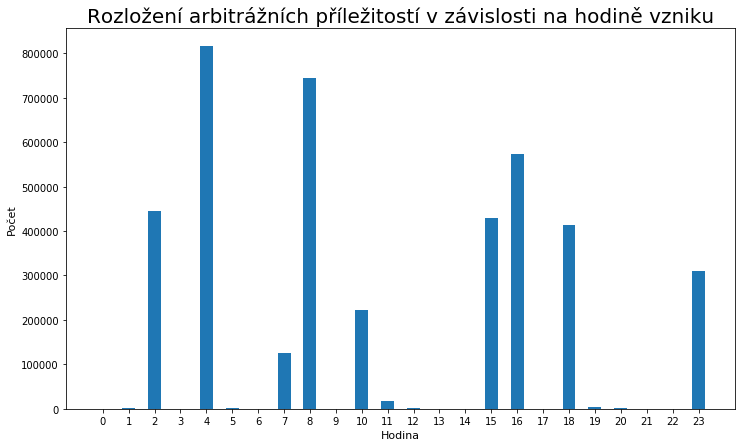

In [9]:
# display(main_counter)
fig, ax = plt.subplots()
ind = np.arange(len(main_counter))
width = 0.5
ax.bar(ind, main_counter.values(), width=width)
fig.set_size_inches(width * len(main_counter.keys()), 7)
ax.set_xticks(ind)
plt.xlabel('Hodina', fontsize=label_font_size-2)
plt.ylabel('Počet', fontsize=label_font_size-2)
plt.title('Rozložení arbitrážních příležitostí v závislosti na hodině vzniku', fontsize=title_font_size)
plt.show()

0


{0: 116799, 1: 40088, 2: 39782, 3: 4875, 4: 4388}

1


{0: 129613, 1: 40090, 2: 39782, 3: 4875, 4: 4388}

2


{0: 177626, 1: 44869, 2: 41150, 3: 5492, 4: 4451}

3


{0: 227926, 1: 49460, 2: 44820, 3: 6451, 4: 4745}

4


{0: 324507, 1: 55327, 2: 56988, 3: 12132, 4: 5060}

5


{0: 658984, 1: 83877, 2: 80027, 3: 27618, 4: 11154}

6


{0: 660596, 1: 83900, 2: 80036, 3: 27624, 4: 11154}

7


{0: 672788, 1: 85216, 2: 80387, 3: 27816, 4: 11269}

8


{0: 680382, 1: 85460, 2: 80449, 3: 27842, 4: 12139}

9


{0: 742816, 1: 90541, 2: 84226, 3: 28878, 4: 12267}

10


{0: 750126, 1: 91668, 2: 84489, 3: 29005, 4: 12404}

11


{0: 815067, 1: 95149, 2: 86218, 3: 29381, 4: 12461}

12


{0: 831082, 1: 98531, 2: 86296, 3: 29393, 4: 12462}

13


{0: 1010540, 1: 121288, 2: 99985, 3: 37062, 4: 18269}

14


{0: 1016695, 1: 121800, 2: 100182, 3: 37174, 4: 18409}

15


{0: 1201574, 1: 152734, 2: 107087, 3: 40231, 4: 38046}

16


{0: 1203738, 1: 152812, 2: 107114, 3: 40252, 4: 38066}

17


{0: 1207055, 1: 152913, 2: 107189, 3: 40260, 4: 38099}

18


{0: 1209617, 1: 153074, 2: 107230, 3: 40290, 4: 38119}

19


{0: 1222097, 1: 154088, 2: 107620, 3: 40502, 4: 38339}

20


{0: 1438645, 1: 165693, 2: 116206, 3: 48205, 4: 45807}

21


{0: 1466931, 1: 167318, 2: 117074, 3: 48714, 4: 46157}

22


{0: 9794175, 1: 1044270, 2: 459533, 3: 413126, 4: 406568}

23


{0: 11221224, 1: 1150362, 2: 567444, 3: 547987, 4: 461429}

24


{0: 12710780, 1: 1199598, 2: 711615, 3: 612943, 4: 522570}

25


{0: 13275125, 1: 1262795, 2: 744206, 3: 642568, 4: 558002}

26


{0: 14805422, 1: 1378546, 2: 874151, 3: 708071, 4: 666074}

27


{0: 16513923, 1: 1384776, 2: 900561, 3: 708161, 4: 678877}

28


{0: 17561476, 1: 1497960, 2: 970260, 3: 764239, 4: 762145}

29


{0: 18667500, 1: 1513154, 2: 1086446, 3: 800765, 4: 780657}

30


{0: 18686169, 1: 1514766, 2: 1086987, 3: 801178, 4: 780938}

31


{0: 18923815, 1: 1564172, 2: 1103533, 3: 812693, 4: 791763}

32


{0: 19037589, 1: 1581558, 2: 1117705, 3: 822794, 4: 791784}

33


{0: 19274865, 1: 1583505, 2: 1155242, 3: 830548, 4: 791832}

34


{0: 19464100, 1: 1600062, 2: 1165012, 3: 839343, 4: 801583}

35


{0: 19714766, 1: 1607098, 2: 1205918, 3: 847671, 4: 801589}

36


{0: 19730574, 1: 1607944, 2: 1206211, 3: 847962, 4: 801733}

37


{0: 19980114, 1: 1631084, 2: 1218778, 3: 857238, 4: 809424}

38


{0: 19988711, 1: 1631734, 2: 1219046, 3: 857436, 4: 809533}

39


{0: 20013292, 1: 1633418, 2: 1219496, 3: 857696, 4: 809690}

40


{0: 20108613, 1: 1637783, 2: 1225324, 3: 861296, 4: 809710}

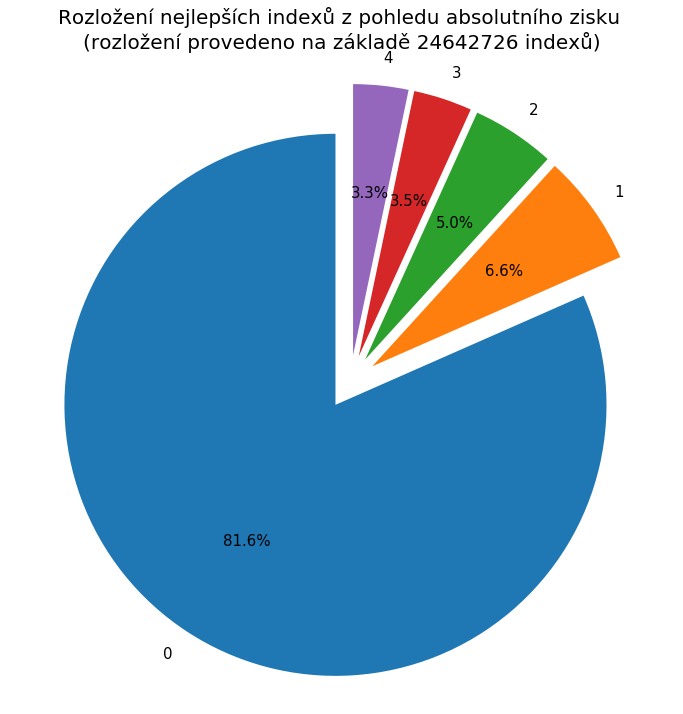

In [10]:
path = "./output_data/"    

indexes = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0}
count = 0
stop = 99
for directory in fetch_directories(path):
    print(count)
    triangle = Triangle(fetch_files(directory), directory, directory[len(path):])
    ind = triangle.get_best_indexes_count()
    for k in ind.keys():
        indexes[k] += ind[k]
    display(indexes)
    count += 1
    triangle = None
    if count == stop:
        break
        
labels = indexes.keys()
sizes = indexes.values()
explode = (0.1, 0.1, 0.1, 0.1, 0.1)
fig, ax = plt.subplots()
ax.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=False, startangle=90, textprops={'fontsize': 15})
ax.axis('equal')
fig.set_size_inches(12, 12)
plt.title("Rozložení nejlepších indexů z pohledu absolutního zisku \n(rozložení provedeno na základě " 
              + str(sum(indexes.values())) + " indexů)", fontsize=title_font_size)

plt.savefig(os.path.join('images/index_distribution.png'), dpi=300, format='png')
    
plt.show()

In [145]:
path = "./output_data/"    

stats = []
count = 0
stop = 99
for directory in fetch_directories(path):
    print(count)
    count += 1
    triangle = Triangle(fetch_files(directory), directory, directory[len(path):])
    stats.append(basic_stats(triangle))
    triangle = None
    if count == stop:
        break

0


D:\School\Anaconda\lib\site-packages\numpy\lib\function_base.py:392: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
D:\School\Anaconda\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40


In [146]:
pd.options.display.float_format = "{:e}".format
stats_table = pd.DataFrame(stats)
stats_table

Name  Days  Average count  Average score  The best score  \
0    BTCBCHBNB    38   9.032105e+02   1.001598e+00    1.039020e+00   
1    BTCBNBTRX    39   5.476923e+01   1.000475e+00    1.007800e+00   
2    BTCBNBXMR    39   2.343590e+02   1.001183e+00    1.006420e+00   
3    BTCEOSBNB    39   2.556154e+02   1.000575e+00    1.025380e+00   
4    BTCETHBNB    39   5.154359e+02   1.000642e+00    1.006210e+00   
5    BTCETHEOS    39   1.742077e+03   1.000418e+00    1.012260e+00   
6    BTCETHTRX    57   4.824561e+00   1.000428e+00    1.019190e+00   
7    BTCETHXMR    57   4.142105e+01   1.001227e+00    1.017280e+00   
8    BTCETHXRP    57   2.571930e+01   1.000631e+00    1.022920e+00   
9    BTCLTCBNB    39   3.096410e+02   1.000836e+00    1.007070e+00   
10   BTCLTCETH    57   2.621053e+01   1.000539e+00    1.022520e+00   
11   BTCXRPBNB    39   3.016410e+02   1.000560e+00    1.006400e+00   
12   BTCXRPTRX    57   5.698246e+01   1.000913e+00    1.023790e+00   
13   ETHBNBTRX    39   9.802564e+02   1.000373e+00    1.014520e+00   
14   ETHBNBXMR    57   2.080702e+01   1.000597e+00    1.045810e+00   
15   ETHEOSBNB    39   1.048769e+03   1.000452e+00    1.020280e+00   
16   ETHXRPBNB    57   6.754386e+00   1.000301e+00    1.033420e+00   
17   ETHXRPTRX    57   1.033333e+01   1.000446e+00    1.014140e+00   
18   LTCETHBNB    57   8.228070e+00   1.000423e+00    1.026660e+00   
19  USDTBCHBNB    56   4.260714e+01   1.002847e+00    1.114940e+00   
20  USDTBNBTRX    39   1.076538e+03   1.002174e+00    1.014850e+00   
21  USDTBNBXMR    57   9.250877e+01   1.002675e+00    1.142000e+00   
22  USDTBTCBCH    39   4.389521e+04   1.004701e+00    1.049500e+00   
23  USDTBTCBNB    39   7.823821e+03   1.003582e+00    1.036980e+00   
24  USDTBTCEOS    58   5.198448e+03   1.003631e+00    1.101560e+00   
25  USDTBTCETH    39   3.099103e+03   1.002759e+00    1.031450e+00   
26  USDTBTCLTC    57   5.700491e+03   1.003393e+00    1.060710e+00   
27  USDTBTCTRX    57   5.128754e+03   1.002456e+00    1.085550e+00   
28  USDTBTCXMR    57   4.005211e+03   1.003408e+00    1.063980e+00   
29  USDTBTCXRP    57   3.779070e+03   1.003427e+00    1.060900e+00   
30  USDTEOSBNB    57   6.291228e+01   1.002811e+00    1.104790e+00   
31  USDTETHBNB    39   1.392897e+03   1.002409e+00    1.030900e+00   
32  USDTETHEOS    39   6.643333e+02   1.001758e+00    1.022300e+00   
33  USDTETHTRX    39   1.216077e+03   1.001705e+00    1.029200e+00   
34  USDTETHXMR    39   1.000462e+03   1.002004e+00    1.028470e+00   
35  USDTETHXRP    39   1.311718e+03   1.001684e+00    1.028720e+00   
36  USDTLTCBNB    57   5.082456e+01   1.002536e+00    1.104170e+00   
37  USDTLTCETH    39   1.291513e+03   1.001814e+00    1.030510e+00   
38  USDTXRPBNB    57   2.871930e+01   1.002709e+00    1.111370e+00   
39  USDTXRPTRX    57   7.933333e+01   1.001939e+00    1.074050e+00   
40   XRPBNBTRX    39   4.663846e+02   1.000963e+00    1.013270e+00   

       The best gain Total inefficiency Average daily inefficiency  \
0   1,528940e-03 BCH   2,748139e+01 BCH           7,232724e-01 BCH   
1   1,286360e-13 TRX   2,572720e-13 TRX           7,531697e-15 TRX   
2   4,975940e-06 XMR   4,669594e-03 XMR           1,212417e-04 XMR   
3   6,440760e-07 EOS   5,593003e-04 EOS           1,474239e-05 EOS   
4   4,179320e-07 BNB   1,560732e-03 BNB           4,005811e-05 BNB   
5   8,940850e-08 EOS   1,656258e-03 EOS           4,247258e-05 EOS   
6   7,042350e-12 TRX   8,167343e-11 TRX           2,675907e-12 TRX   
7   2,275100e-06 XMR   6,313177e-05 XMR           1,724460e-06 XMR   
8   4,160390e-10 XRP   4,707160e-07 XRP           8,296201e-09 XRP   
9   1,995000e-05 LTC   2,666775e-02 LTC           6,896793e-04 LTC   
10  2,306770e-05 LTC   3,733013e-04 LTC           7,007199e-06 LTC   
11  5,459300e-09 XRP   9,123745e-06 XRP           2,339707e-07 XRP   
12  9,040310e-09 TRX   3,757080e-07 TRX           1,116005e-08 TRX   
13  1,059450e-11 TRX   4,769612e-11 TRX           1,222977e-12 TRX   
14  8,770460e-04 XM

In [147]:
stats

[{'Name': 'BTCBCHBNB',
  'Days': 38,
  'Average count': 903.2105263157895,
  'Average score': 1.001598416581785,
  'The best score': 1.03902,
  'The best gain': '1,528940e-03 BCH',
  'Total inefficiency': '2,748139e+01 BCH',
  'Average daily inefficiency': '7,232724e-01 BCH',
  'Average daily inefficiency (USD)': 161.27528541430019},
 {'Name': 'BTCBNBTRX',
  'Days': 39,
  'Average count': 54.76923076923077,
  'Average score': 1.0004753418803425,
  'The best score': 1.0078,
  'The best gain': '1,286360e-13 TRX',
  'Total inefficiency': '2,572720e-13 TRX',
  'Average daily inefficiency': '7,531697e-15 TRX',
  'Average daily inefficiency (USD)': 9.48767926e-17},
 {'Name': 'BTCBNBXMR',
  'Days': 39,
  'Average count': 234.35897435897436,
  'Average score': 1.0011827135519844,
  'The best score': 1.00642,
  'The best gain': '4,975940e-06 XMR',
  'Total inefficiency': '4,669594e-03 XMR',
  'Average daily inefficiency': '1,212417e-04 XMR',
  'Average daily inefficiency (USD)': 0.0064706709819

In [159]:
def list_of_dicts_to_latex_table(table, caption, float_format='{:.4f}', label=None):
    output = '\\begin{table}\\centering\n'
    output += '\\caption{' + caption + '}\n'
    if label is not None:
        output += '\\label{' + str(label) + '}\n'
    output += '\\begin{tabular}{||'
    tmp = '\\hline '
    keys = list(table[0].keys())
    for key in keys:
        output += ' c |'
        if key == keys[-1]:
            tmp += str(key) + '\\\\ [0.5ex]' + '\n '        
        else:
            tmp += key + ' & '
    output += '|}'
    output += tmp + '\\hline'
    for row in table:
        output += '\\hline '
        column_names = list(row.values())
        for column in column_names:
            if column == column_names[-1]:
                if isinstance(column, float):
                    output += (float_format.format(column)).replace(".", ",") + '\\\\ ' + '\n '
                else:
                    output += str(column) + '\\\\ ' + '\n '
            else:
                if isinstance(column, float):
                    output += (float_format.format(column)).replace(".", ",") + ' & '
                else:
                    output += str(column) + ' & '
    output += '\\hline\n'
    output += '\\end{tabular}\n'
    output += '\\end{table}'
    return output


In [179]:
def dict_to_latex_table(table, caption, float_format='{:.4f}', label=None, column_names=('items, values')):
    output = '\\begin{table}\\centering\n'
    output += '\\caption{' + caption + '}\n'
    if label is not None:
        output += '\\label{' + str(label) + '}\n'  
    keys = list(table.keys())
    output += '\\begin{tabular}{|| c | c ||}\n'
    output += '\\hline ' + str(column_names[0]) + ' & ' + str(column_names[1]) + ' \\\\ \n'
    output += '\\hline'
    for key, val in table.items():
        output += '\\hline ' + str(key) + ' & ' + str(val).replace(".", ",") + ' \\\\ \n'
    output += '\\hline\n'
    output += '\\end{tabular}\n'
    output += '\\end{table}'
    return output

In [168]:
caption = 'Tabulka průměrných hodnot týkajících se arbitrážních příležitostí'
output_file_name = 'output_files/table_average.tex'
label = 'table_averages'
f = open(output_file_name, "wb")

df = stats_table[['Name', 'Average count', 'Average score']]
df.columns = ('Trojúhelník', 'Průměrný denní počet', 'Průměrná procentuální neefektivita')
df = df.drop([3, 7])
stats_dict = df.to_dict('records')
f.write(list_of_dicts_to_latex_table(stats_dict, caption, label=label).encode('utf8'))
f.close()

In [169]:
caption = 'Tabulka potenciálního výnostu arbitrážních příležitostí'
output_file_name = 'output_files/table_gain.tex'
label = 'table_gains'
f = open(output_file_name, "wb")


df = stats_table[['Name', 'Average daily inefficiency', 'Average daily inefficiency (USD)']]
df.columns = ('Trojúhelník', 'Denní neefektivita', 'Denní neefektivita (USD)')
df = df.drop([3, 7])
stats_dict = df.to_dict('records')
f.write(list_of_dicts_to_latex_table(stats_dict, caption, float_format='{:e}', label=label).encode('utf8'))
f.close()

In [180]:
caption = 'Tabulka kurzů využitých na přepočet na americké dolary (údaj z burzy Binance ze dne 13.4.2020)'
output_file_name = 'output_files/table_rates.tex'
label = 'table_rates'
f = open(output_file_name, "wb")

f.write(dict_to_latex_table(rate, caption, label=label, column_names=('Kryptoměna', 'Kurz na USD')).encode('utf8'))
f.close()

In [ ]:
# from matplotlib.backends.backend_pdf import PdfPages
# # num = 9
# for num in range(6, 15):
#     fig, ax = plt.subplots(figsize=(num,num*0.9))
#     df = stats_table.drop(['Days', 'The best score', 'The best gain'], axis=1)
#     ax.axis('tight')
#     ax.axis('off')
#     standard = 2/11
#     the_table = ax.table(cellText=df.values,colLabels=df.columns,loc='center', cellLoc='left', 
#                          colWidths=[1/11, standard, standard, standard, standard, standard],fontsize=25)
#     the_table.set_fontsize(20)

#     pp = PdfPages("stats_table" + str(num) + ".pdf")
#     # the_table.auto_set_column_width(col=list(range(len(df.columns))))
#     the_table.scale(1, 4)
#     pp.savefig(fig, bbox_inches='tight')
#     pp.close()

In [16]:
stats_table.to_latex(index=False, longtable=False, escape=False)
f = open("table.tex", "w")
f.write(stats_table.to_latex(index=False, longtable=False, escape=False))
f.close()

In [181]:
condition = stats_table['Average daily inefficiency (USD)'] > 10
stats_table[condition]

Name  Days  Average count  Average score  The best score  \
0    BTCBCHBNB    38   9.032105e+02   1.001598e+00    1.039020e+00   
19  USDTBCHBNB    56   4.260714e+01   1.002847e+00    1.114940e+00   
21  USDTBNBXMR    57   9.250877e+01   1.002675e+00    1.142000e+00   
22  USDTBTCBCH    39   4.389521e+04   1.004701e+00    1.049500e+00   
23  USDTBTCBNB    39   7.823821e+03   1.003582e+00    1.036980e+00   
25  USDTBTCETH    39   3.099103e+03   1.002759e+00    1.031450e+00   
26  USDTBTCLTC    57   5.700491e+03   1.003393e+00    1.060710e+00   
28  USDTBTCXMR    57   4.005211e+03   1.003408e+00    1.063980e+00   
30  USDTEOSBNB    57   6.291228e+01   1.002811e+00    1.104790e+00   
31  USDTETHBNB    39   1.392897e+03   1.002409e+00    1.030900e+00   
32  USDTETHEOS    39   6.643333e+02   1.001758e+00    1.022300e+00   
34  USDTETHXMR    39   1.000462e+03   1.002004e+00    1.028470e+00   
36  USDTLTCBNB    57   5.082456e+01   1.002536e+00    1.104170e+00   
37  USDTLTCETH    39   1.291513e+03   1.001814e+00    1.030510e+00   

       The best gain Total inefficiency Average daily inefficiency  \
0   1,528940e-03 BCH   2,748139e+01 BCH           7,232724e-01 BCH   
19  3,072660e+00 BCH   1,287343e+02 BCH           2,750812e+00 BCH   
21  6,383220e-01 XMR   2,420542e+01 XMR           5,985690e-01 XMR   
22  4,539970e-01 BCH   4,911041e+03 BCH           2,429589e+02 BCH   
23  1,186430e-02 BNB   4,127759e+02 BNB           1,213585e+01 BNB   
25  2,187630e-01 ETH   5,135635e+02 ETH           1,738009e+01 ETH   
26  1,934550e-01 LTC   8,902319e+02 LTC           3,060321e+01 LTC   
28  5,499750e-02 XMR   8,391050e+02 XMR           1,868465e+01 XMR   
30  8,431420e+00 EOS   1,543821e+03 EOS           2,809629e+01 EOS   
31  5,996860e-01 BNB   7,174545e+02 BNB           1,840816e+01 BNB   
32  2,011900e-02 EOS   1,748418e+02 EOS           4,496845e+00 EOS   
34  2,919710e-01 XMR   5,809490e+02 XMR           1,490794e+01 XMR   
36  5,287220e+00 LTC   2,991813e+02 LTC           5,610373e+00 LTC   
37  3,753490e-01 LTC   9,837944e+02 LTC           2,523501e+01 LTC   

    Average daily inefficiency (USD)  
0                       1.612753e+02  
19                      6.133760e+02  
21                      3.194563e+01  
22                      5.417499e+04  
23                      1.884698e+02  
25                      2.723461e+03  
26                      1.254732e+03  
28                      9.971996e+02  
30                      6.855495e+01  
31                      2.858787e+02  
32                      1.097230e+01  
34                      7.956367e+02  
36                      2.300253e+02  
37                      1.034635e+03

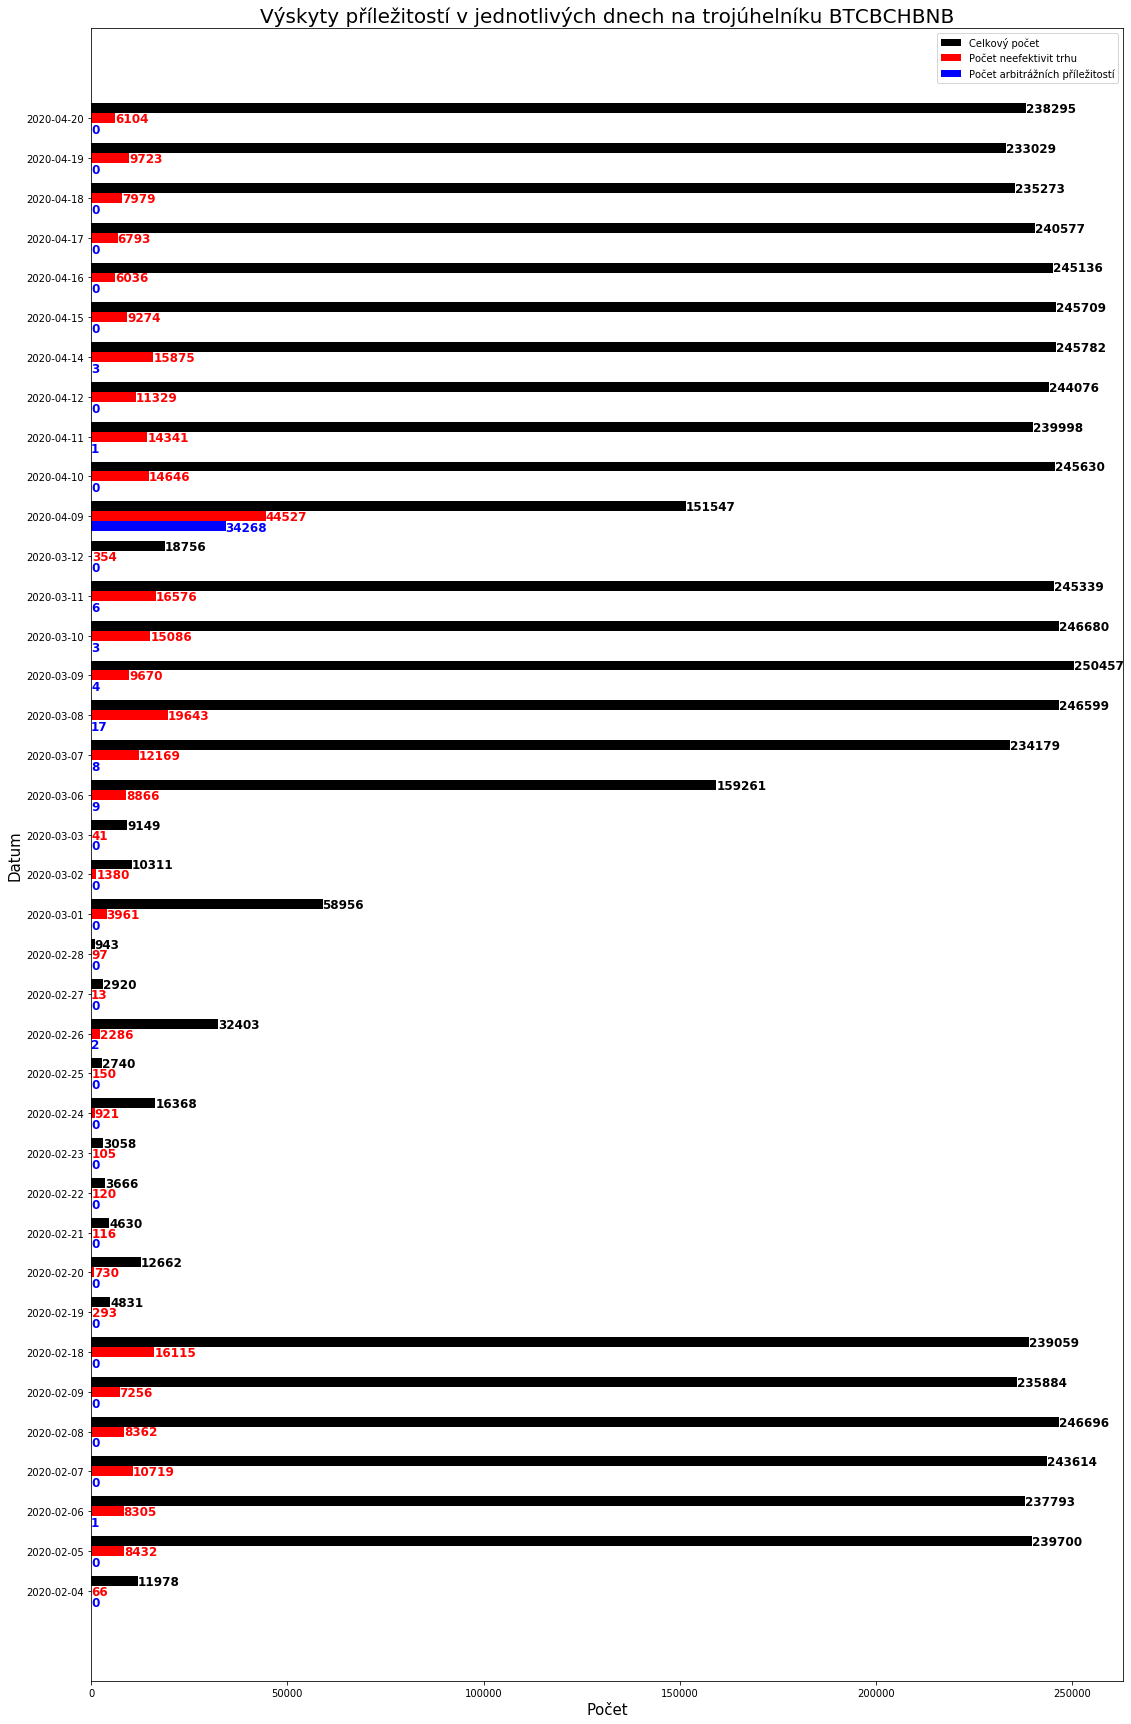

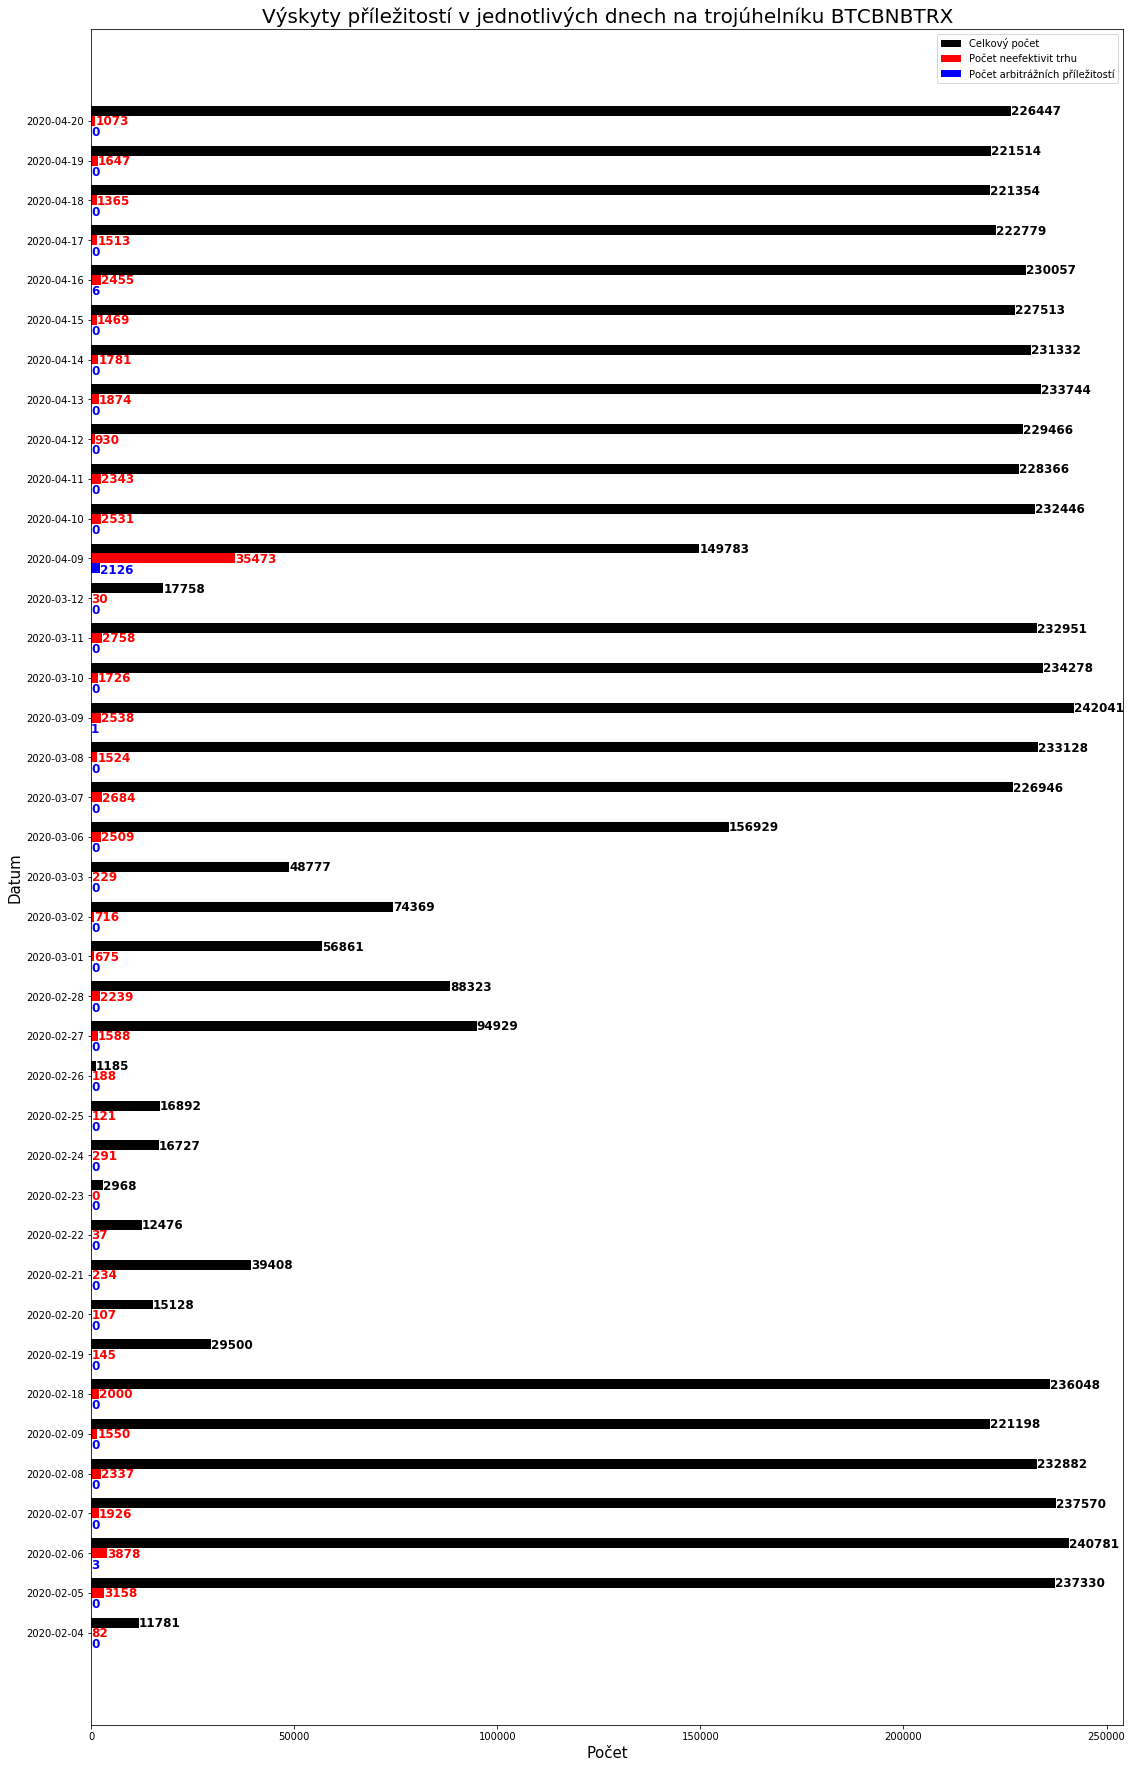

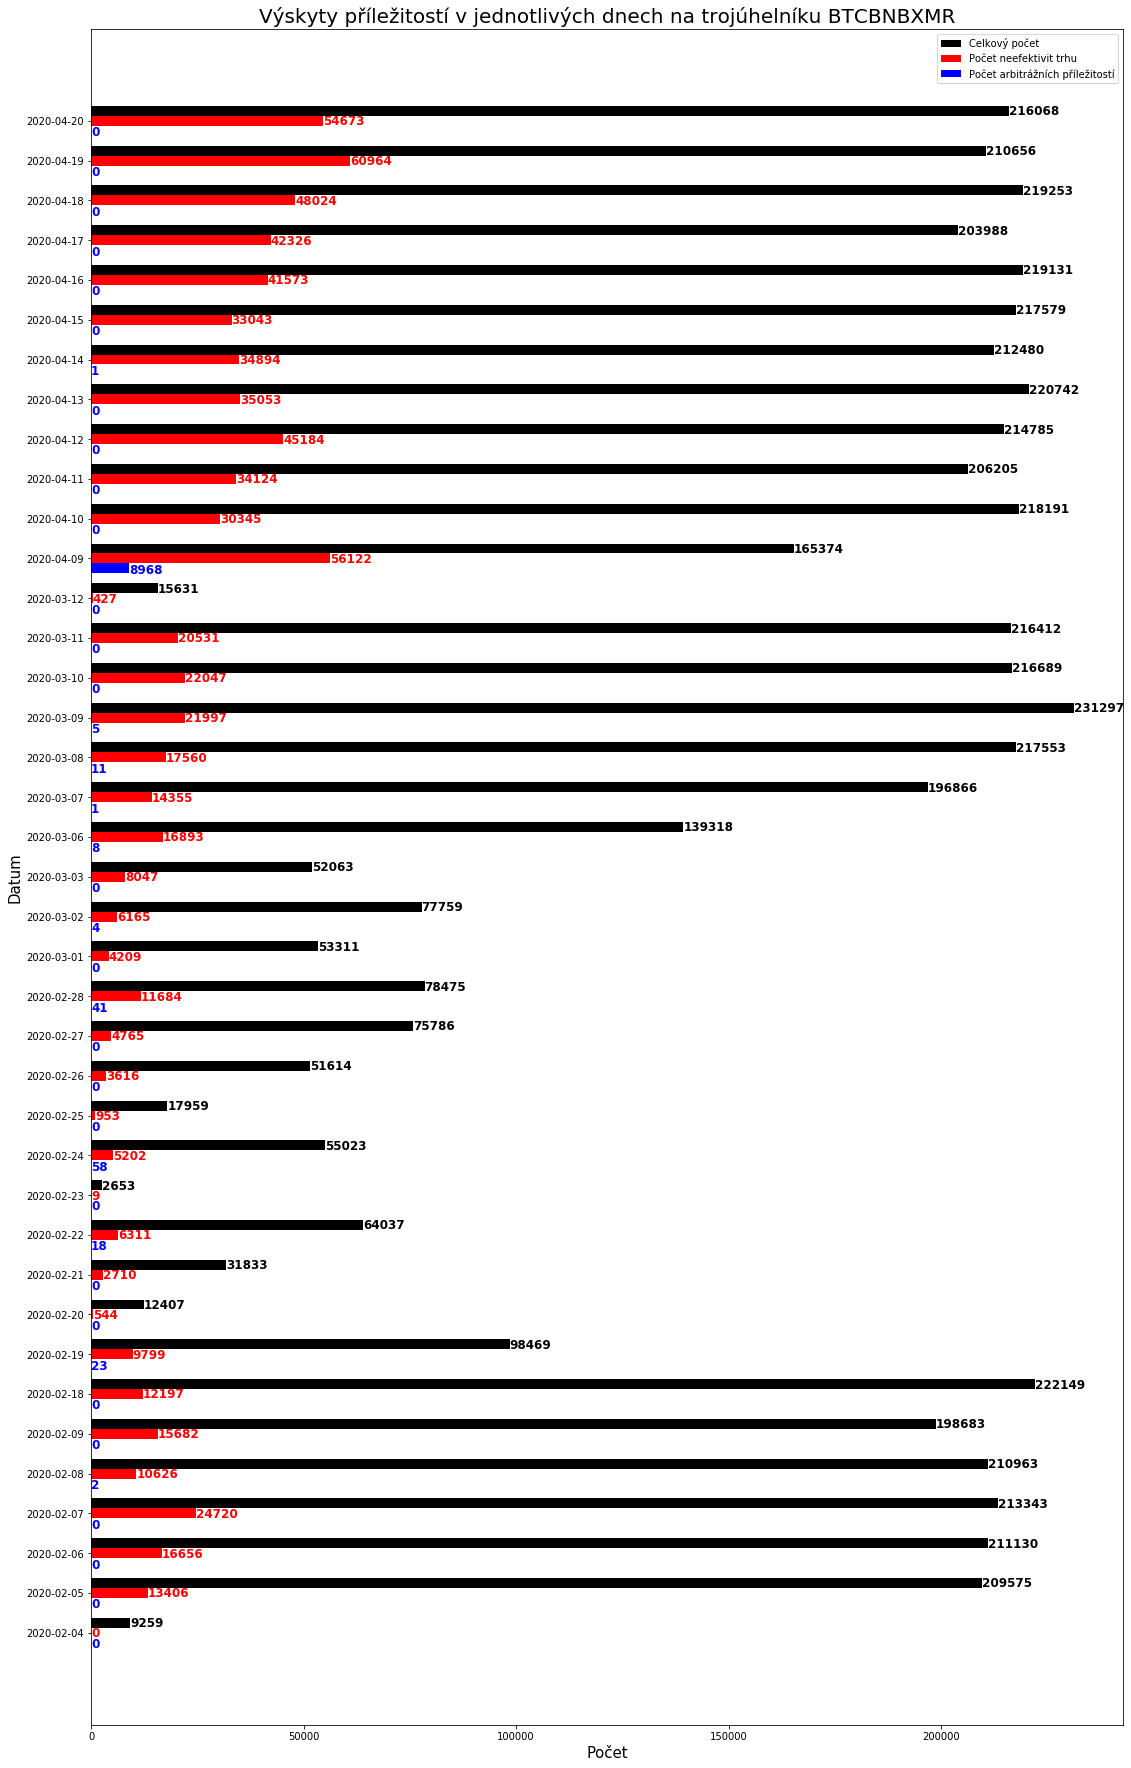

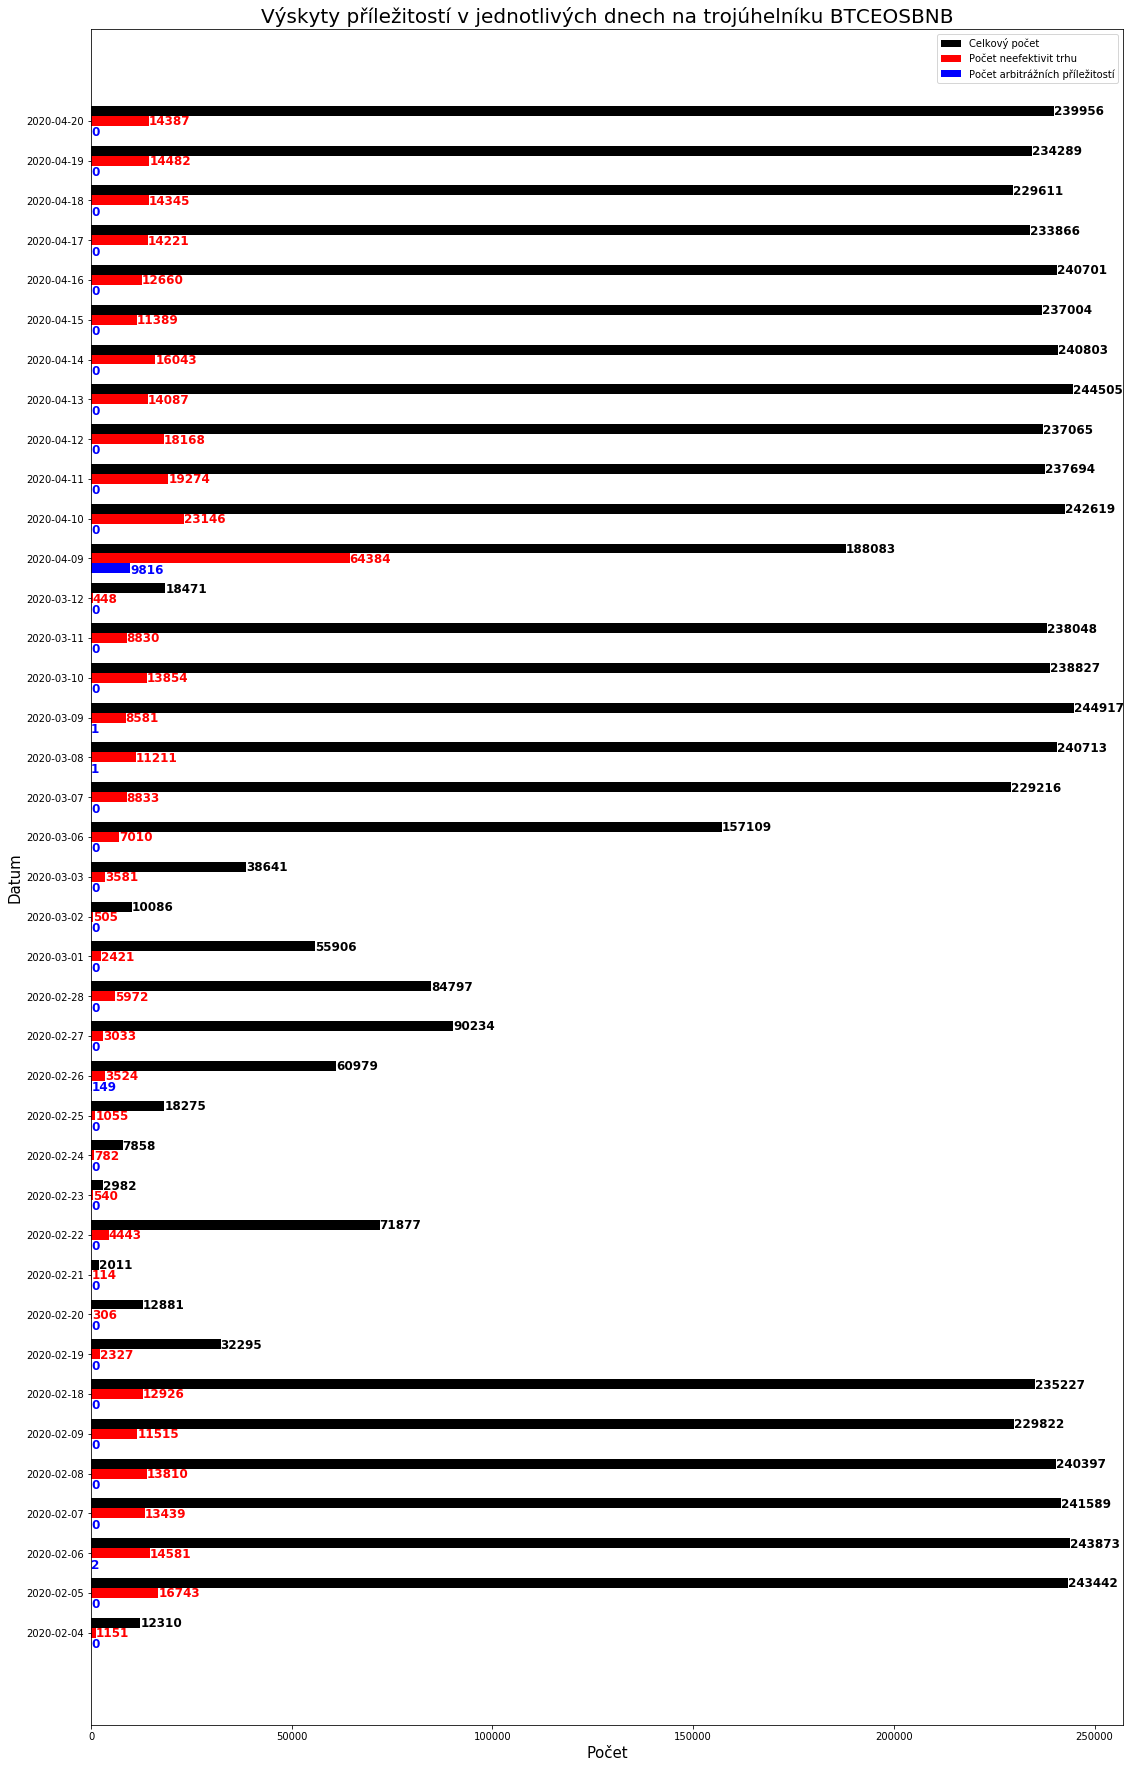

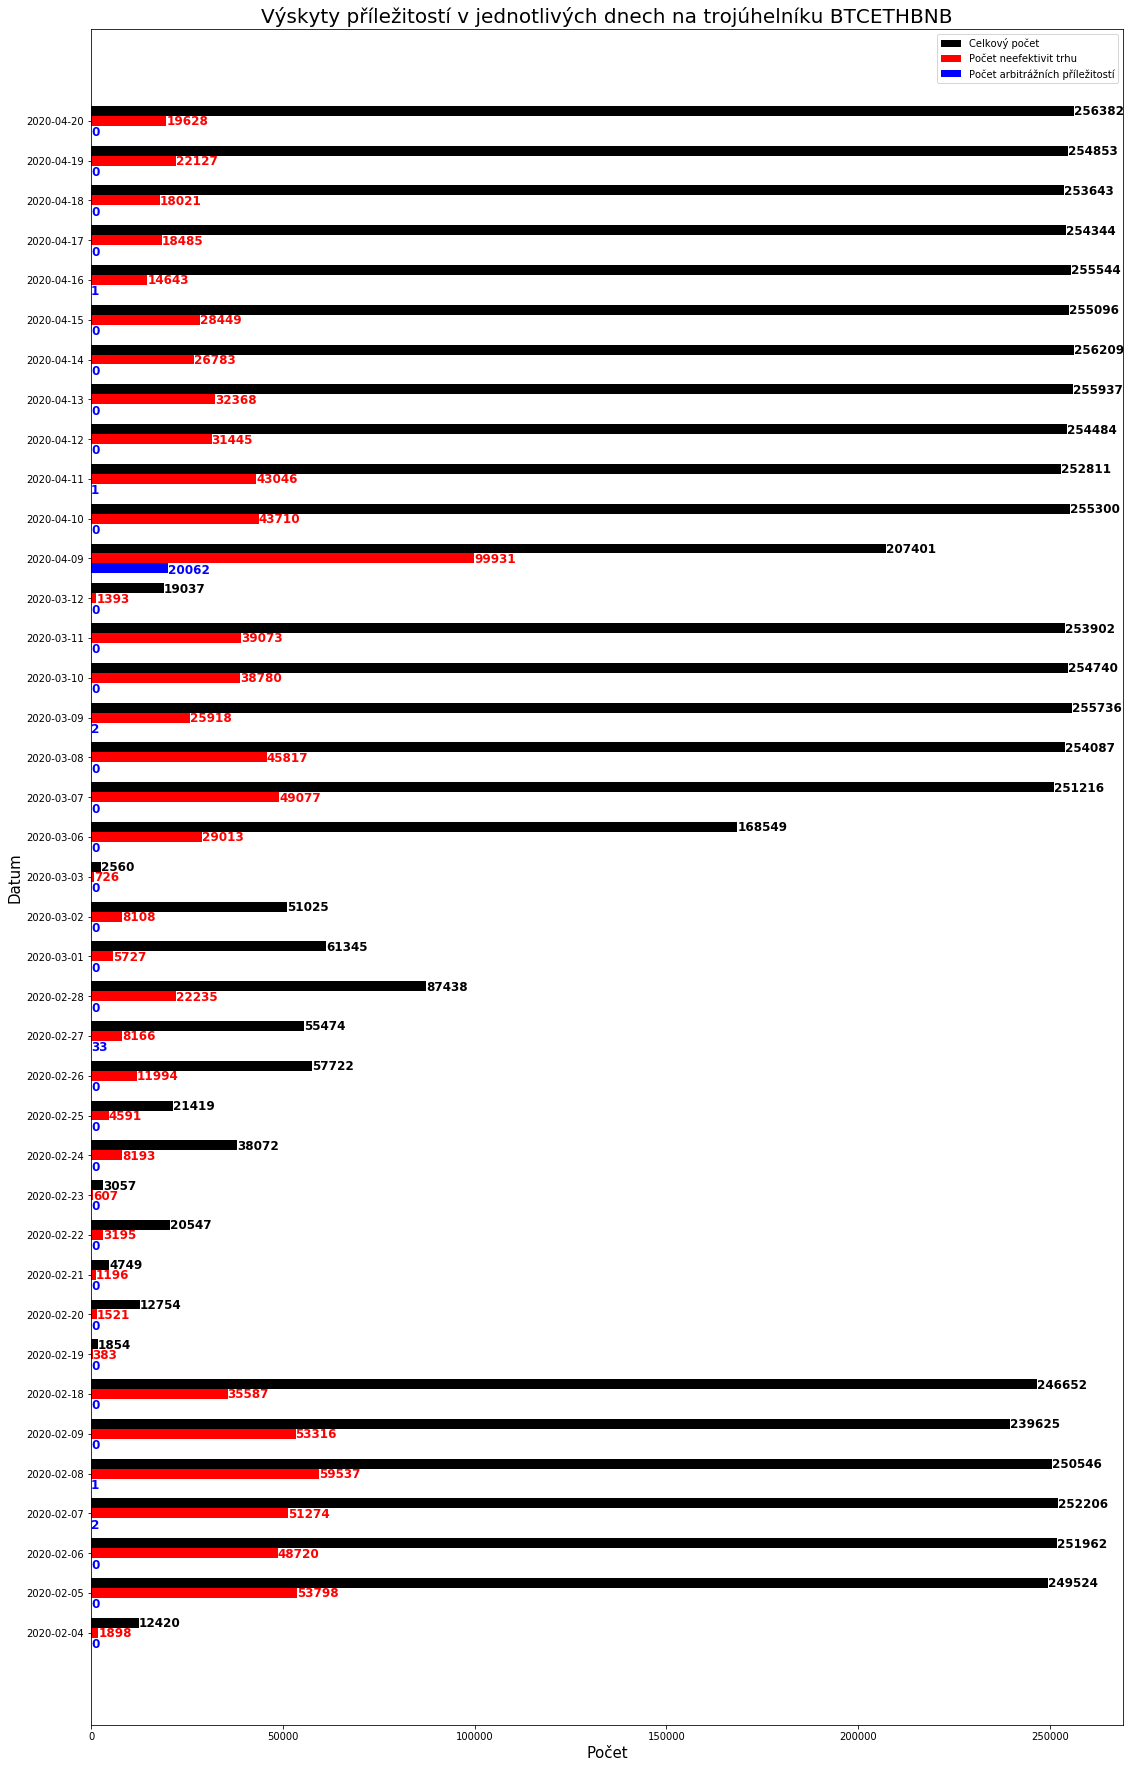

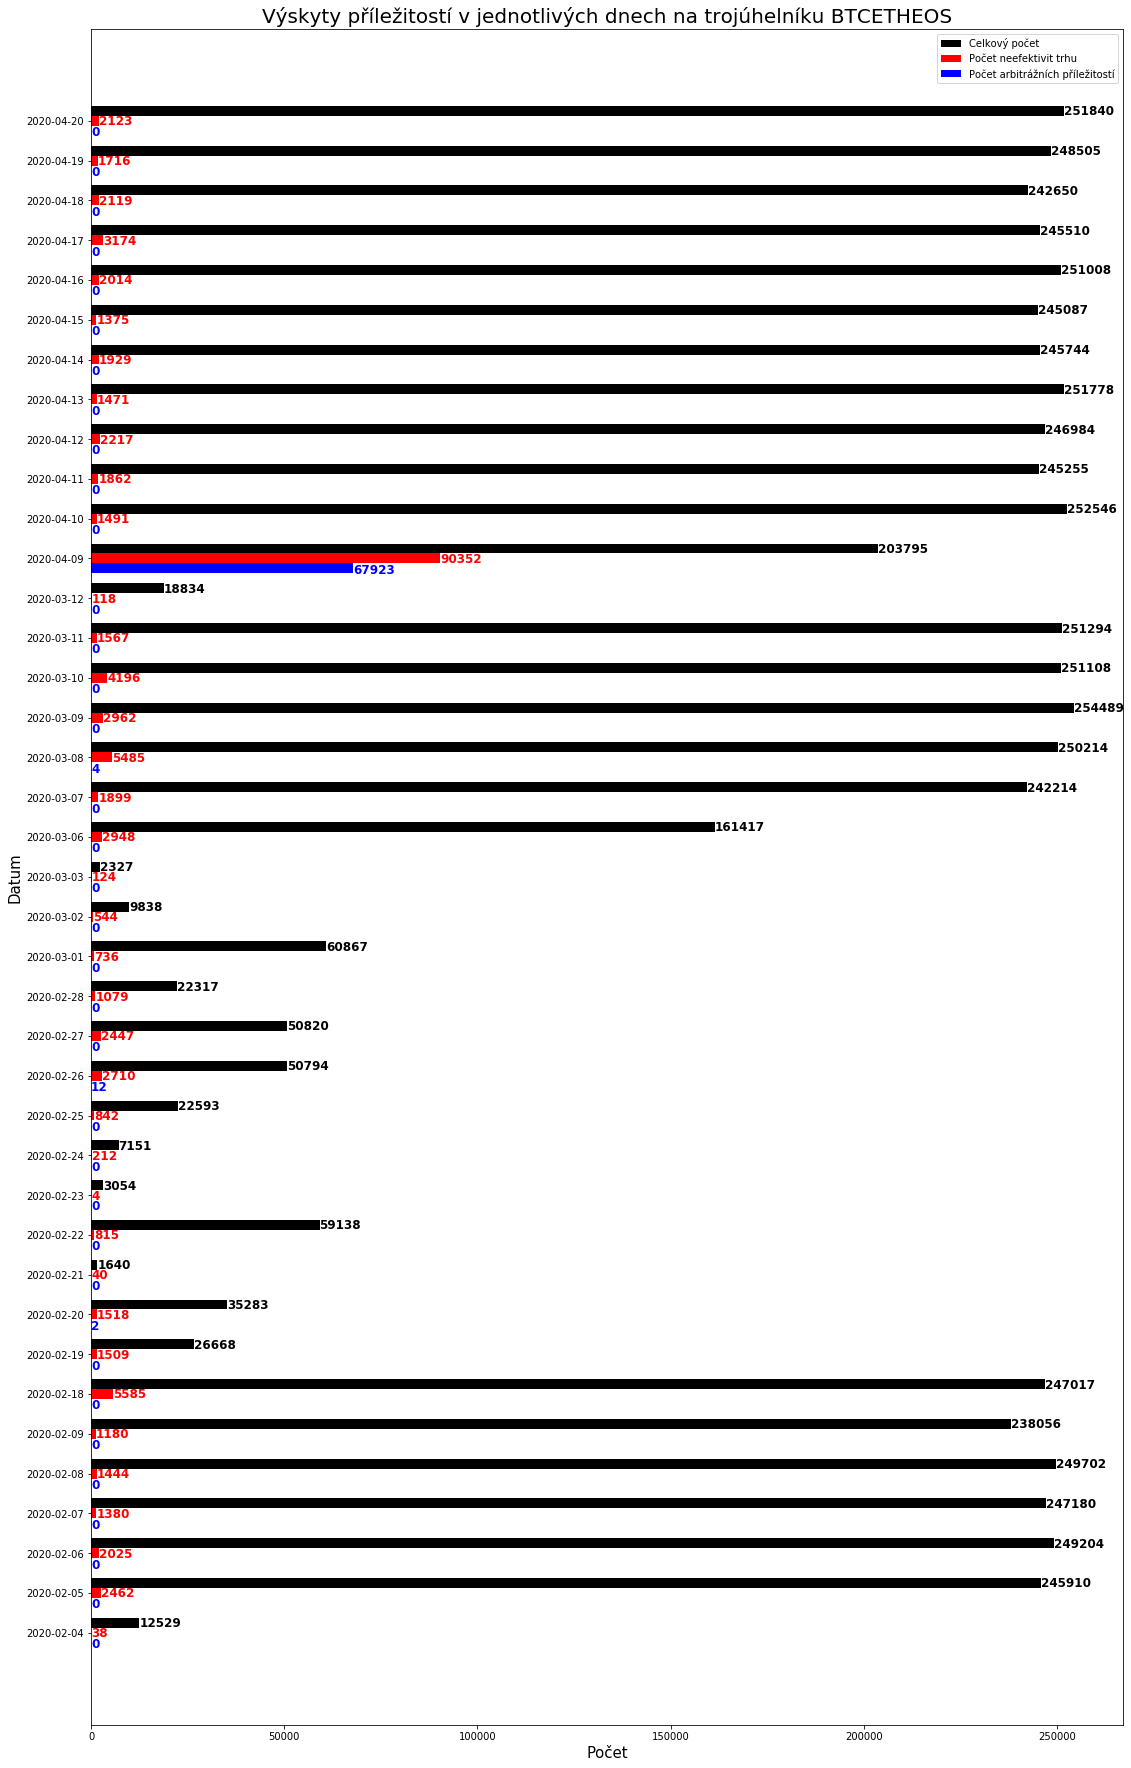

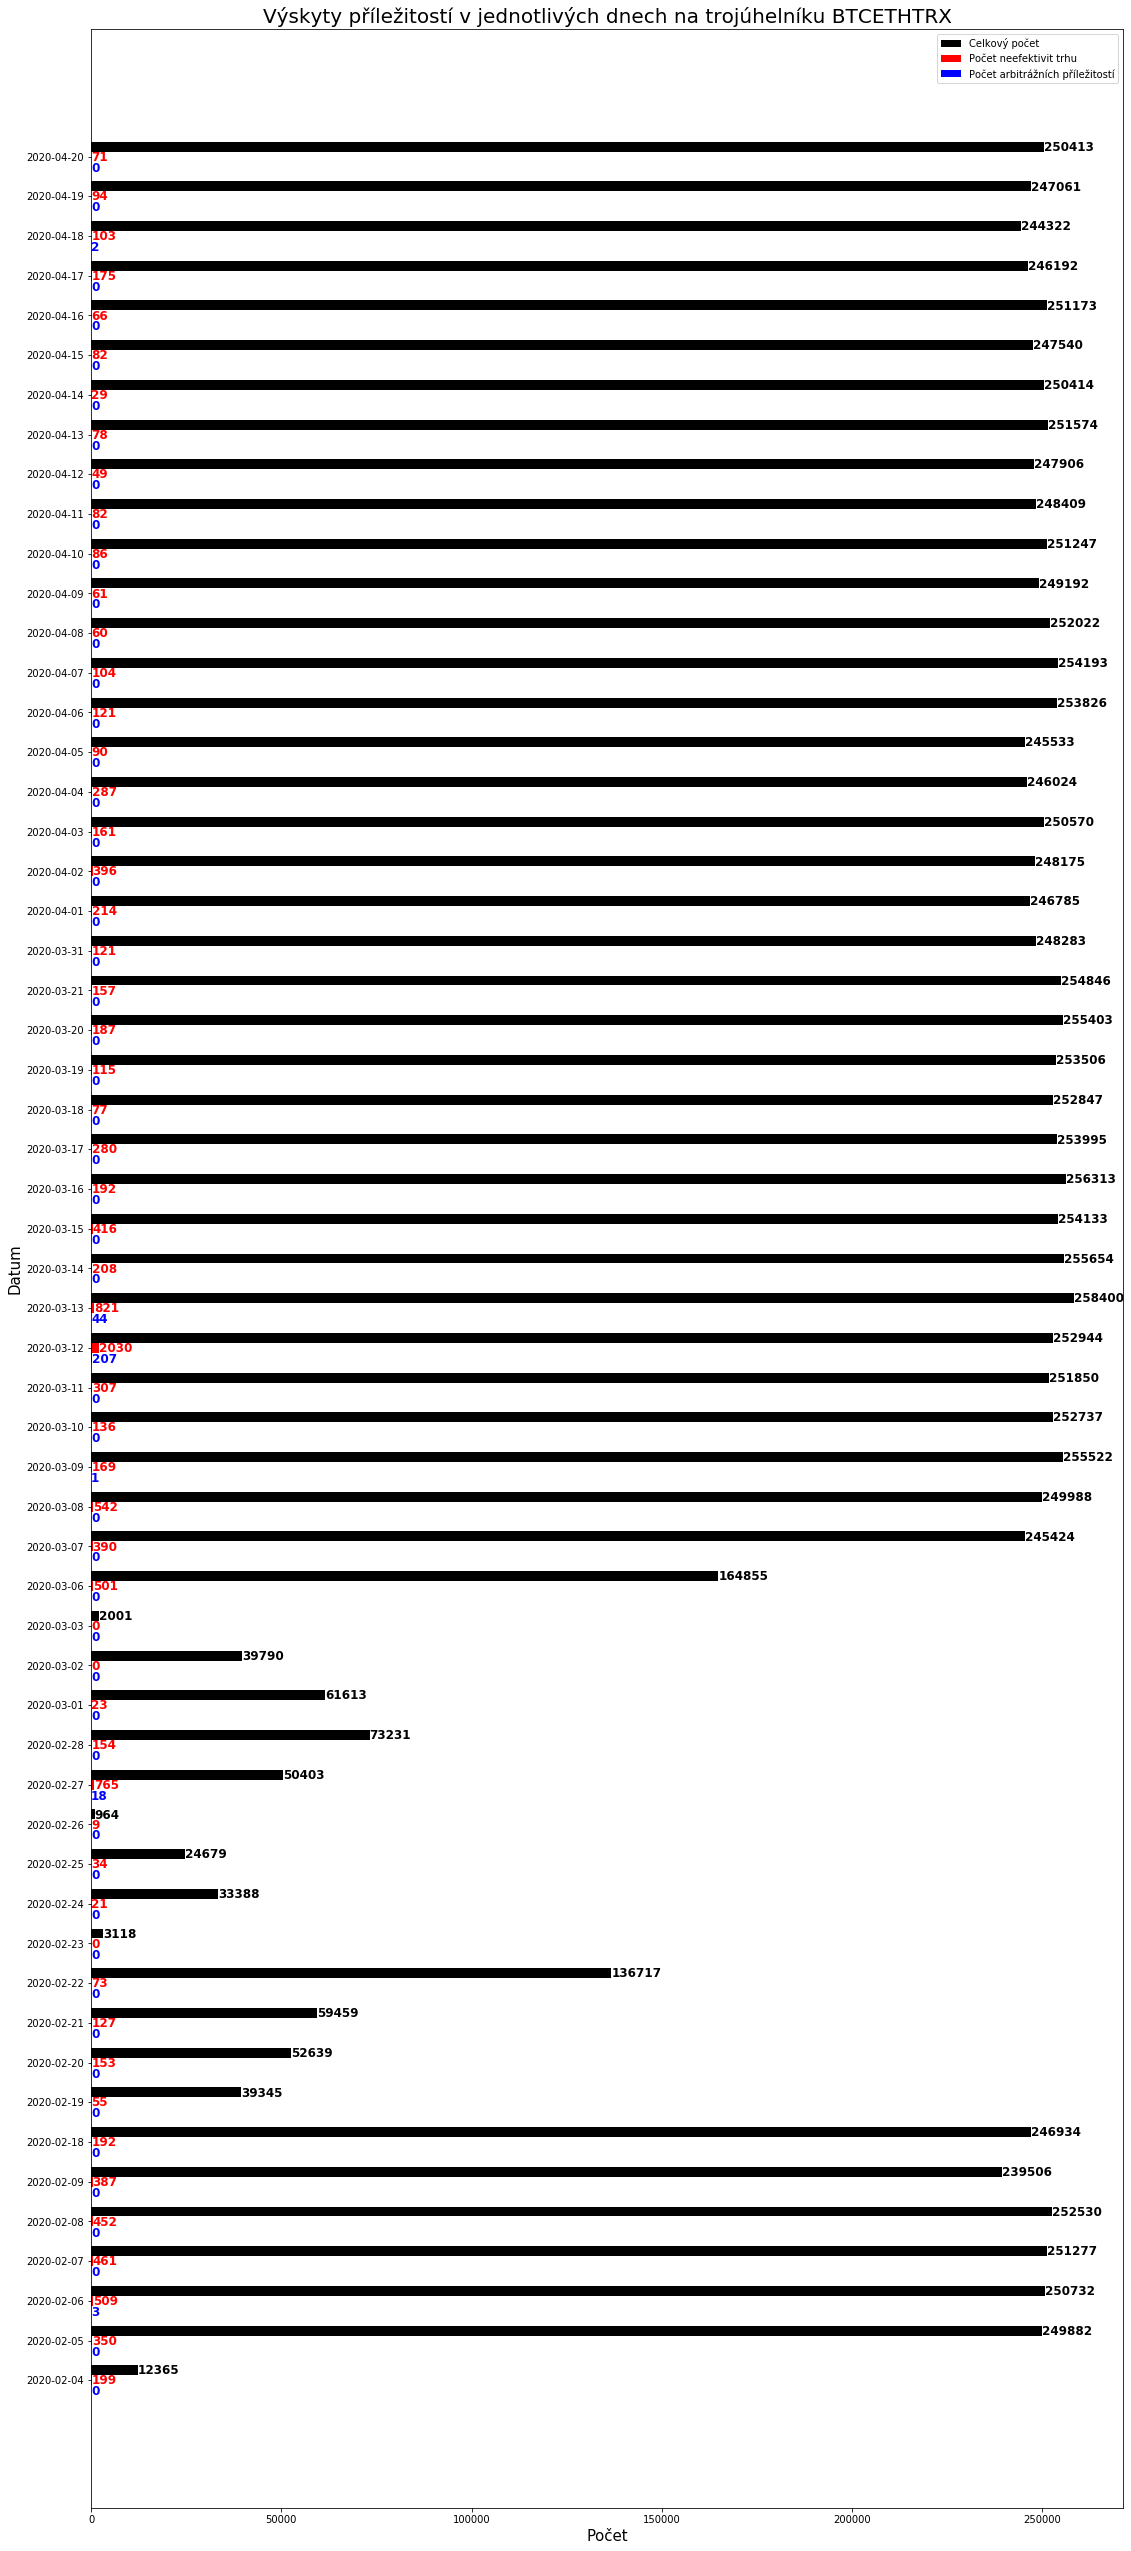

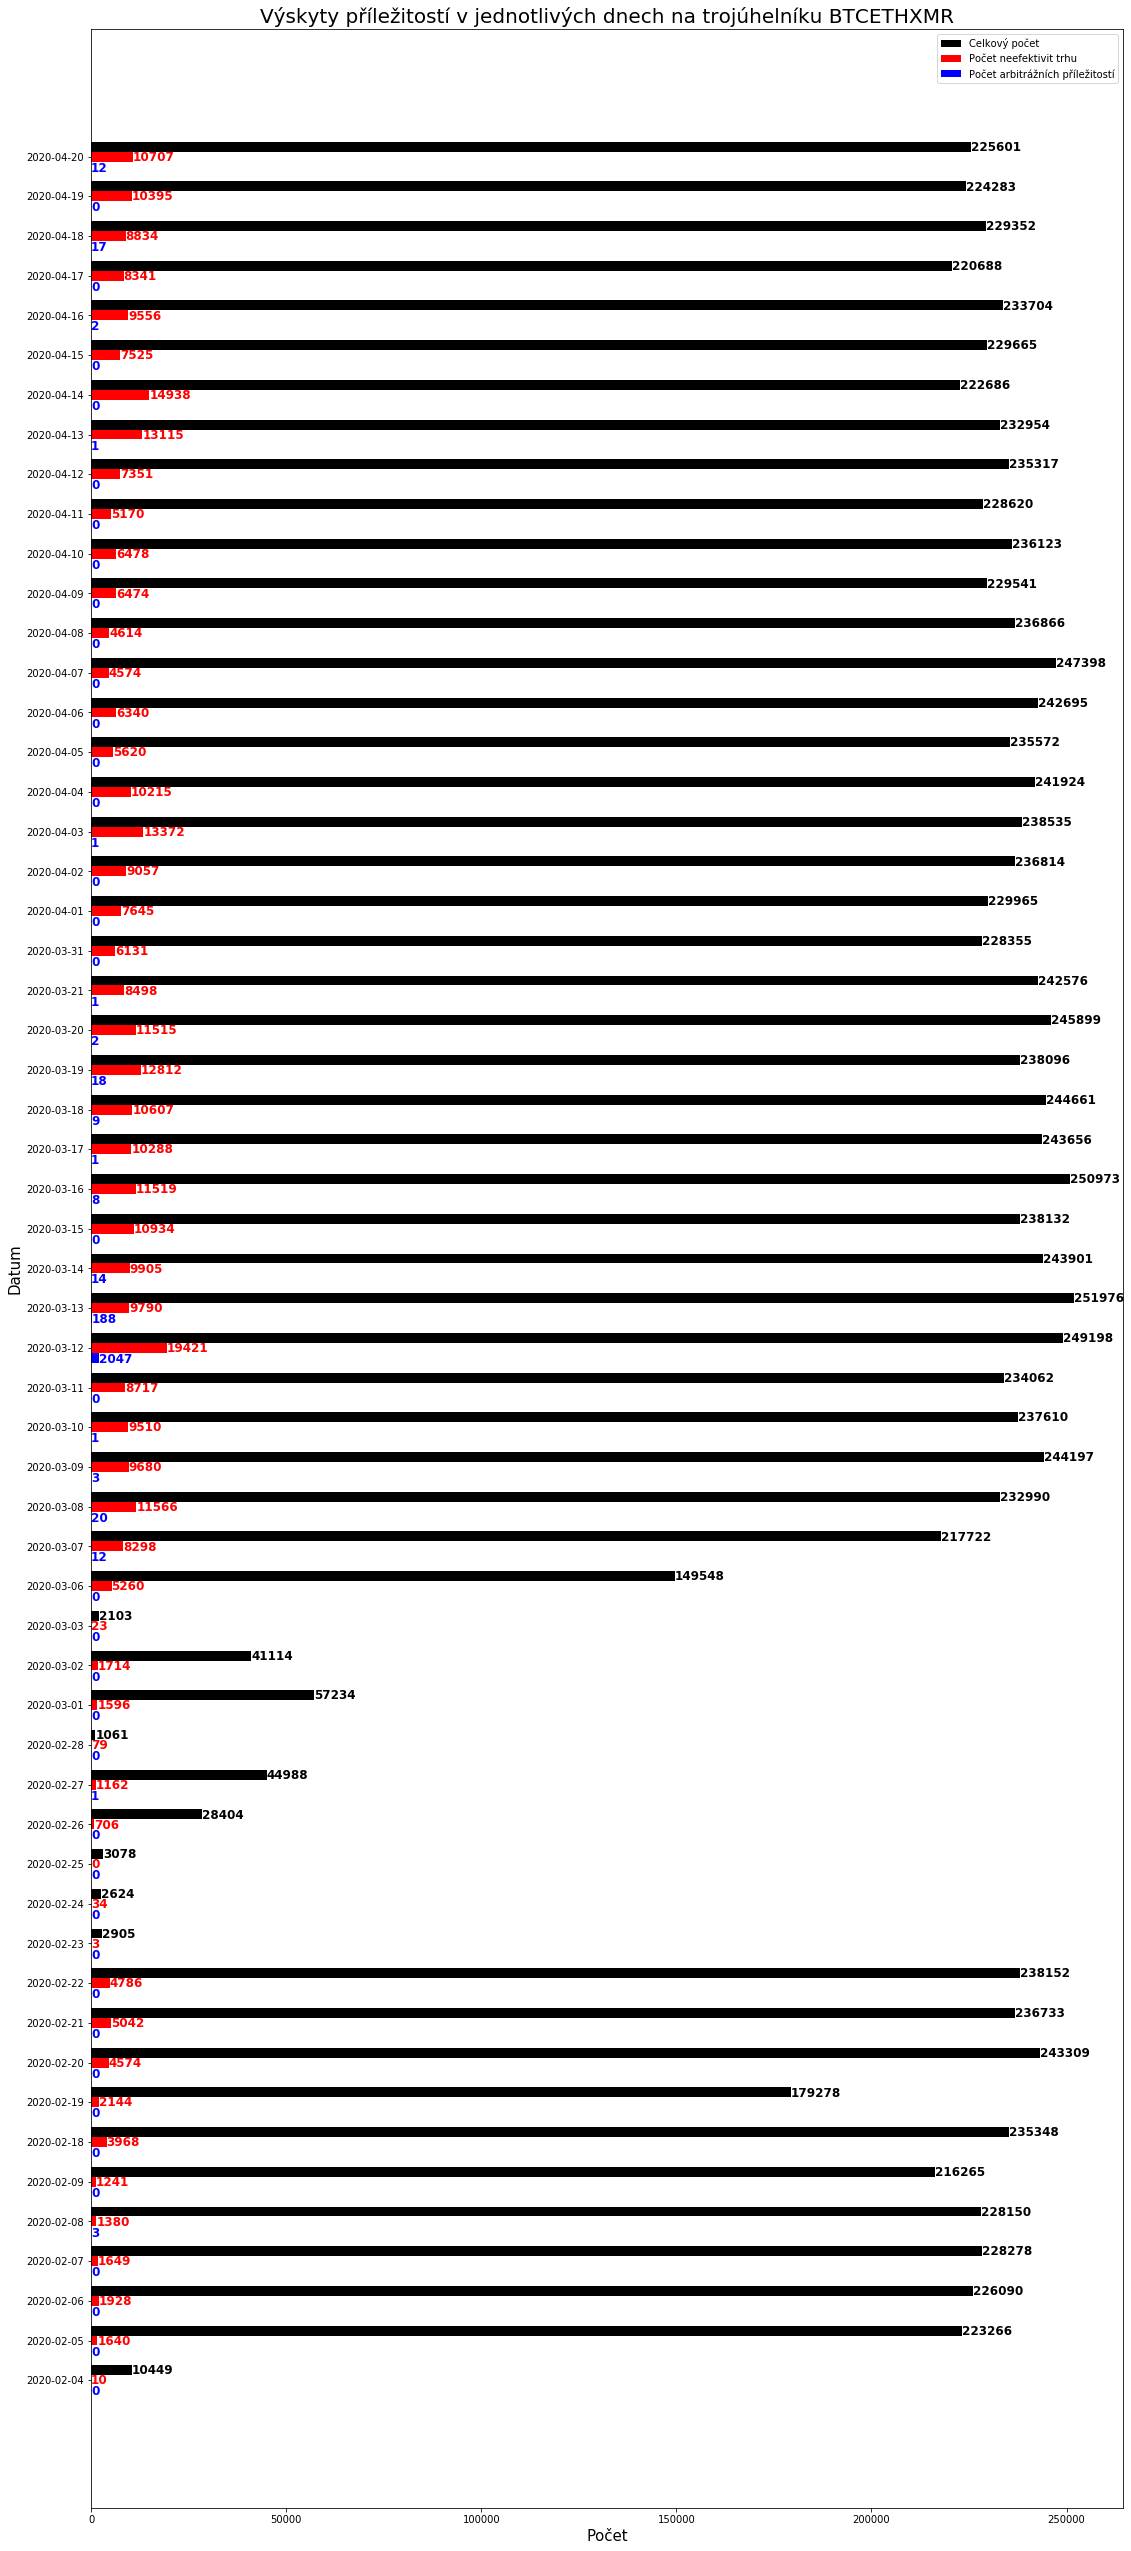

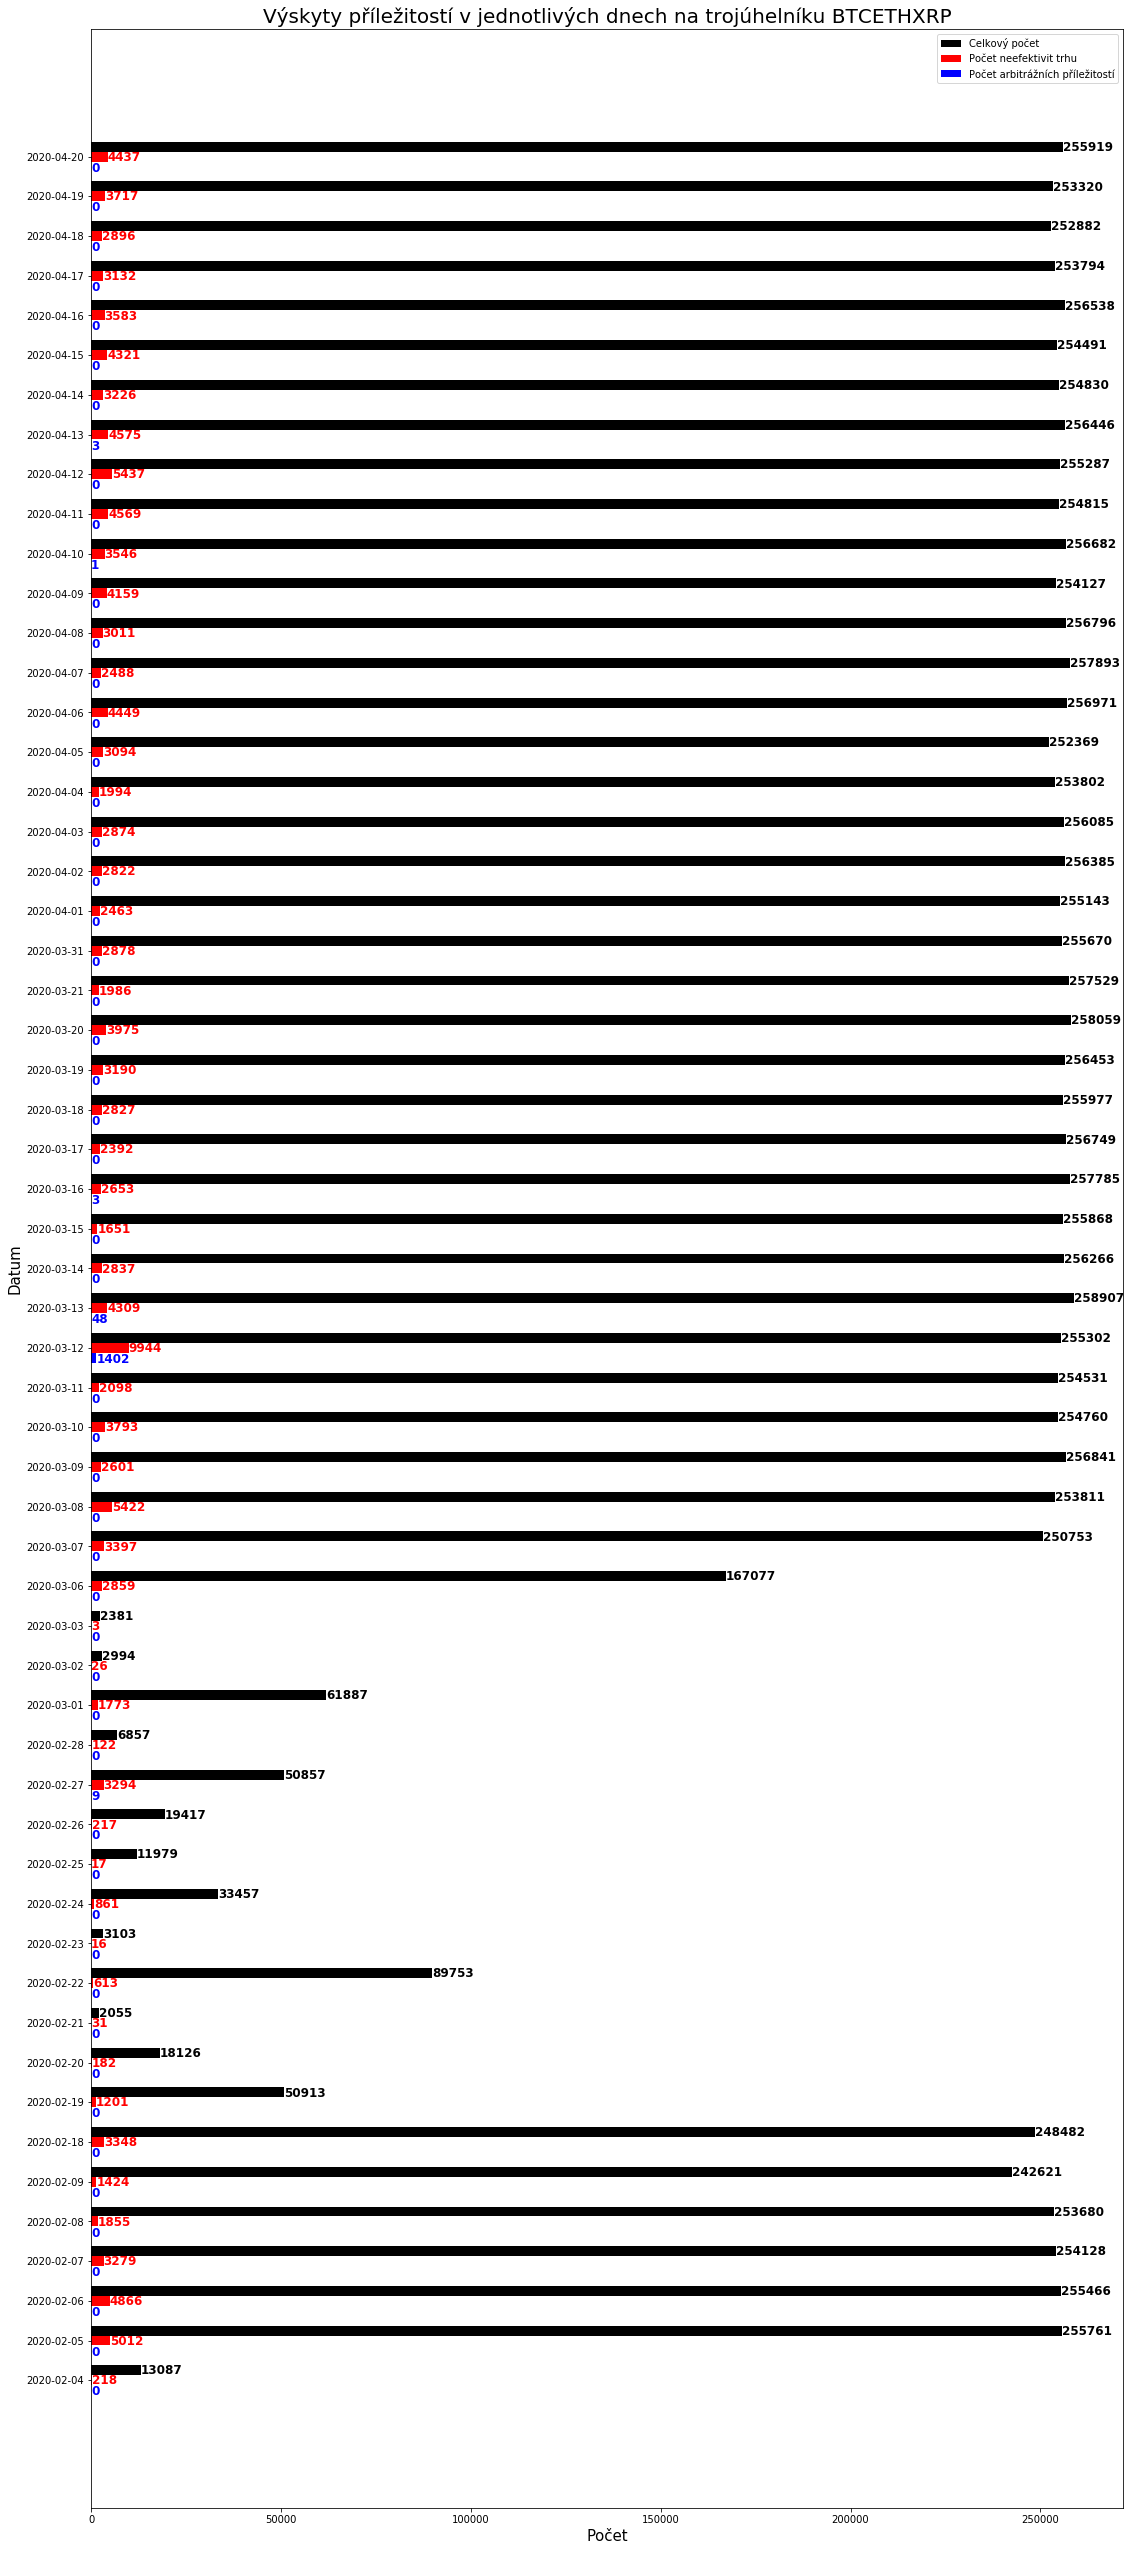

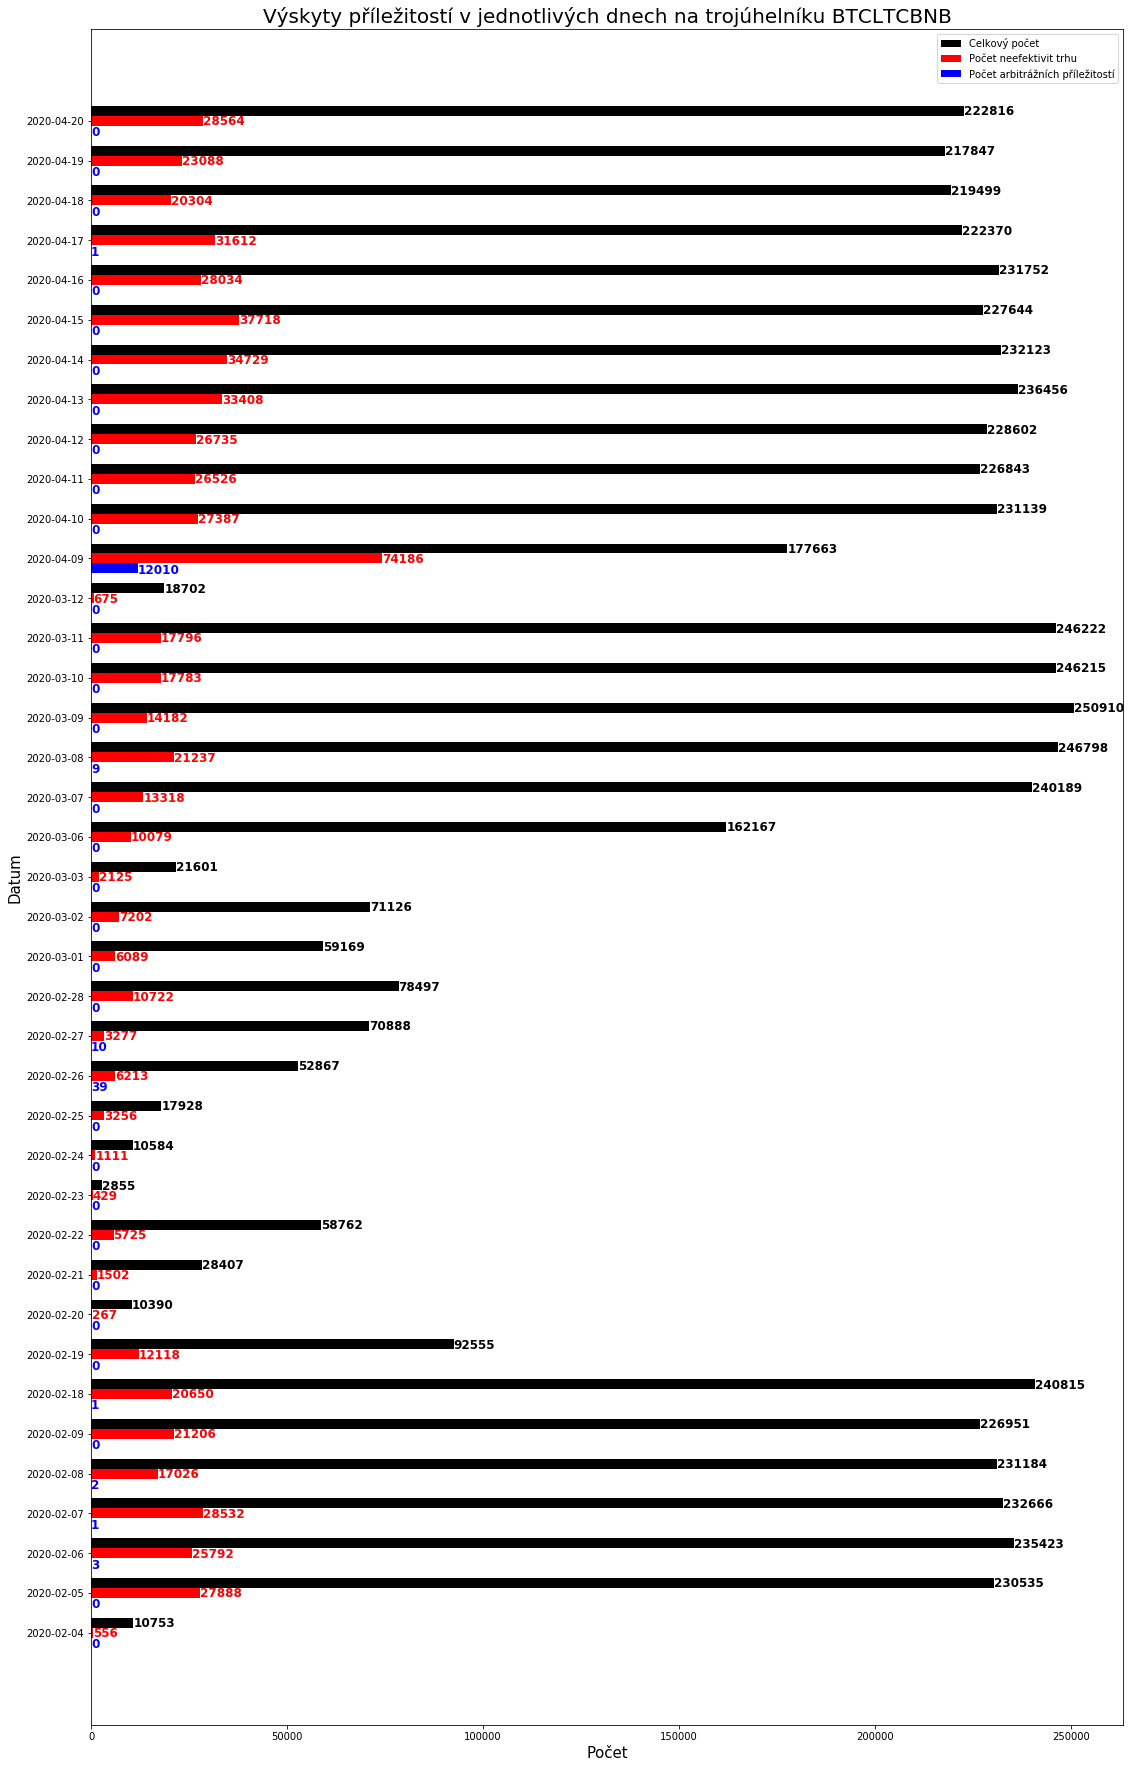

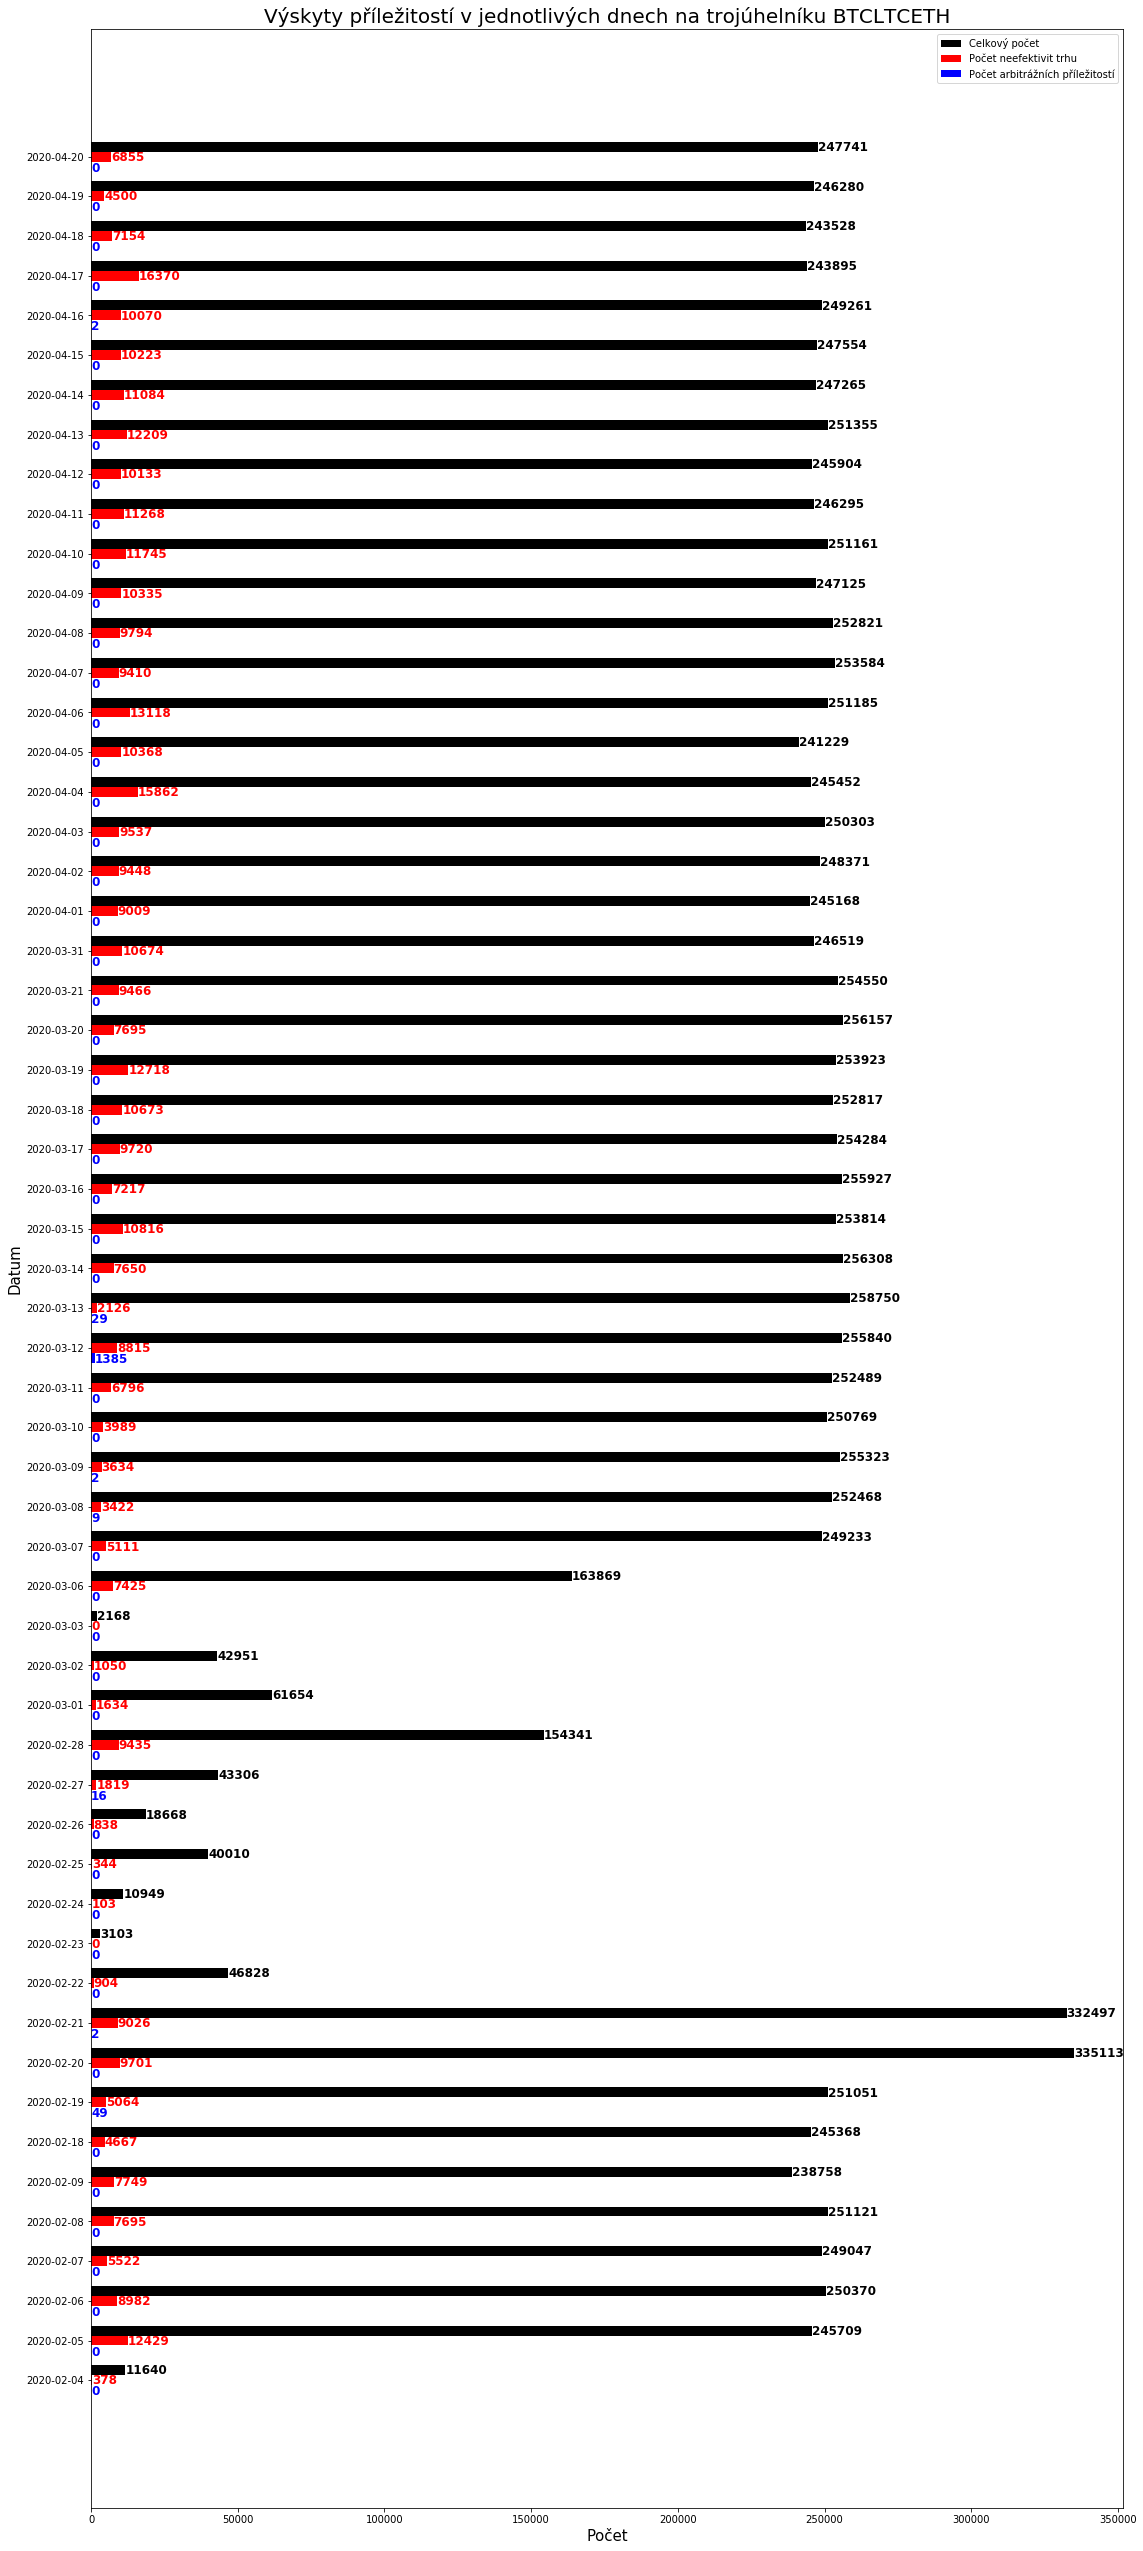

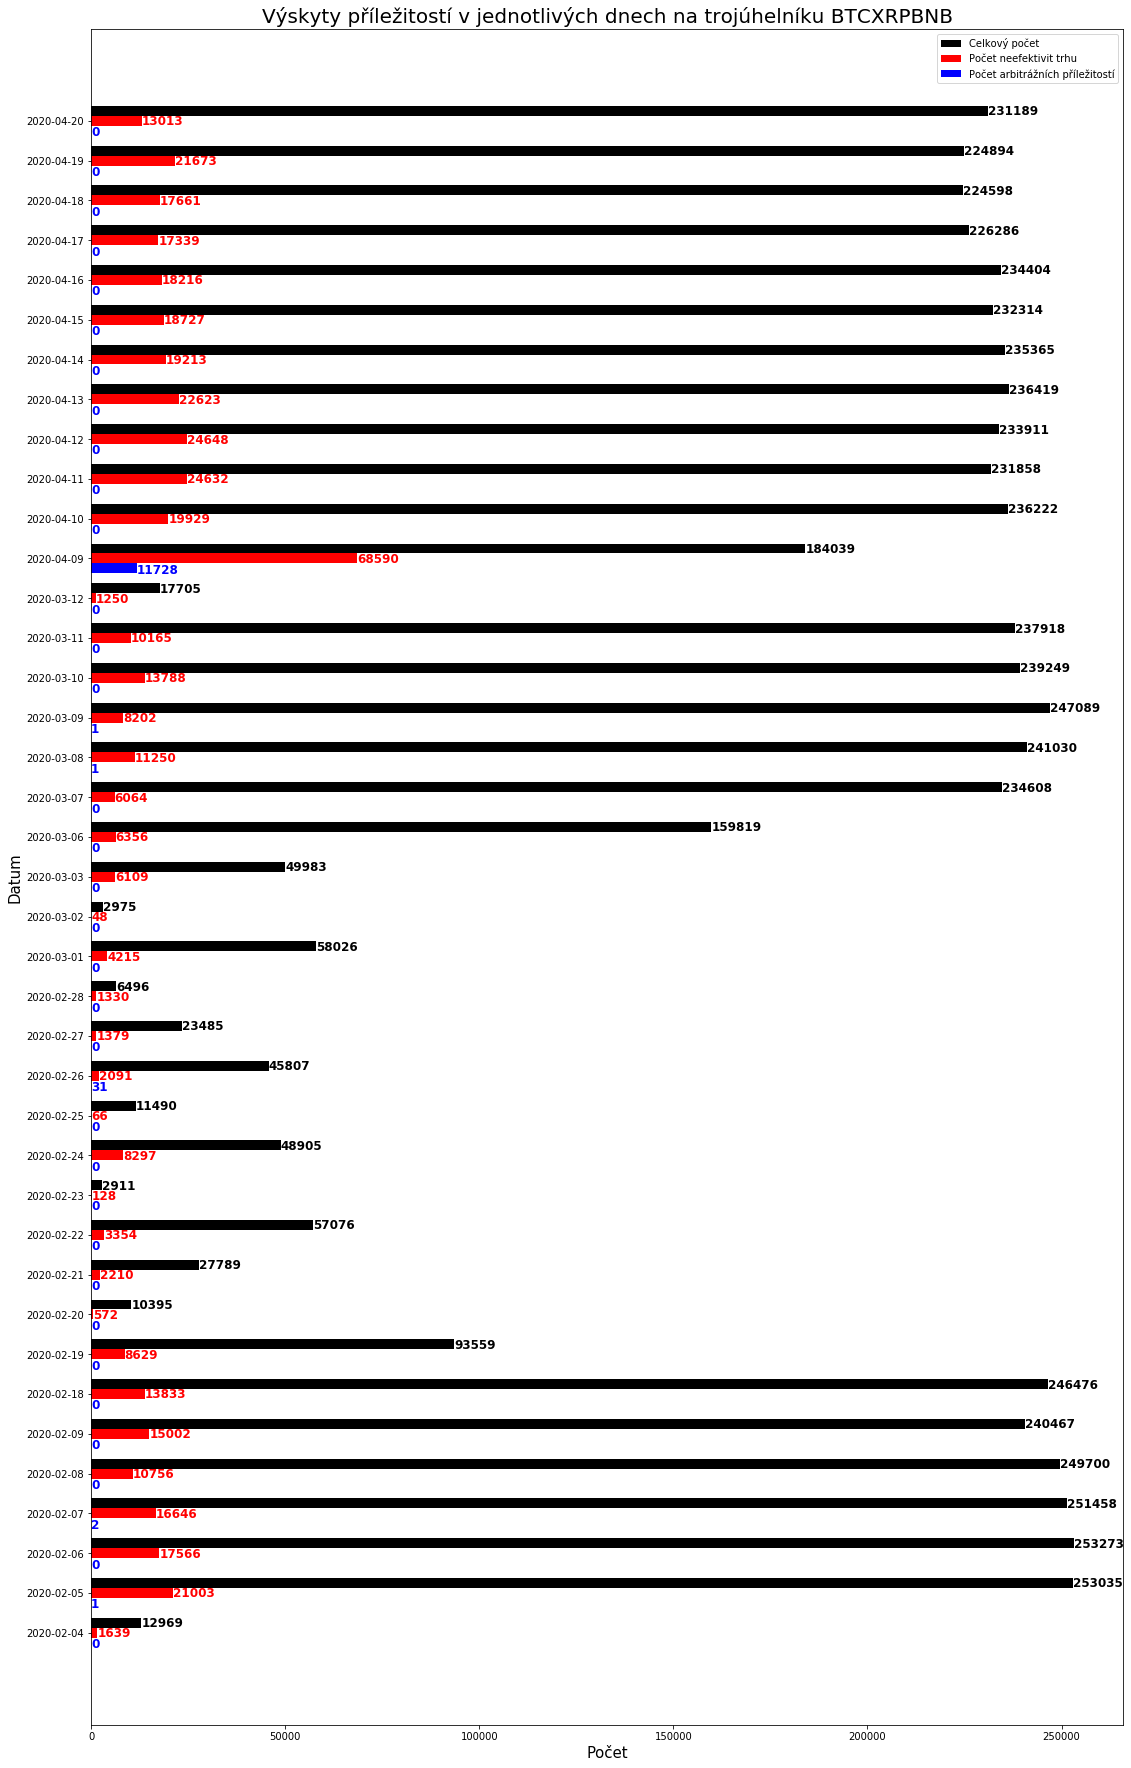

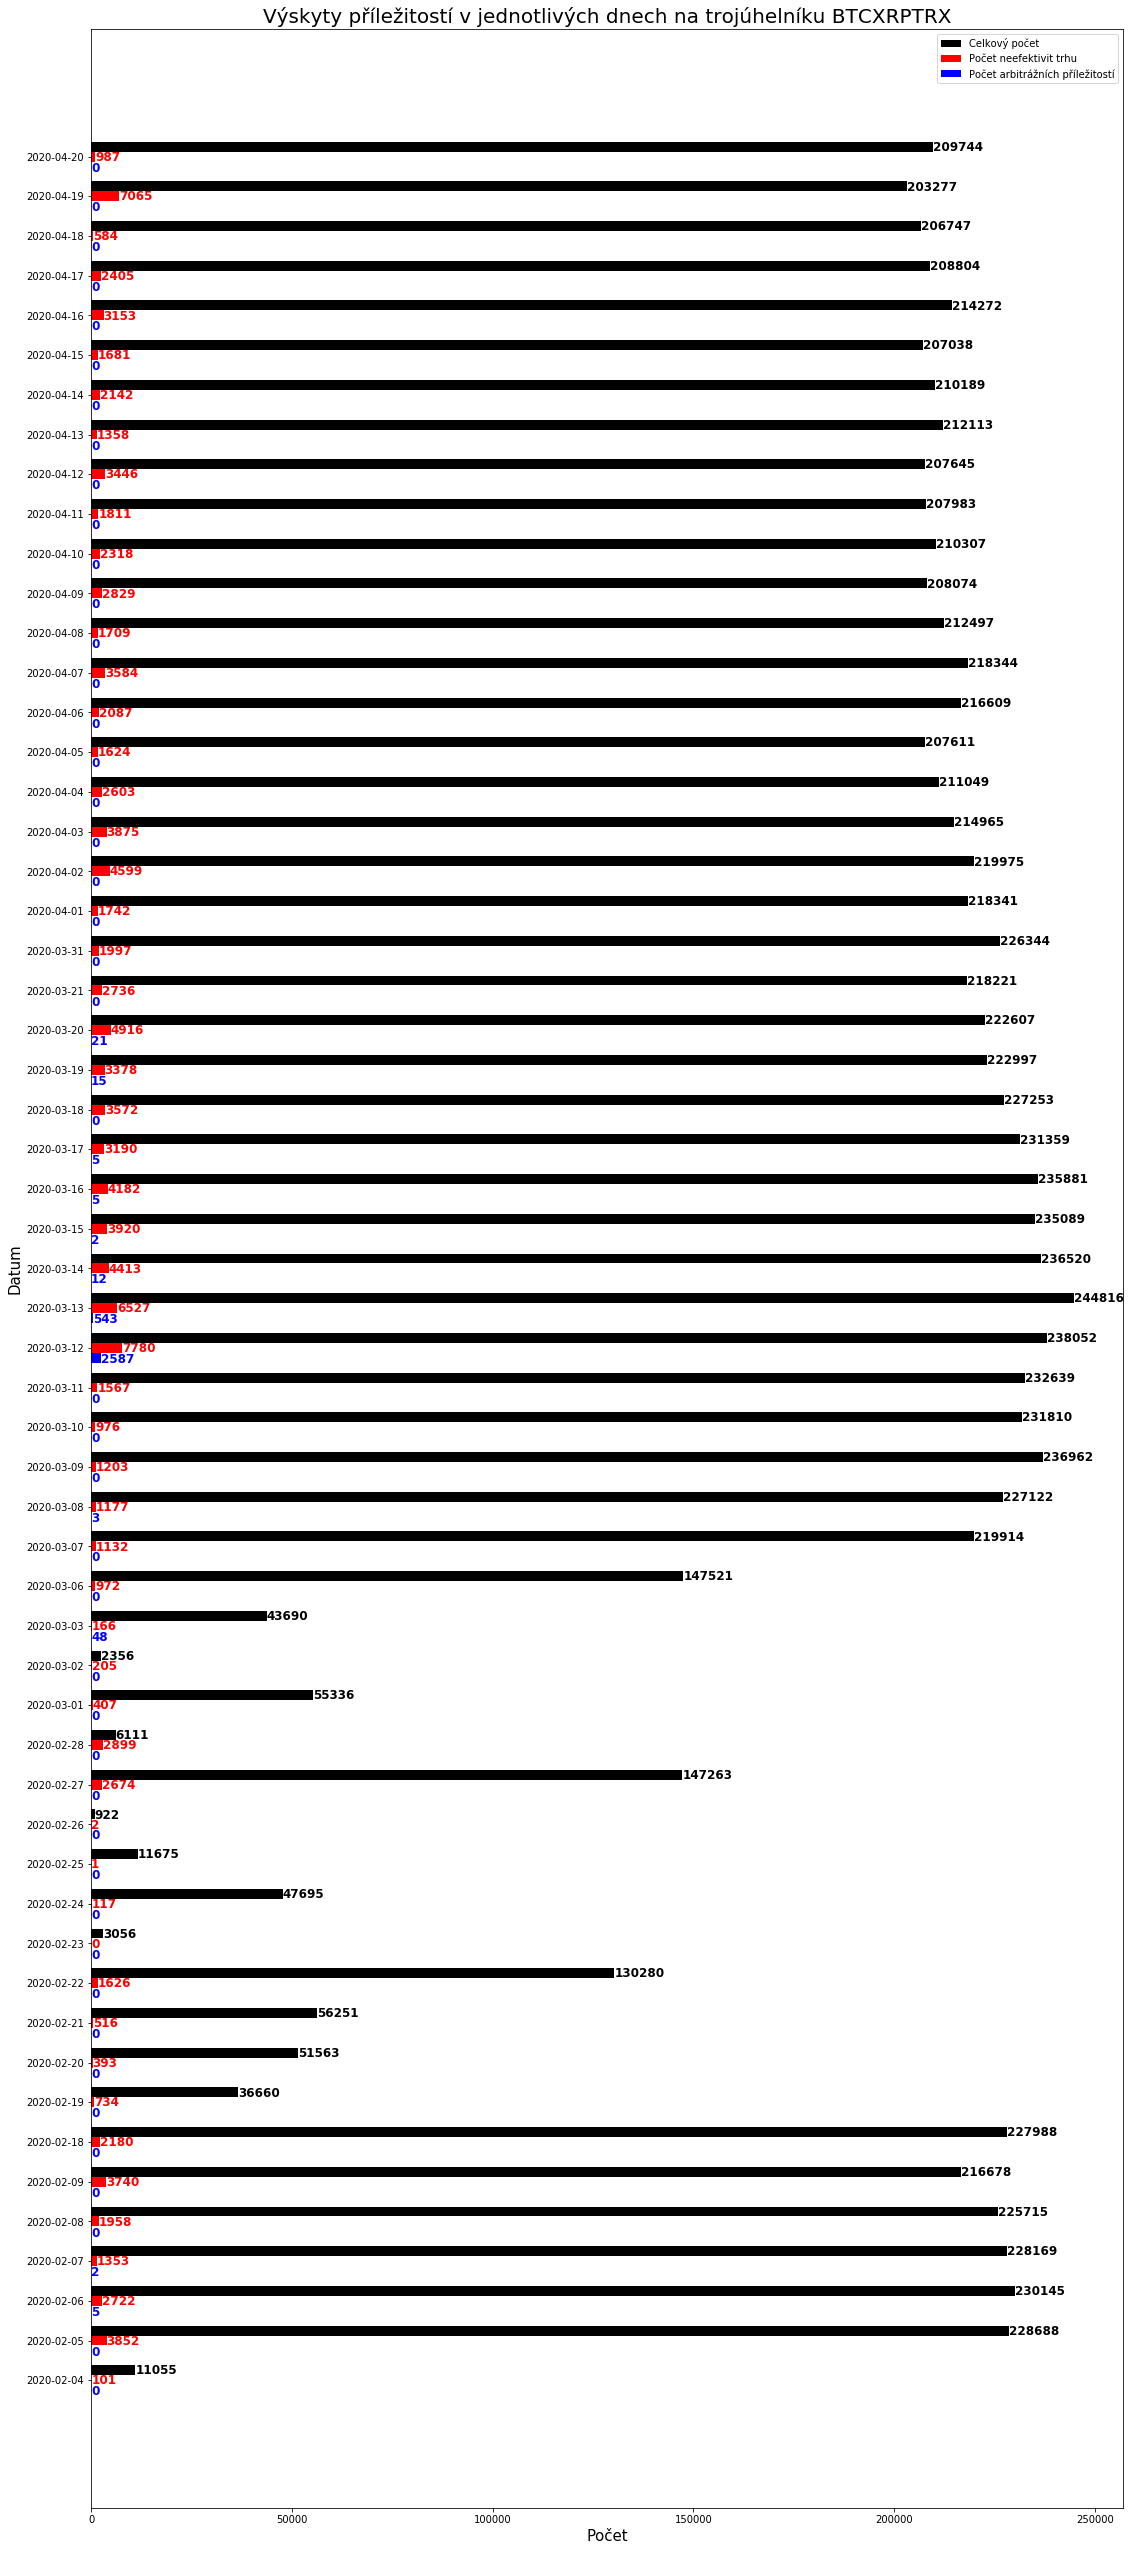

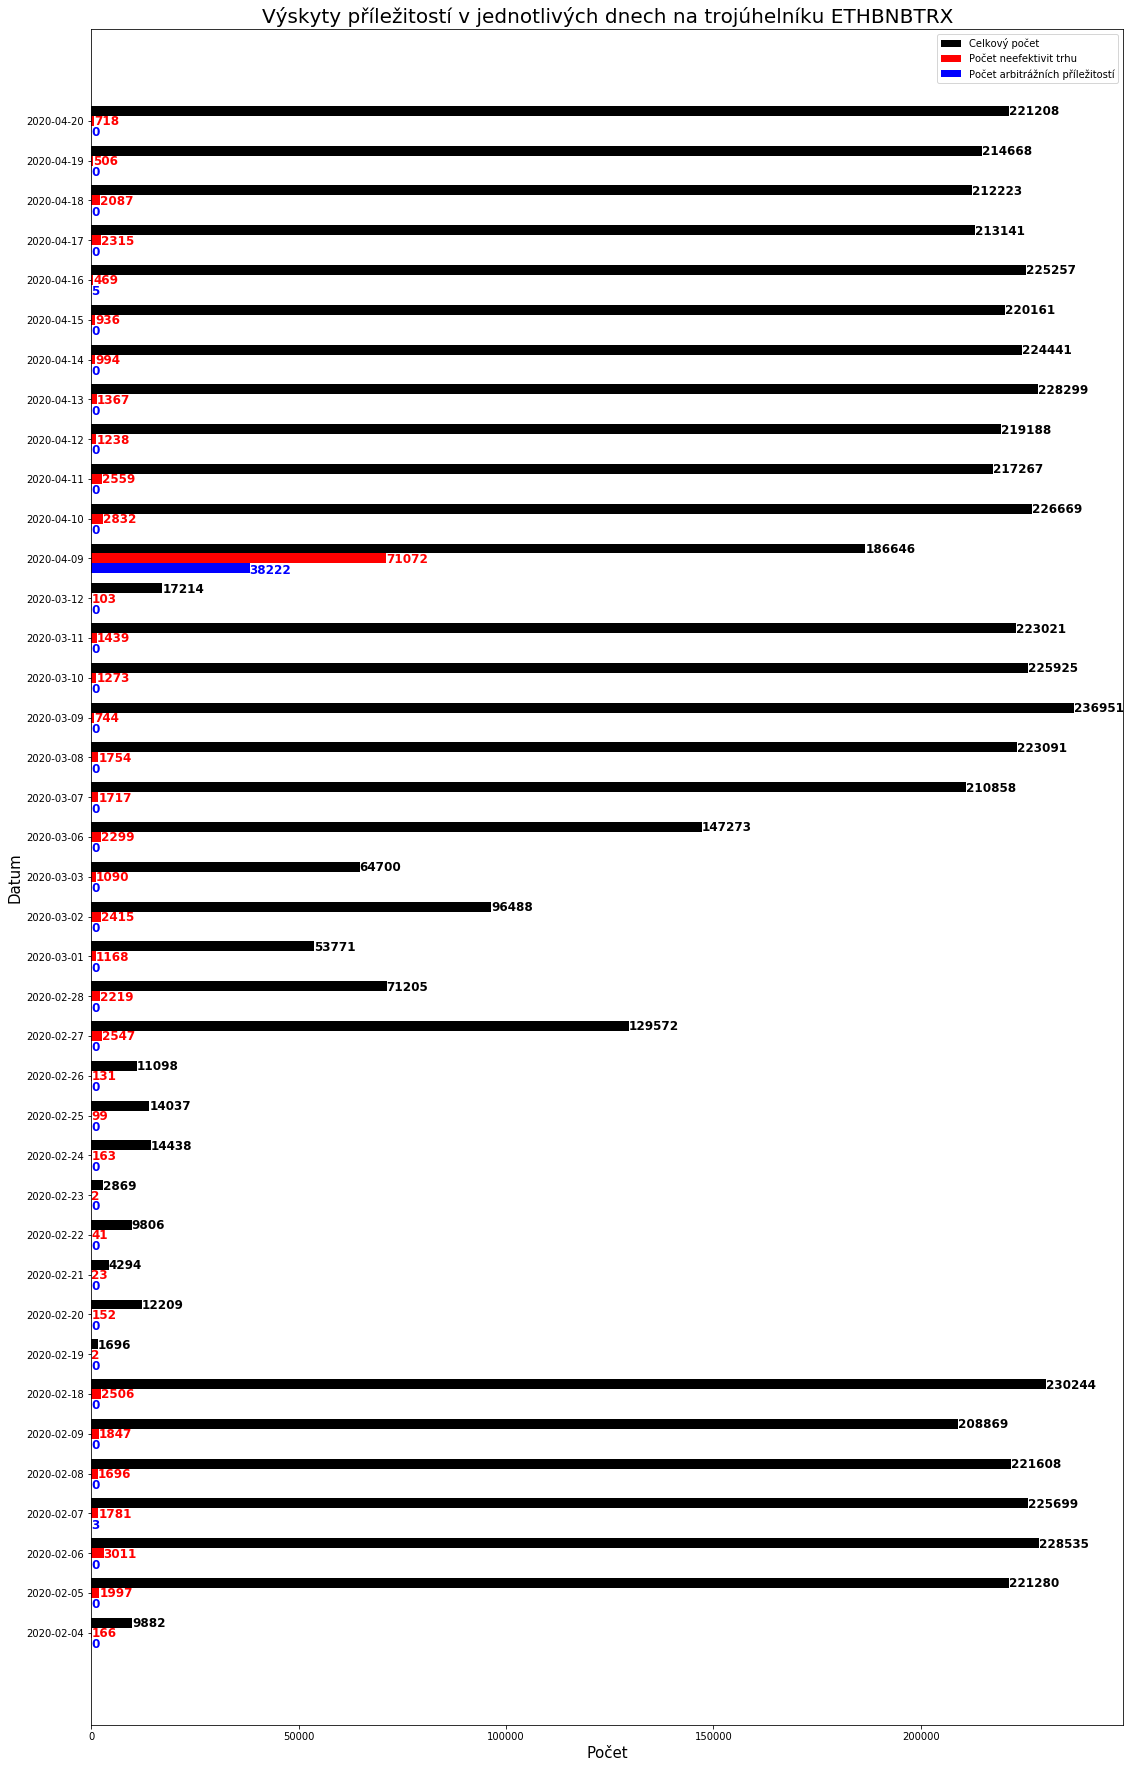

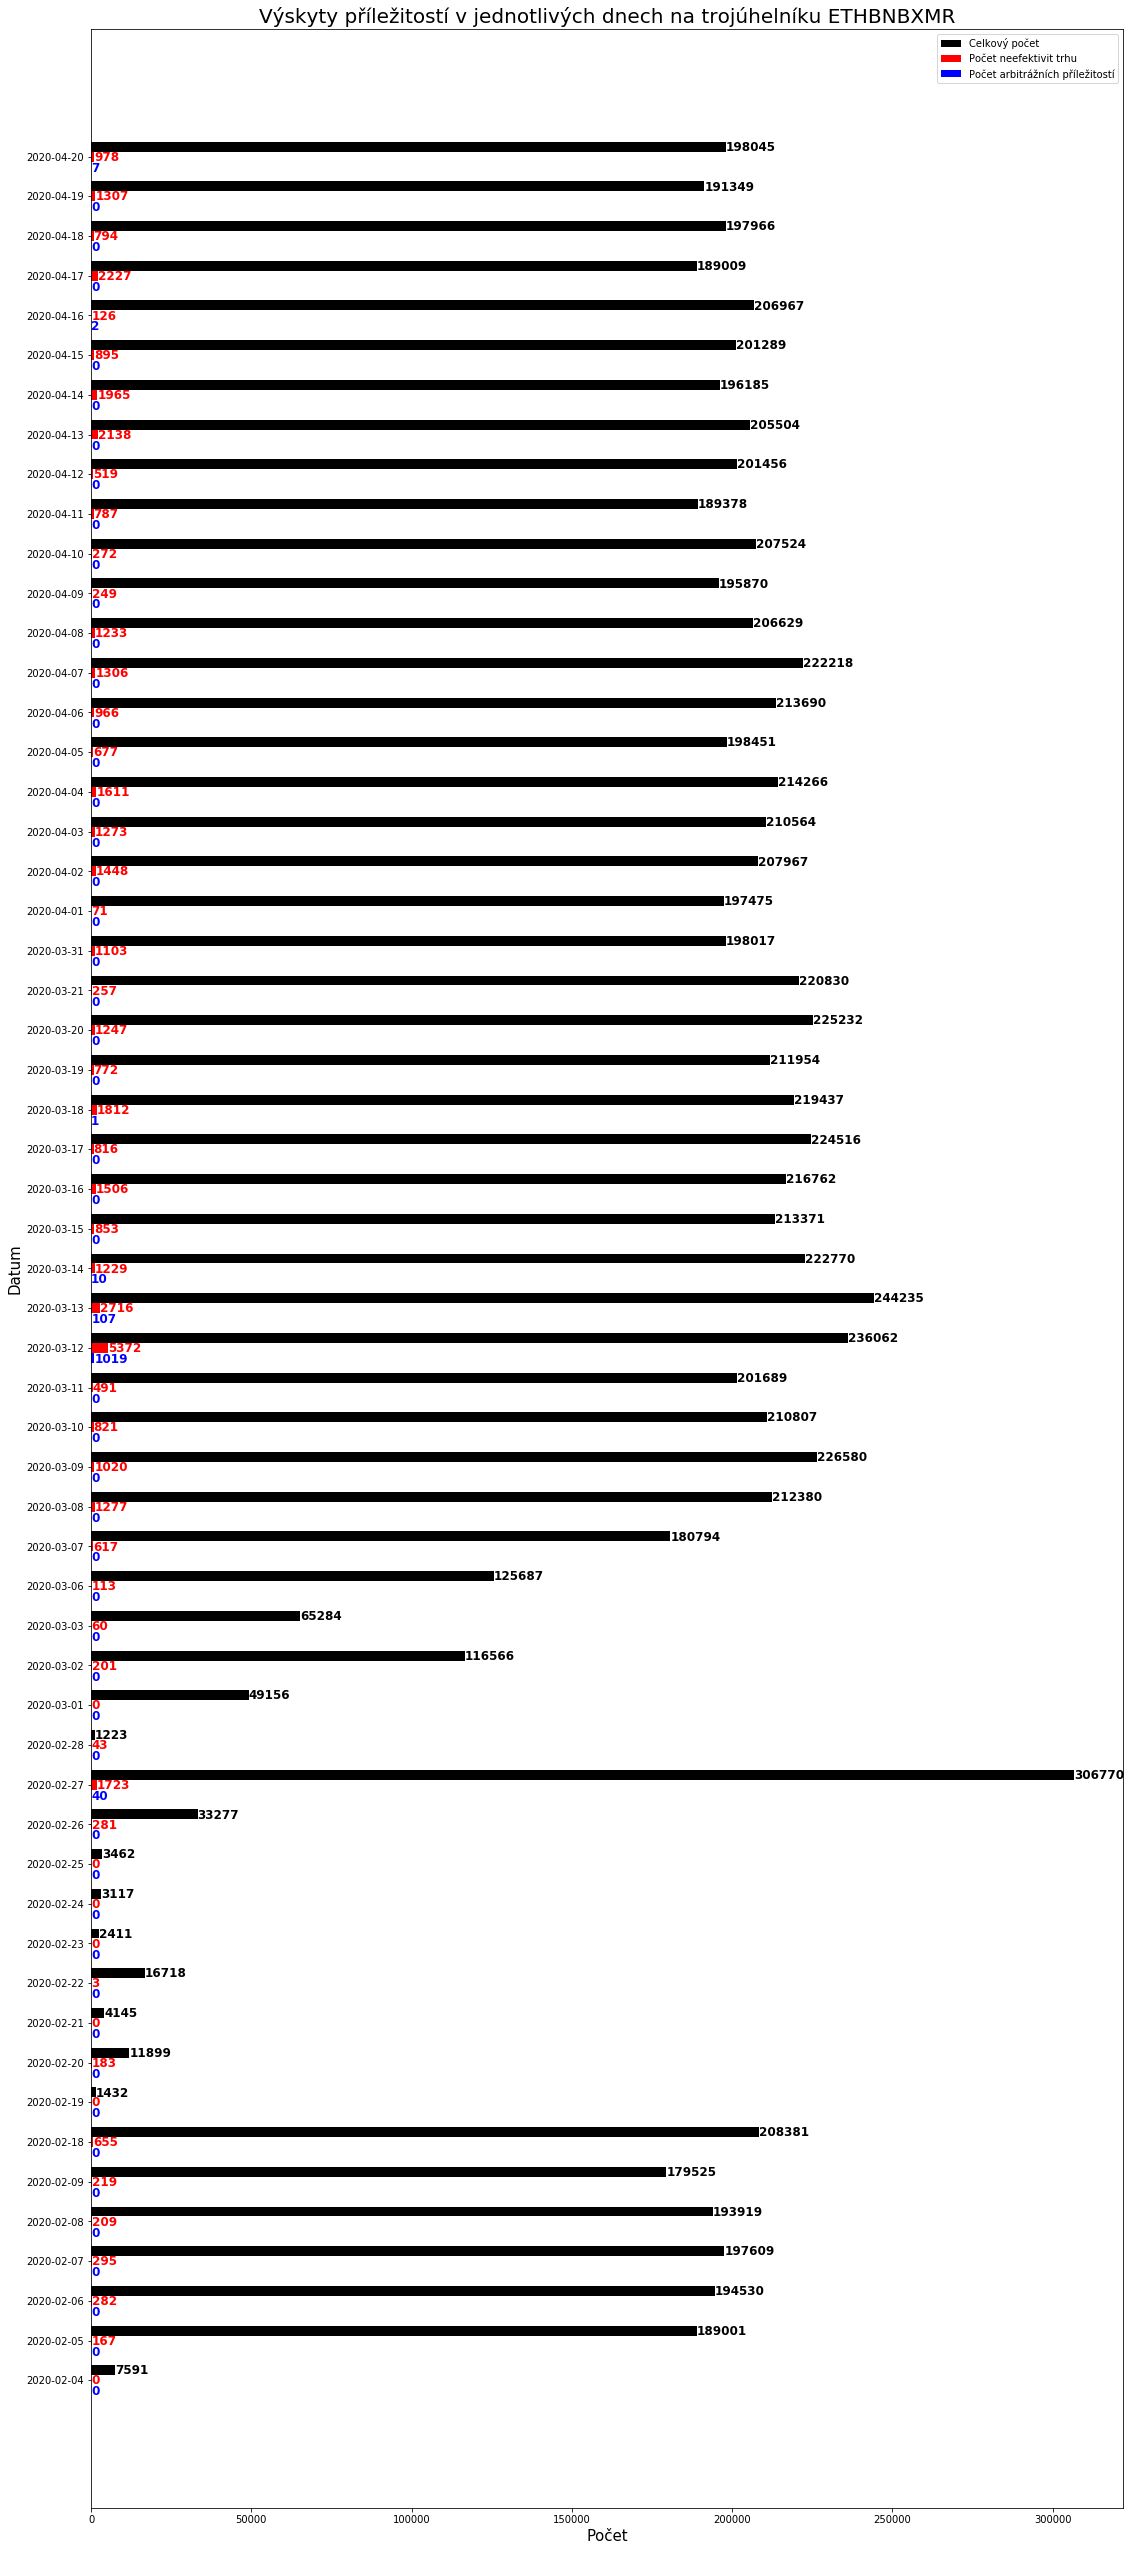

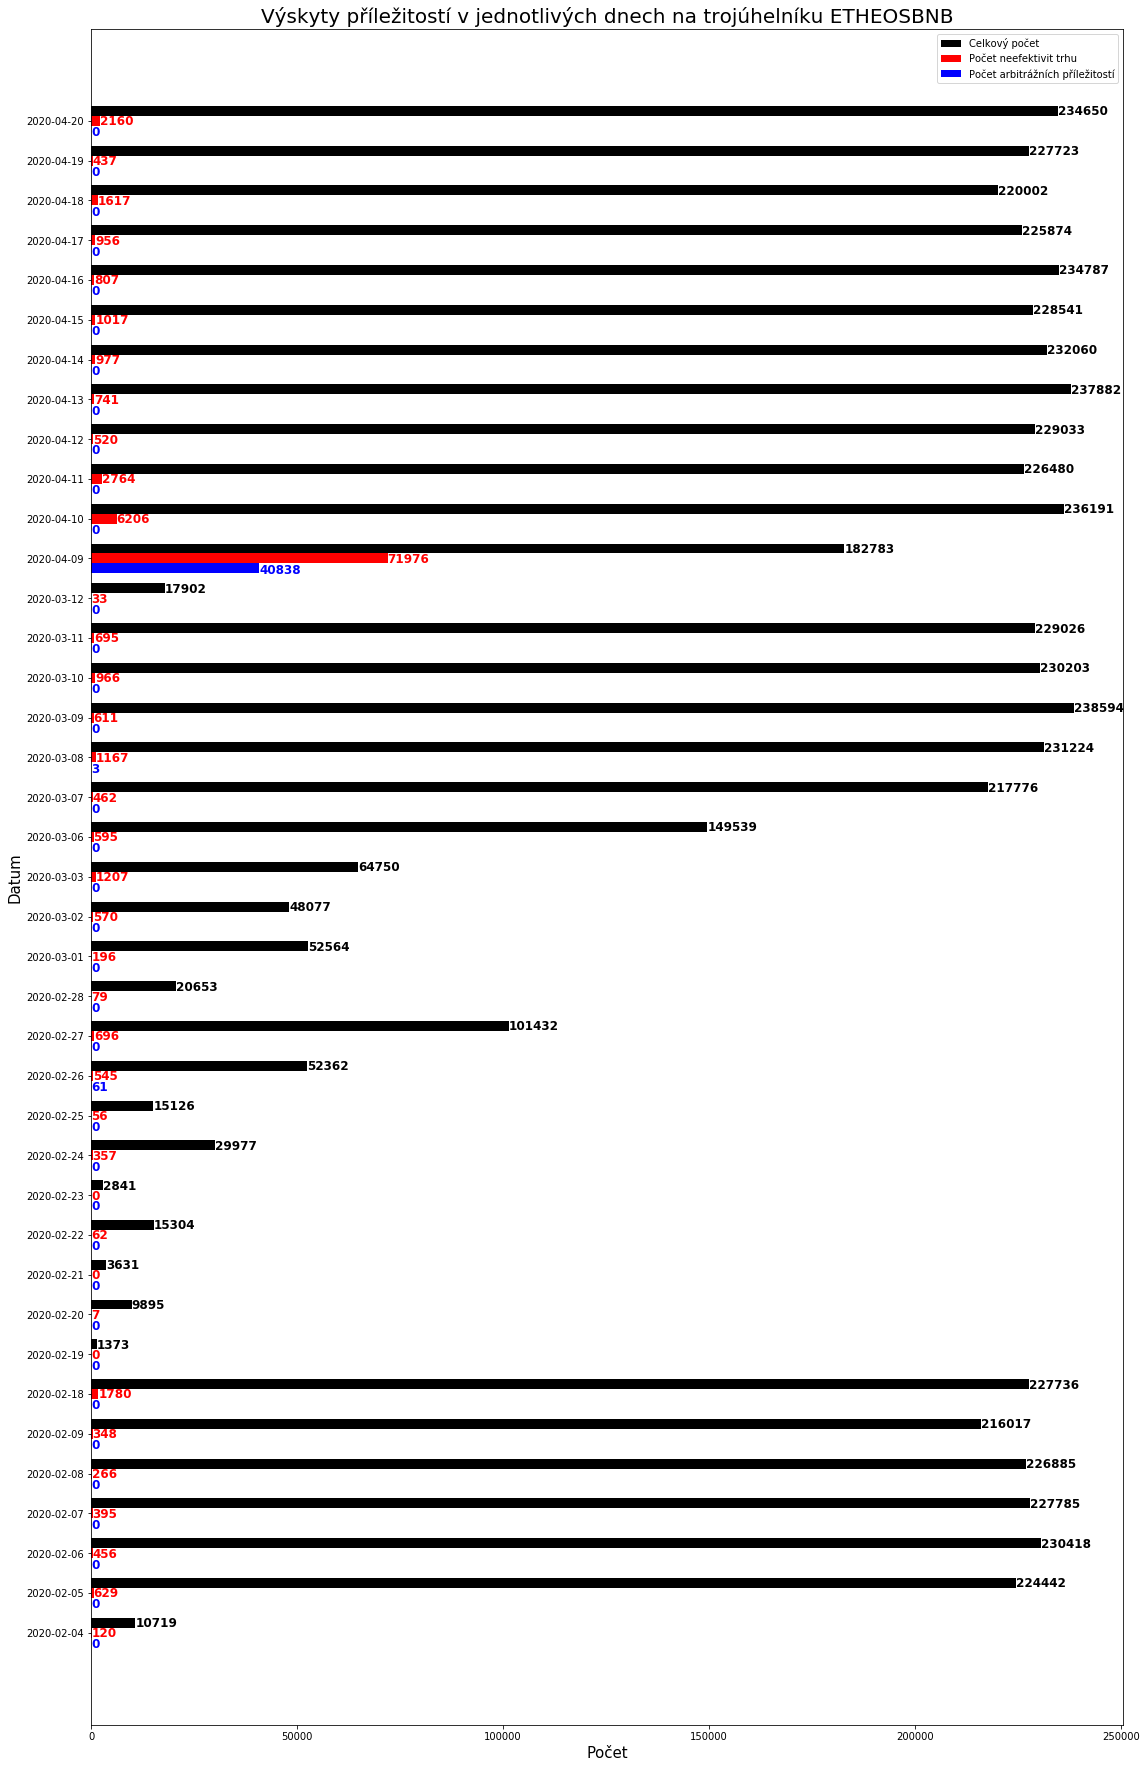

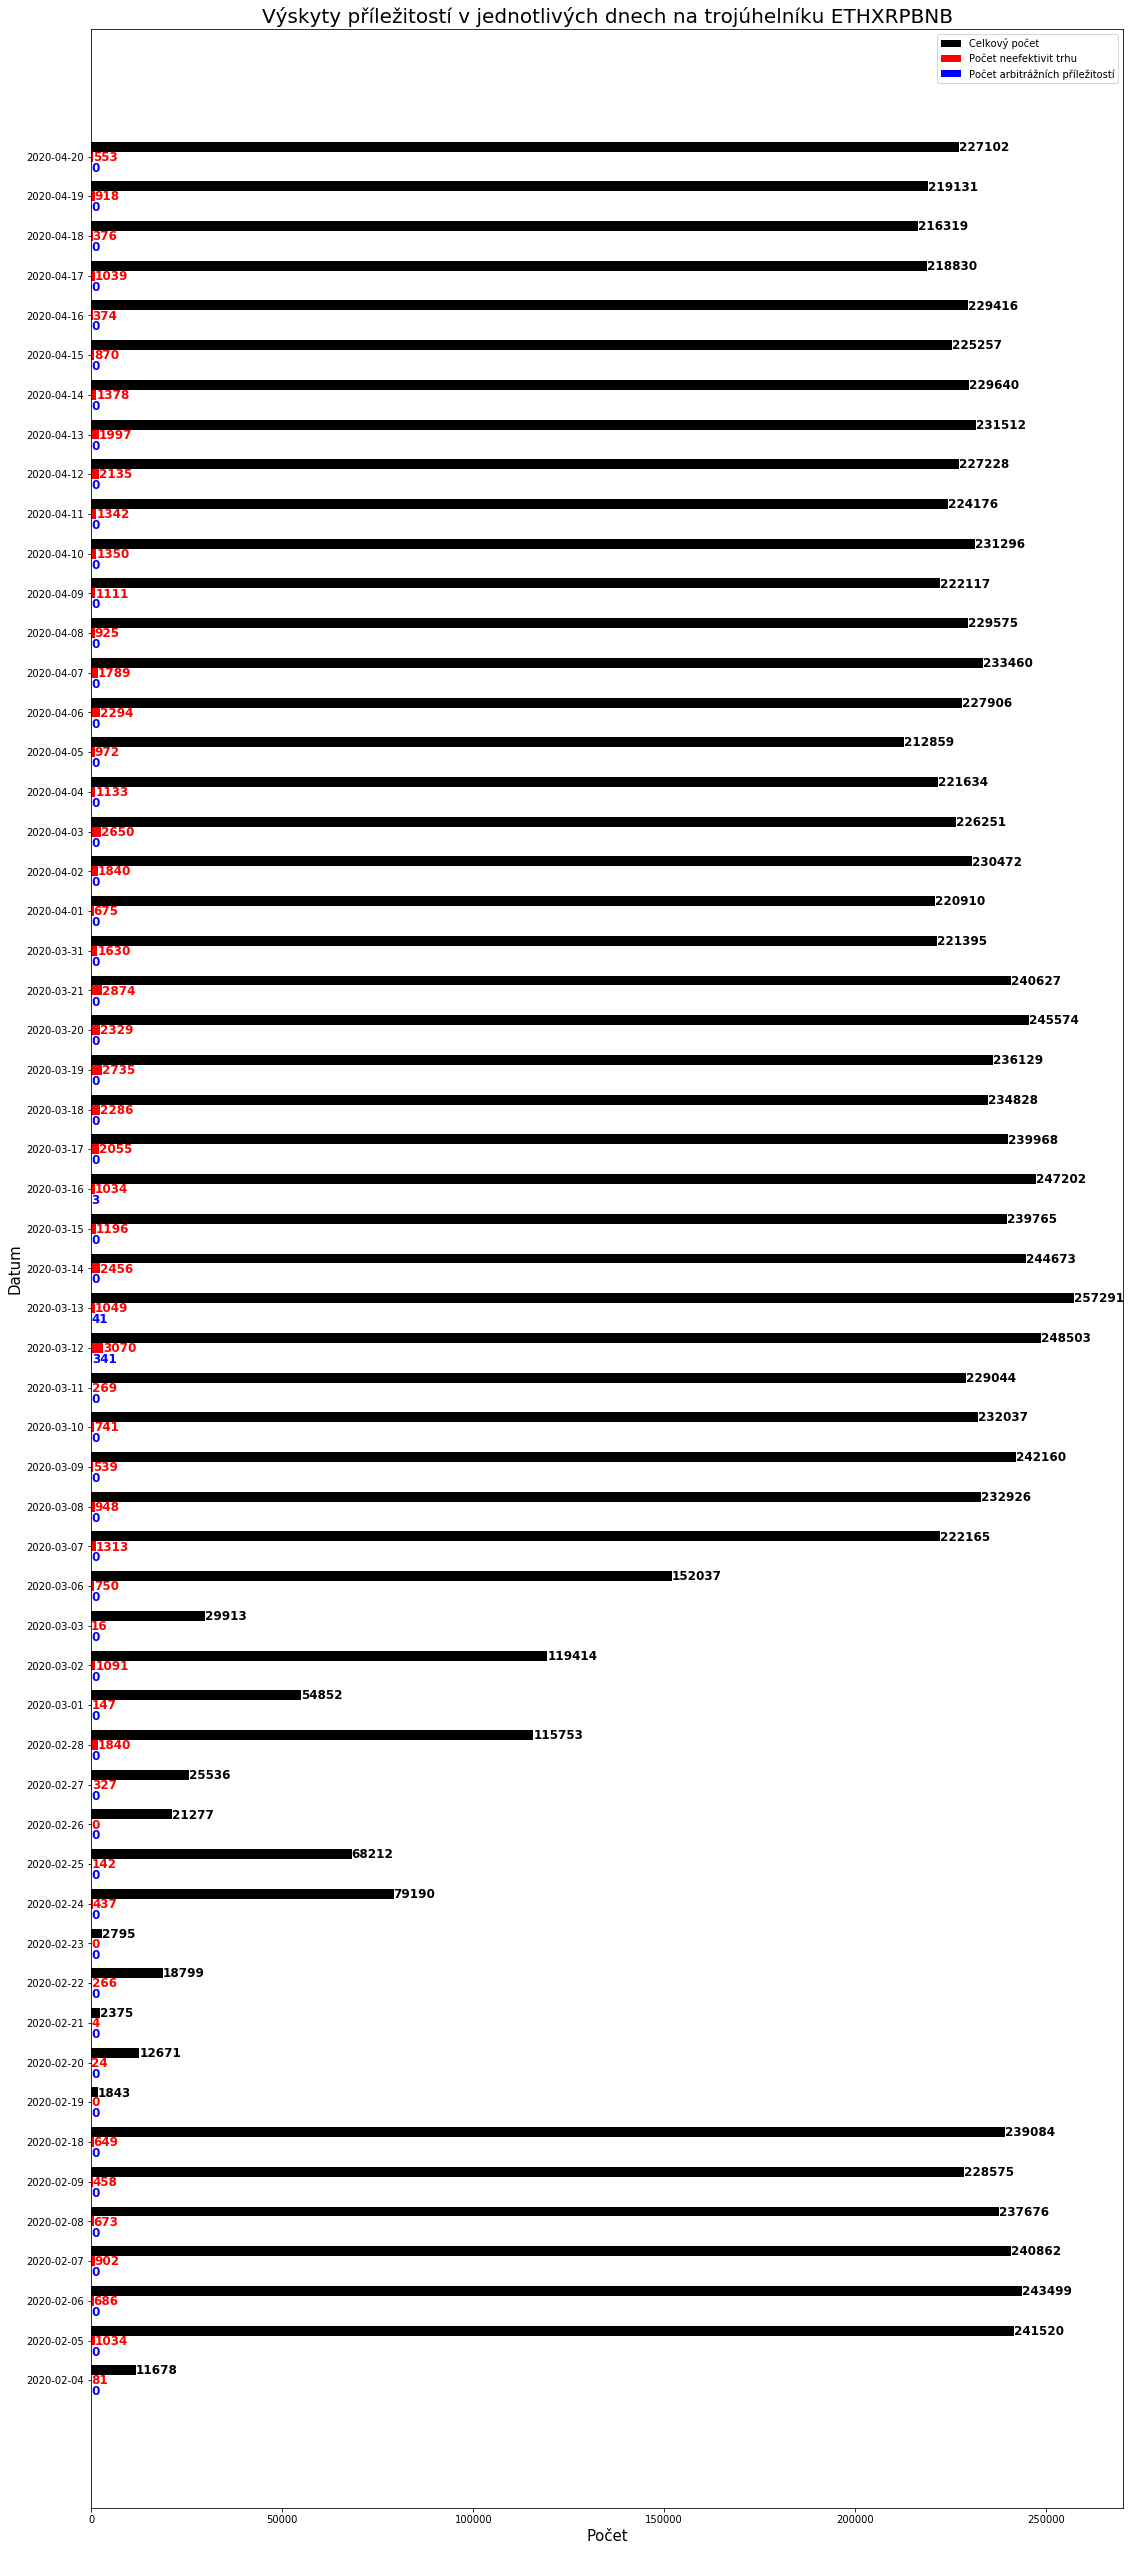

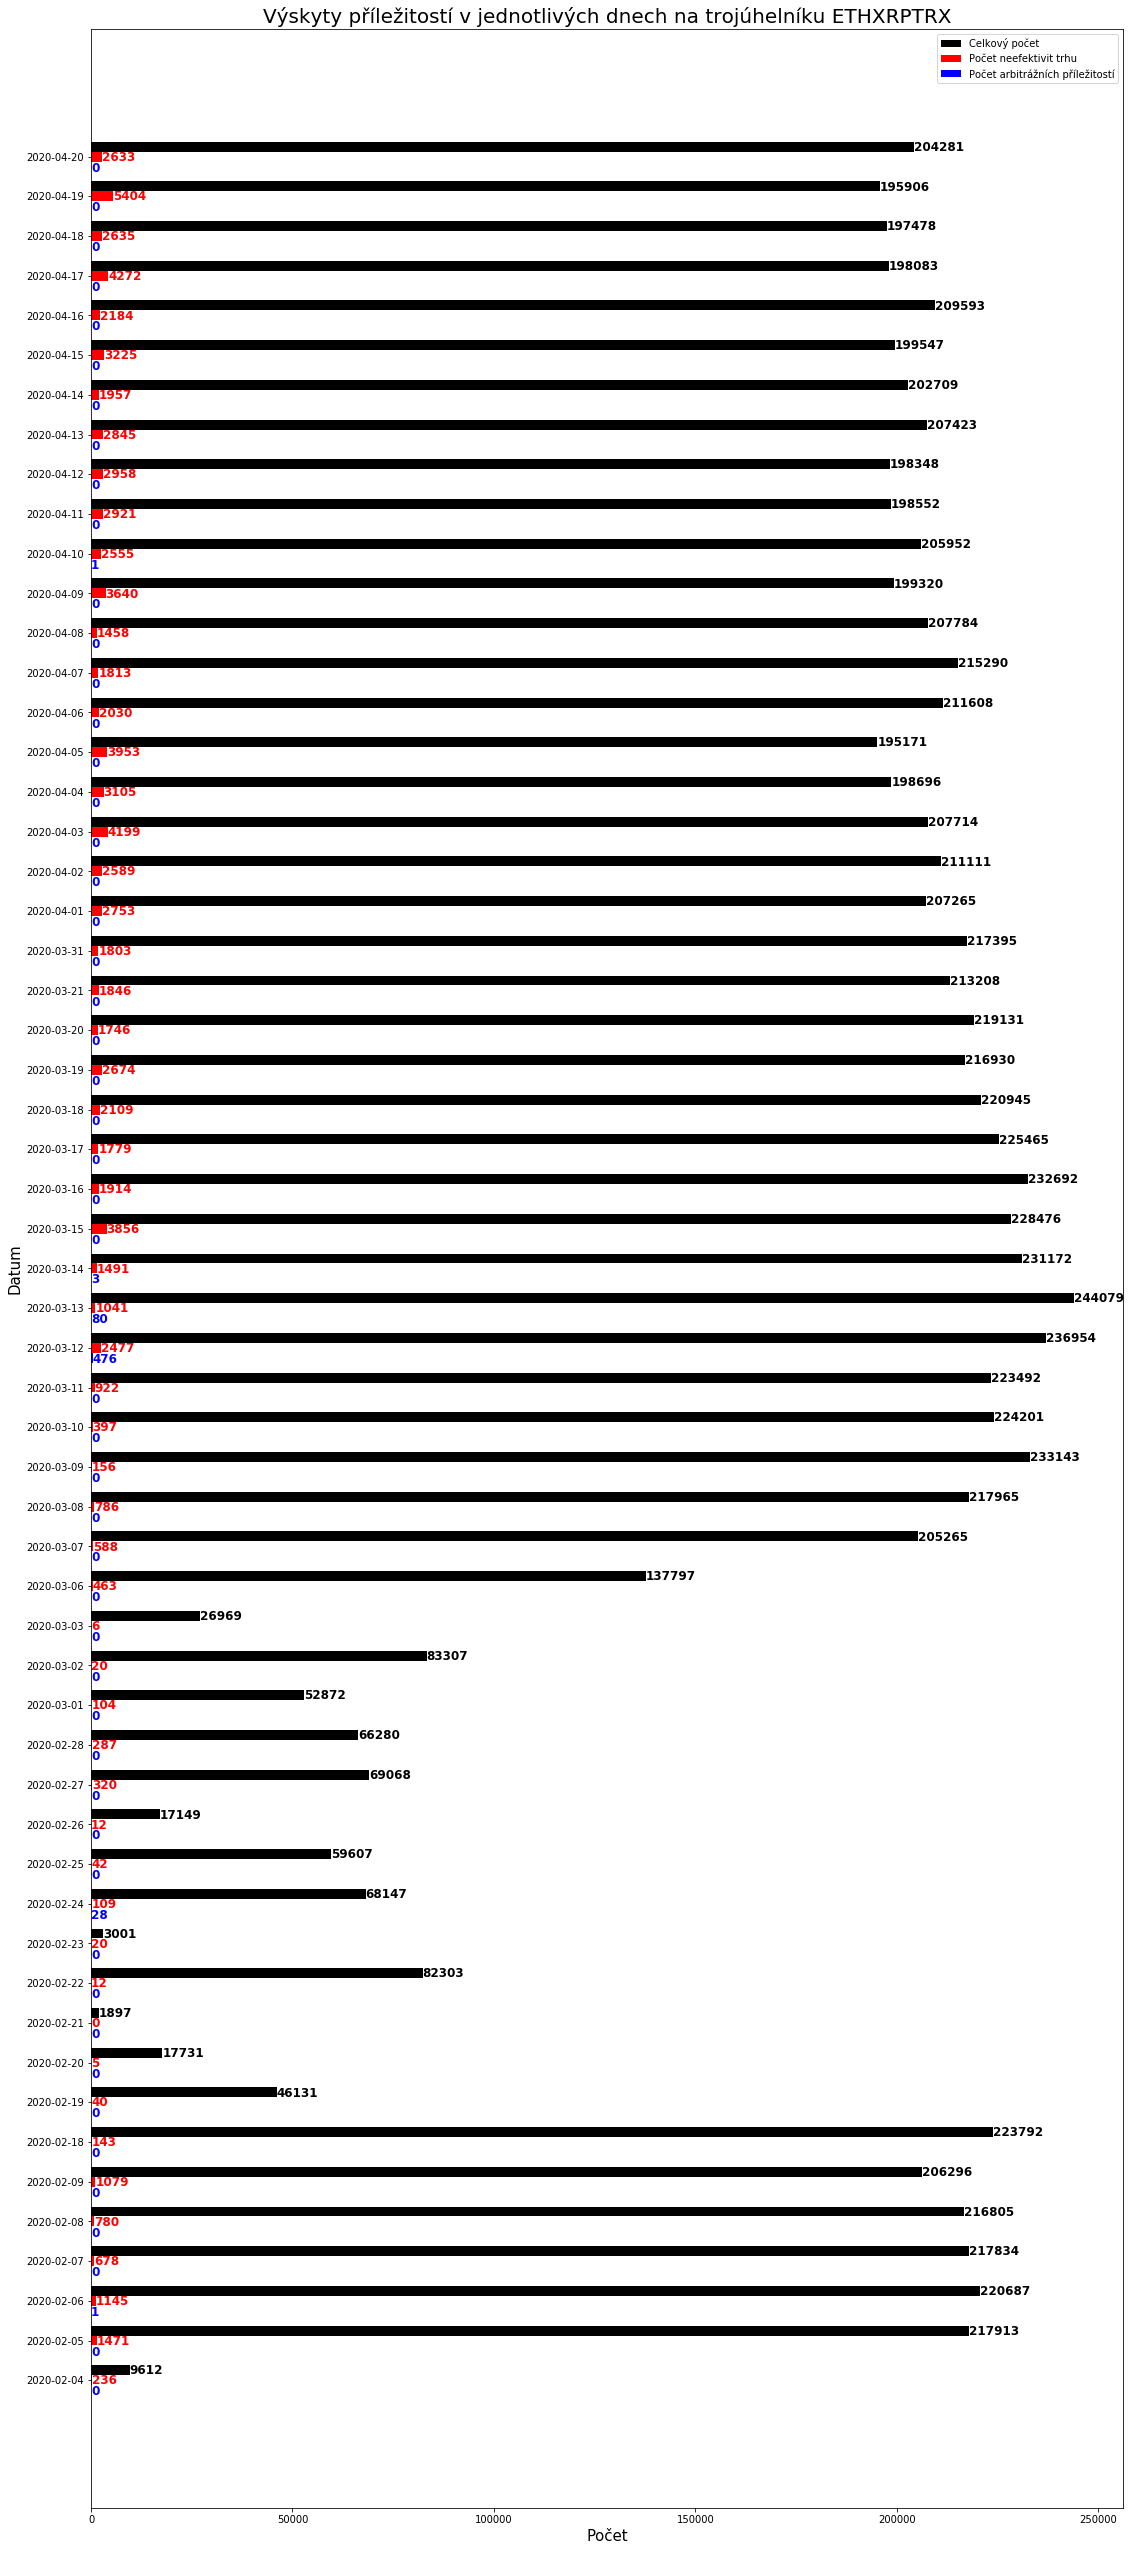

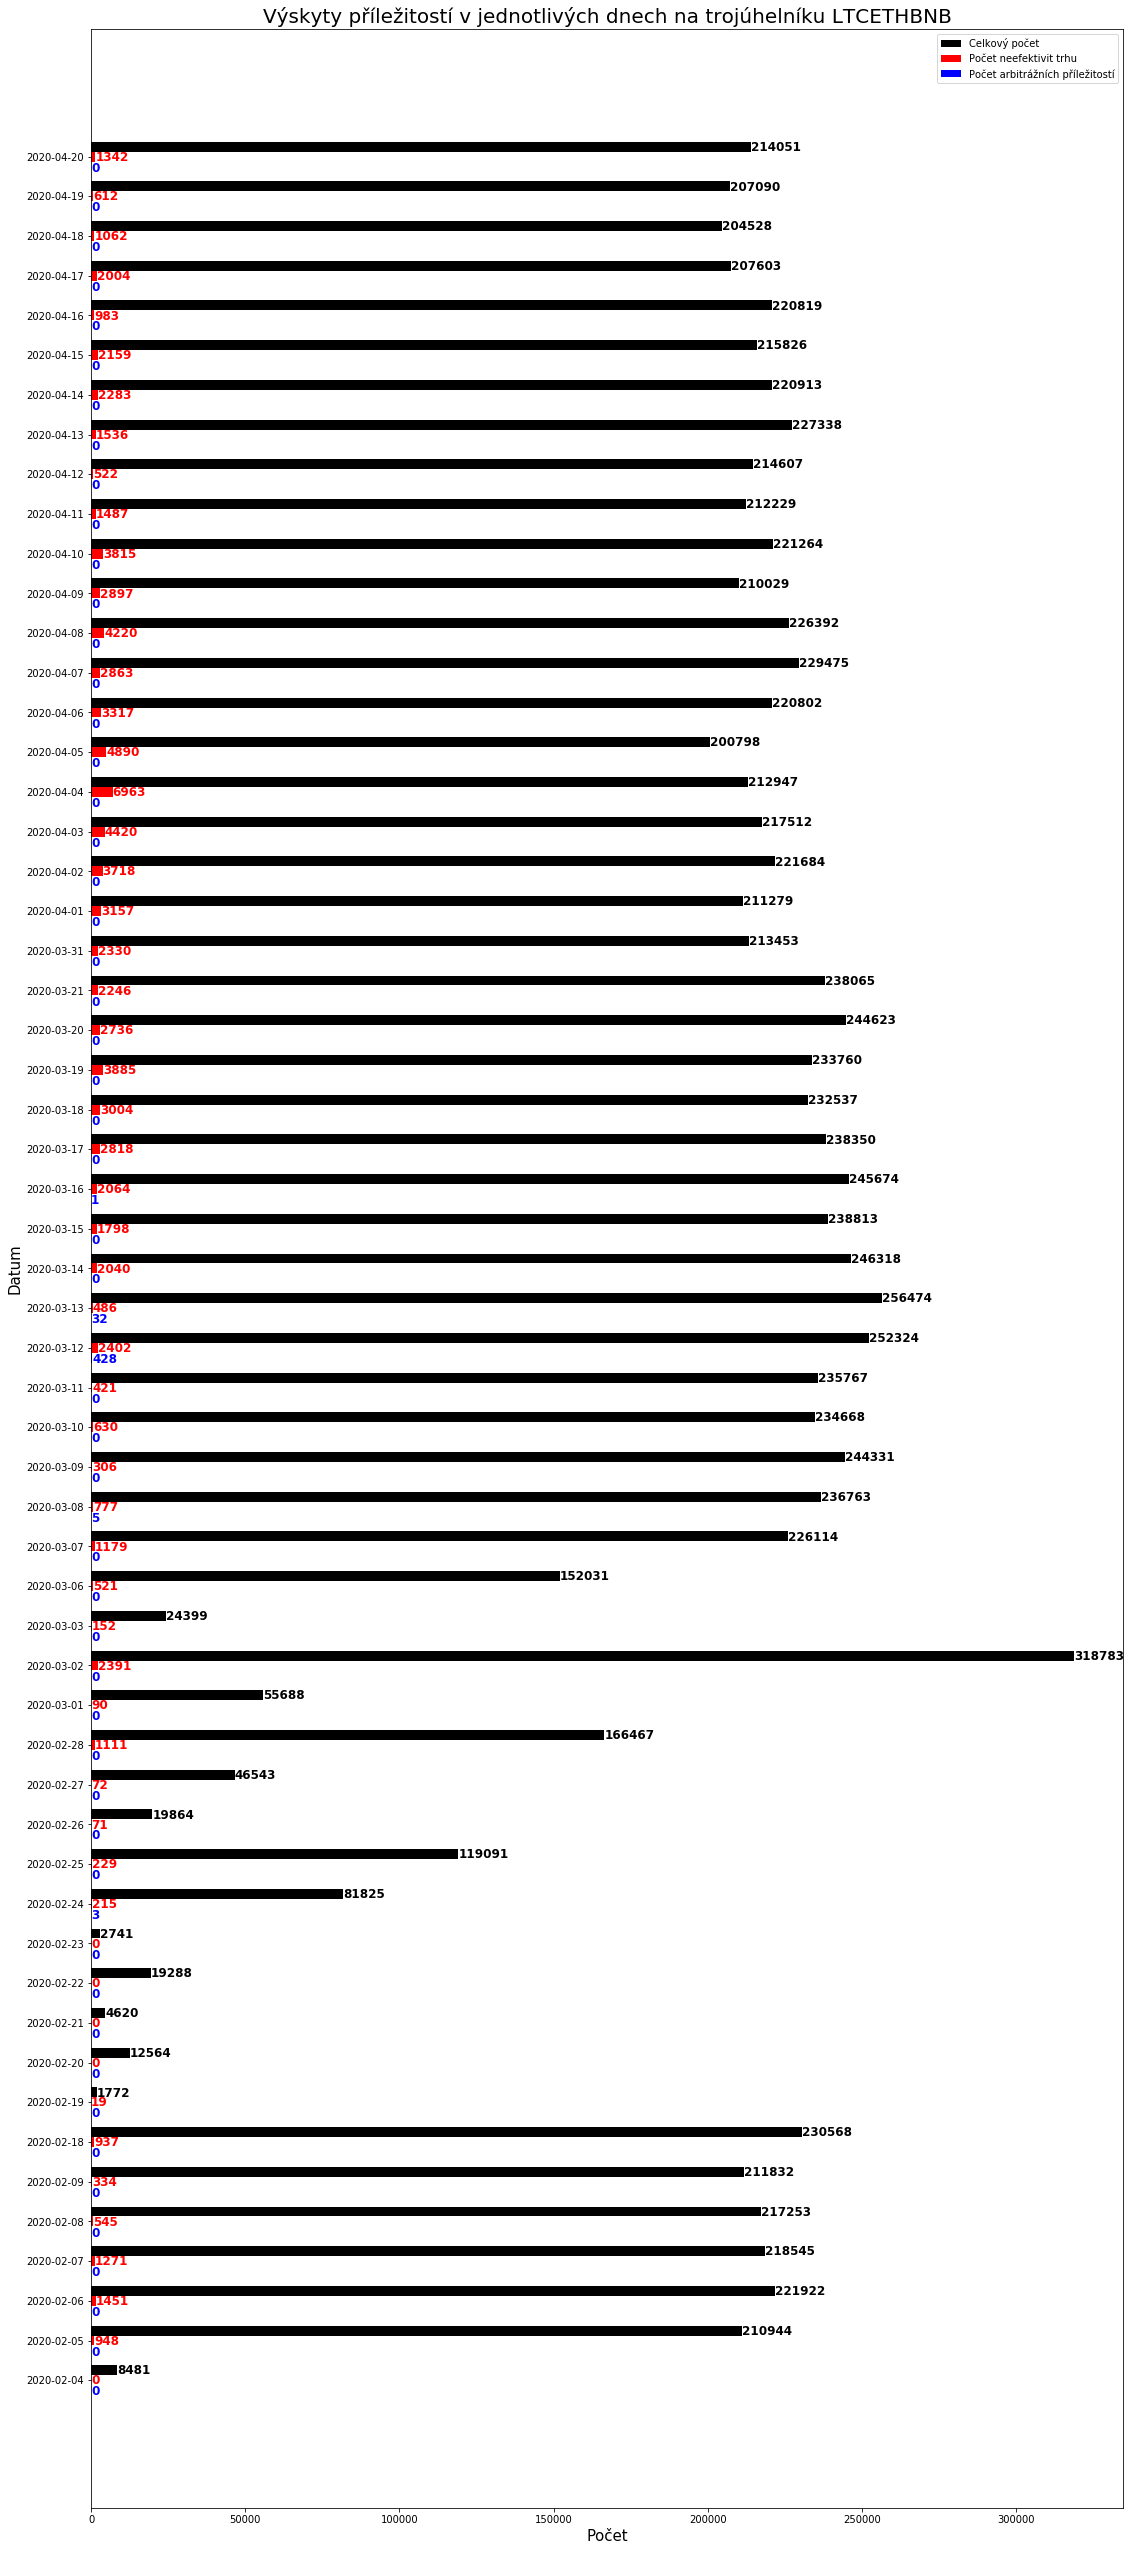

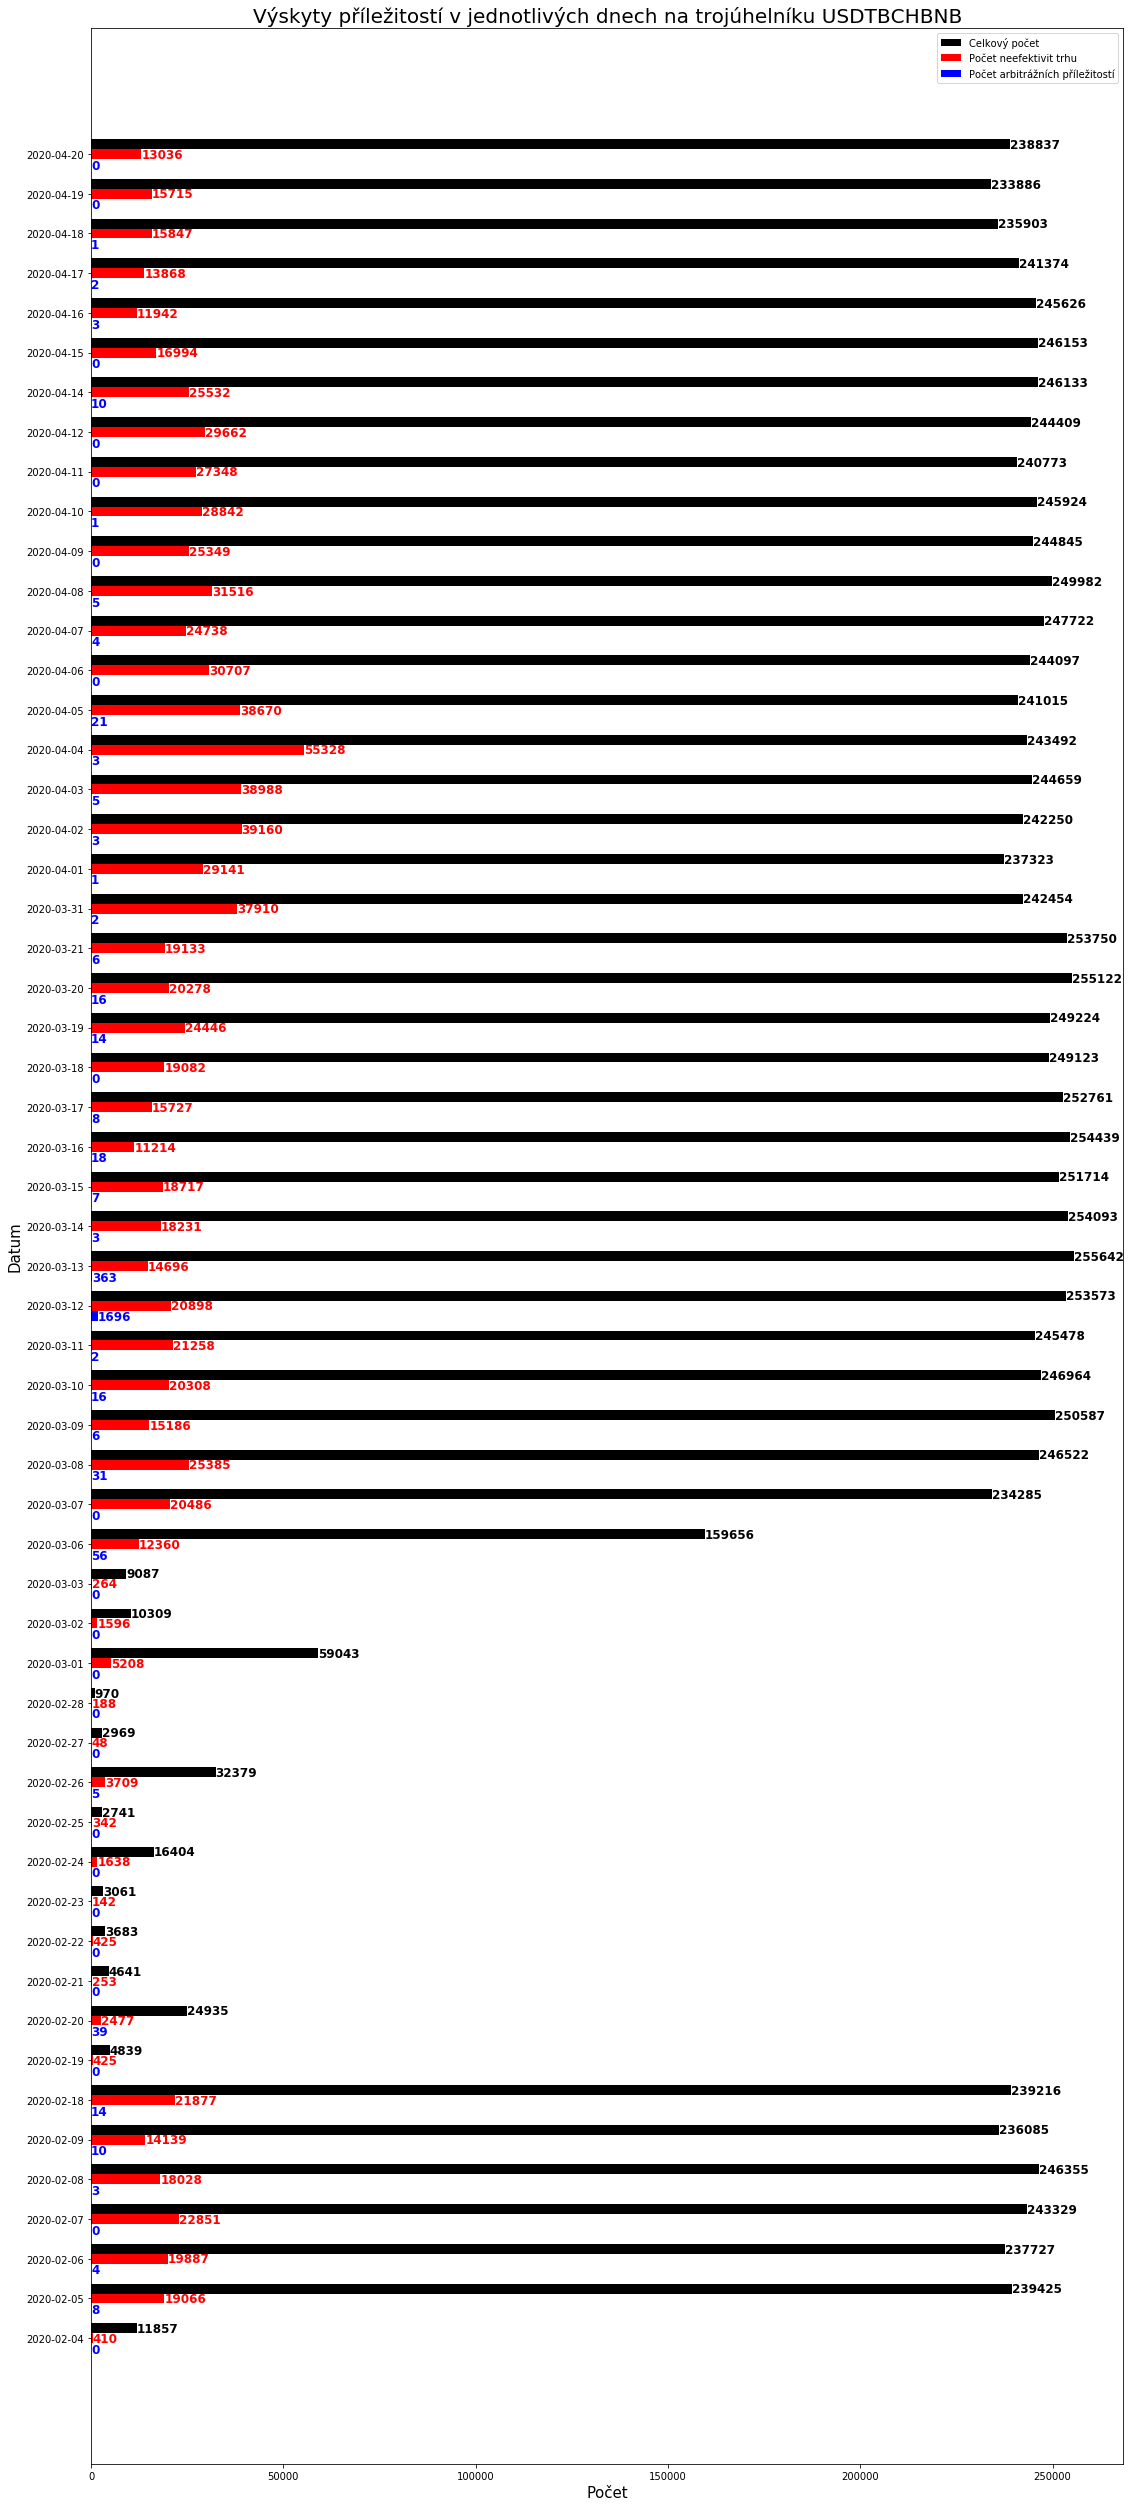

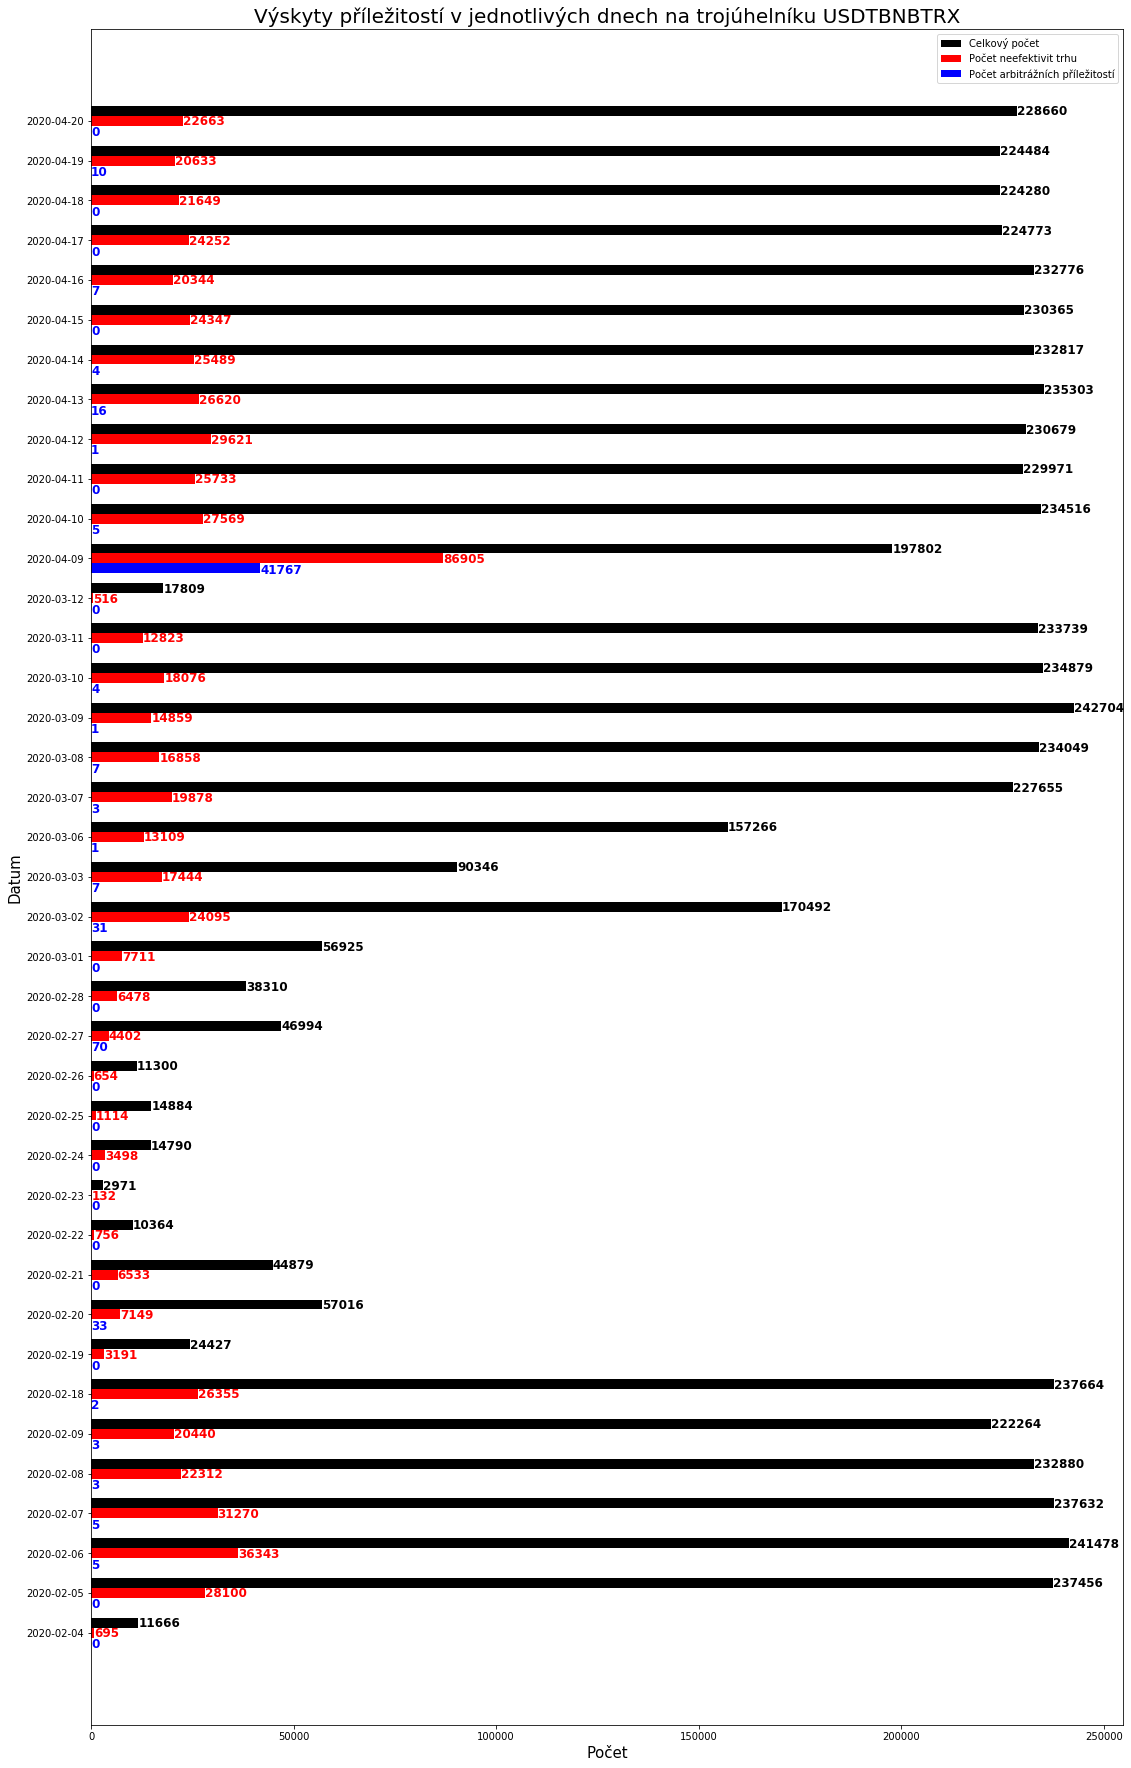

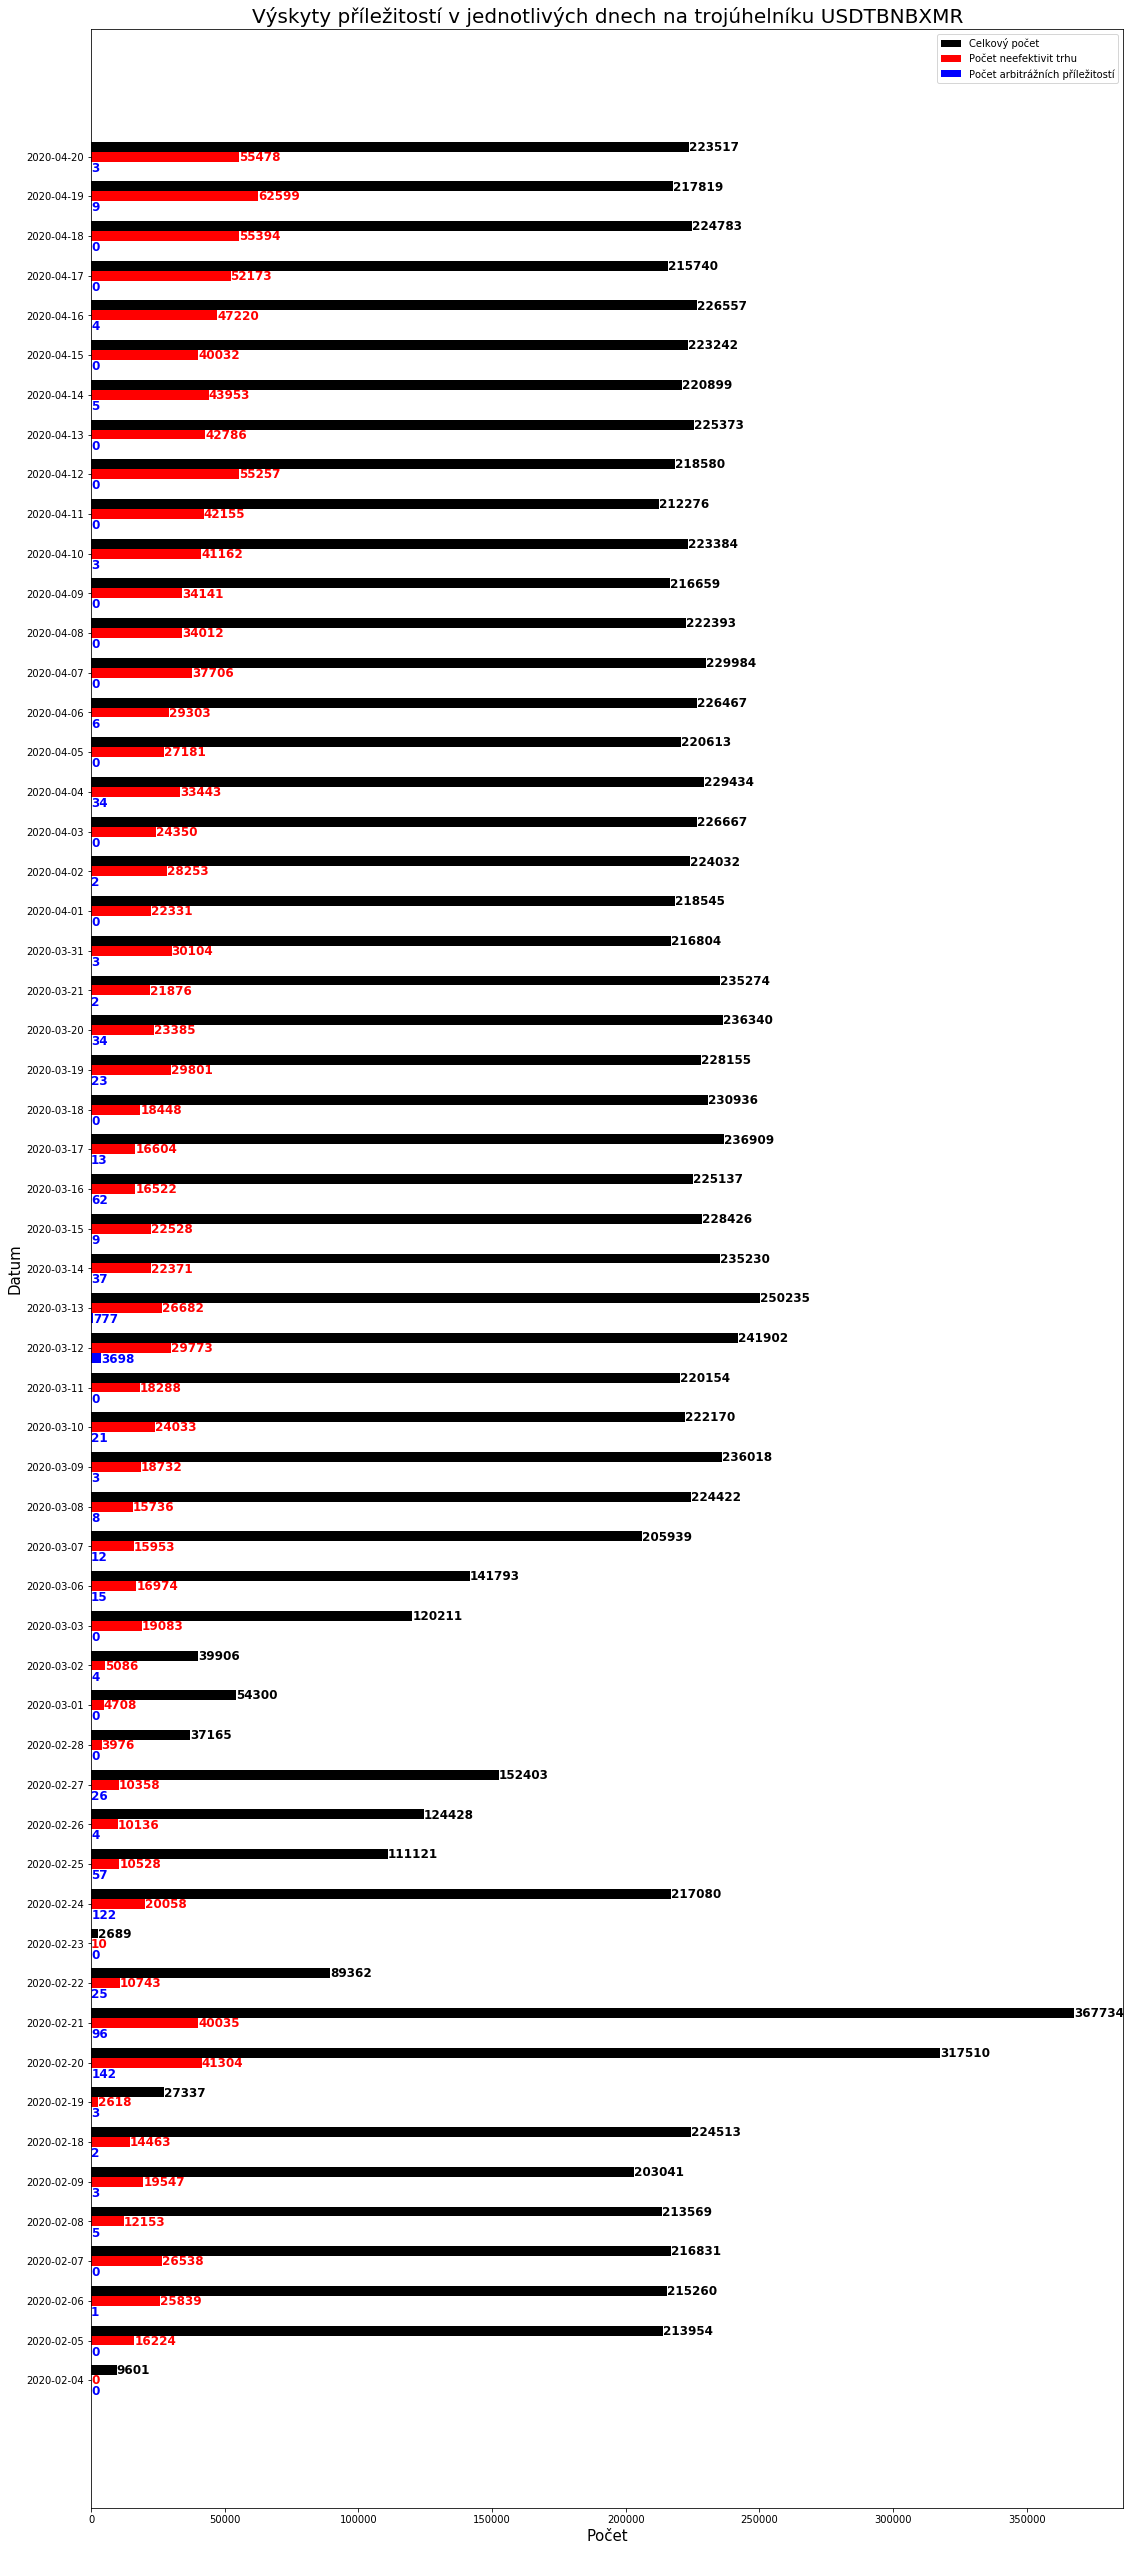

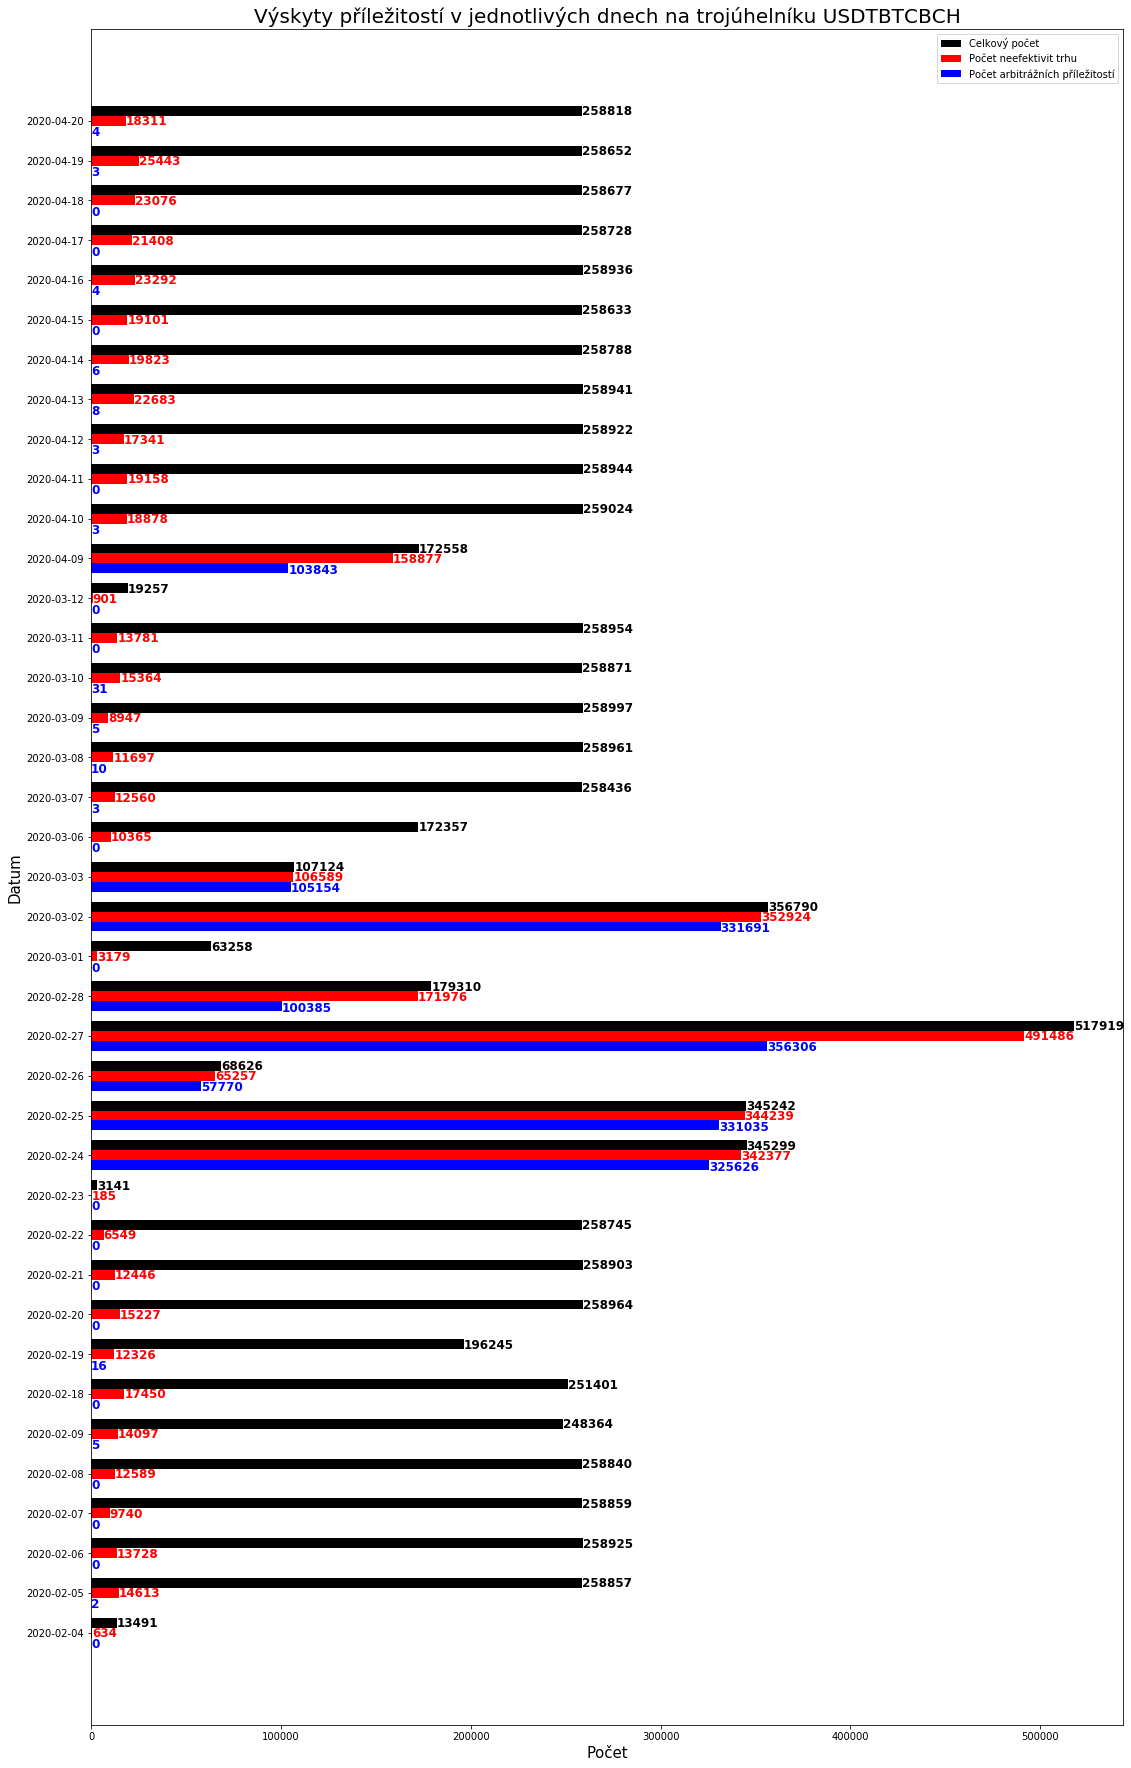

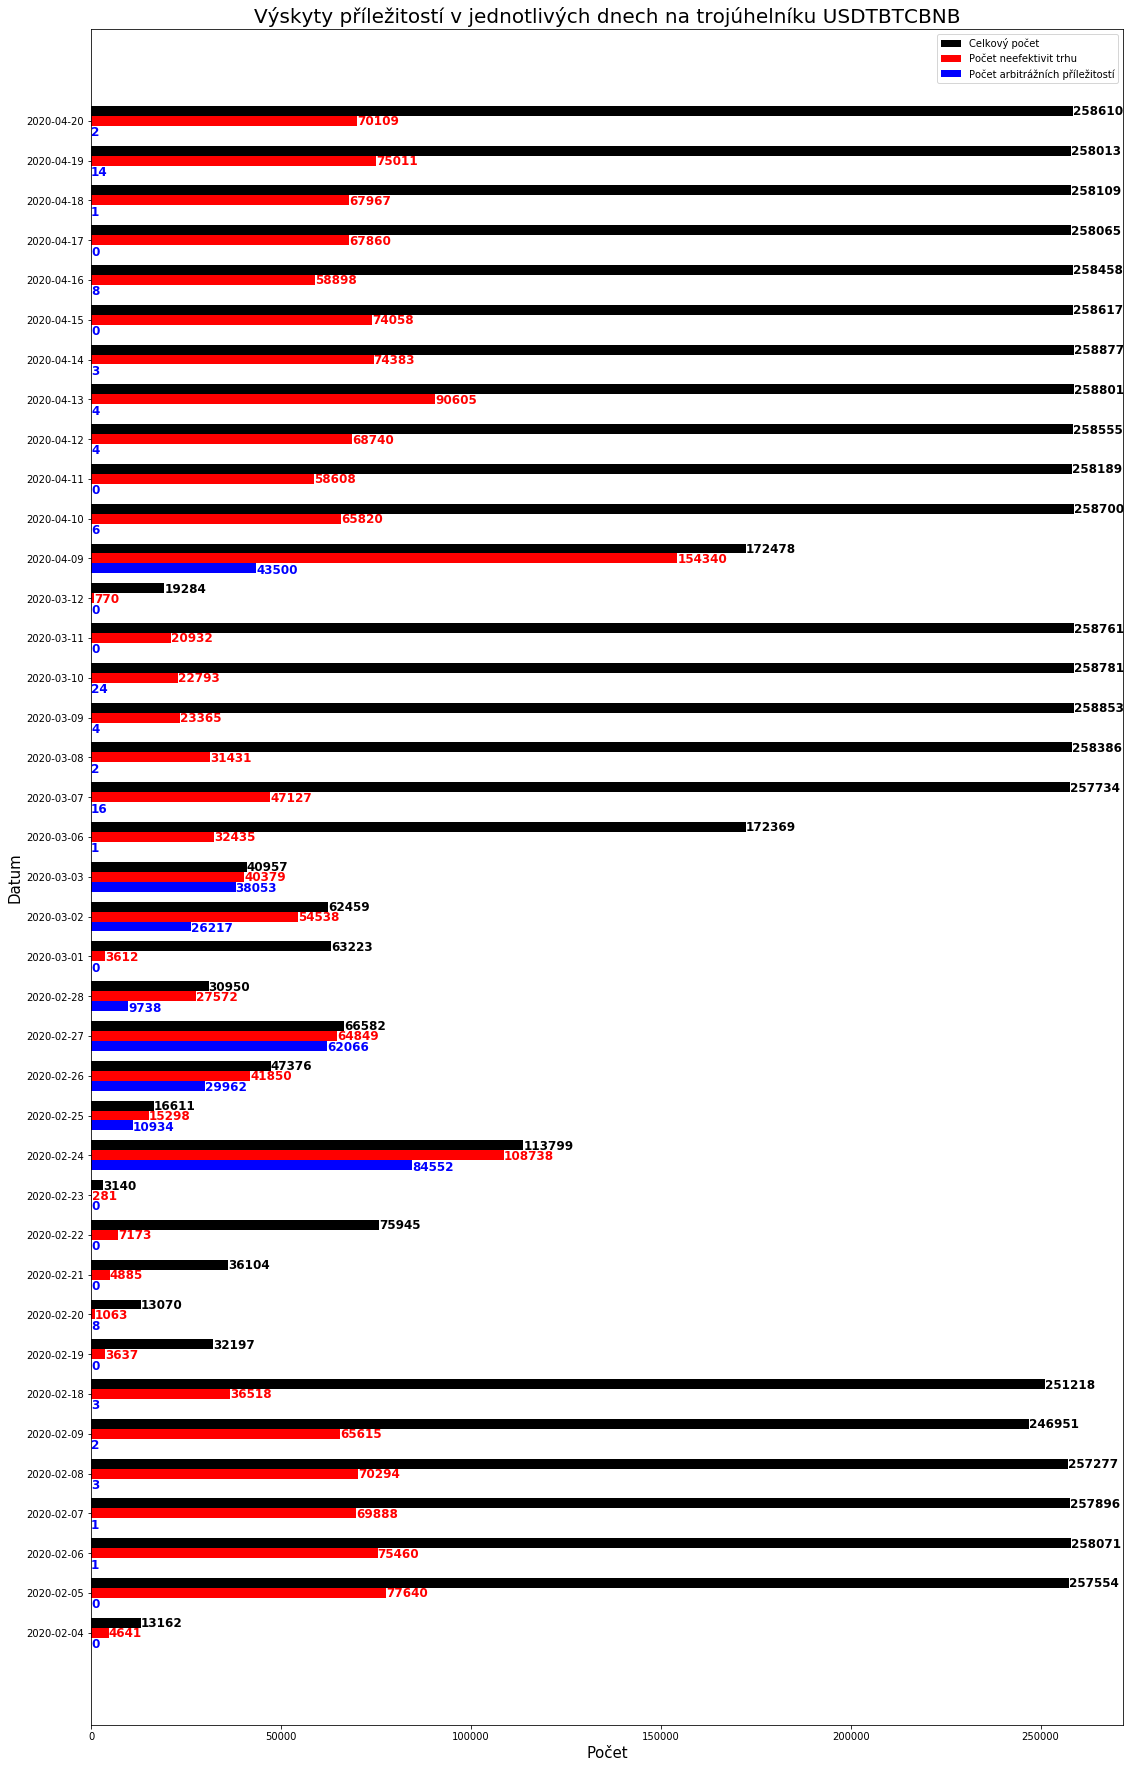

KeyboardInterrupt: 

In [18]:
path = "./output_data/"    

count = 0
stop = 99
tr = None
for directory in fetch_directories(path):
    count += 1
    triangle = Triangle(fetch_files(directory), directory, directory[len(path):])
    arbitrages_counts, without_fees_count, all_count, dates = triangle.get_arbitrages_counts()
    
    # ---------------------------------------- plot
    fig, ax = plt.subplots()    
    width = 0.25  # the width of the bars 
    color = 'black'  # text color
    ind = np.arange(len(arbitrages_counts))  # the x locations for the groups
    ax.barh(np.arange(len(arbitrages_counts)) + width, all_count, height=width, align='center', color='black', label='Celkový počet')
    ax.barh(np.arange(len(arbitrages_counts)), without_fees_count, height=width, align='center', color='red', label='Počet neefektivit trhu')
    ax.barh(np.arange(len(arbitrages_counts)) - width, arbitrages_counts, height=width, align='center', color='blue', label='Počet arbitrážních příležitostí')
    ax.set_yticks(ind)
    ax.set_yticklabels(dates)
    plt.xlabel("Počet", fontsize=15)
    plt.ylabel("Datum", fontsize=15)
    plt.title("Výskyty příležitostí v jednotlivých dnech na trojúhelníku " + triangle.name, fontsize=title_font_size)
    ax.legend()
    fig.set_size_inches(18.5, width*3.2*len(dates))
    for i, v in enumerate(all_count):
        ax.text(v, i + width*0.6, str(v), color='black', fontweight='bold', fontsize=12)
    for i, v in enumerate(without_fees_count):
        ax.text(v, i - width*0.4, str(v), color='red', fontweight='bold', fontsize=12)
    for i, v in enumerate(arbitrages_counts):
        ax.text(v, i - width*1.5, str(v), color='blue', fontweight='bold', fontsize=12)
    plt.savefig(os.path.join('arbitrages_count/' + triangle.name + '.png'), dpi=300, format='png')
    plt.show()
    # !---------------------------------------- plot
    
    if count == stop:
        break

In [19]:
def bar_plot_from_pandas_dataframe(df, x, y, title='Nadpis', color='C0', save=False, output_name='chart', output_directory='./'):
    fig, ax = plt.subplots()
    df.plot(kind='bar', x=x, y=y, ax=ax, color=color)
    width = 0.4
    plt.title(title, fontsize=title_font_size)
    fig.set_size_inches(width * len(df['Average count']), 12)
    if save:
        plt.savefig(os.path.join(output_directory + output_name + '.png'), dpi=300, format='png')
    plt.show()

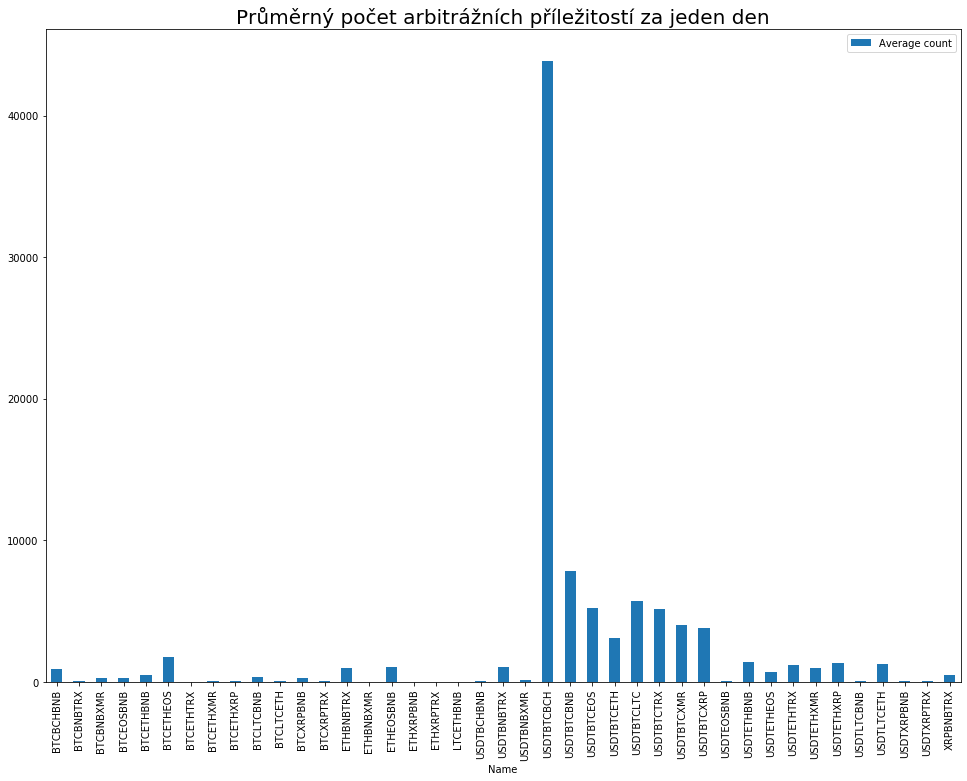

In [20]:
bar_plot_from_pandas_dataframe(stats_table, 'Name', 'Average count', "Průměrný počet arbitrážních příležitostí za jeden den", 
                               save=True, output_name='average_count', output_directory='./images/')

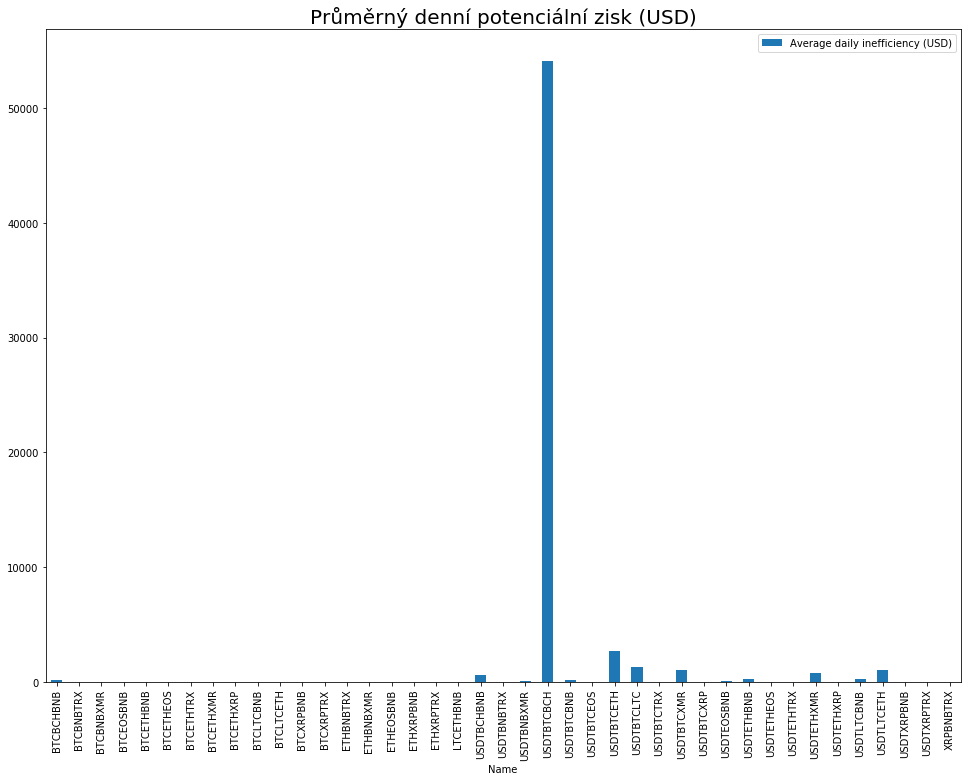

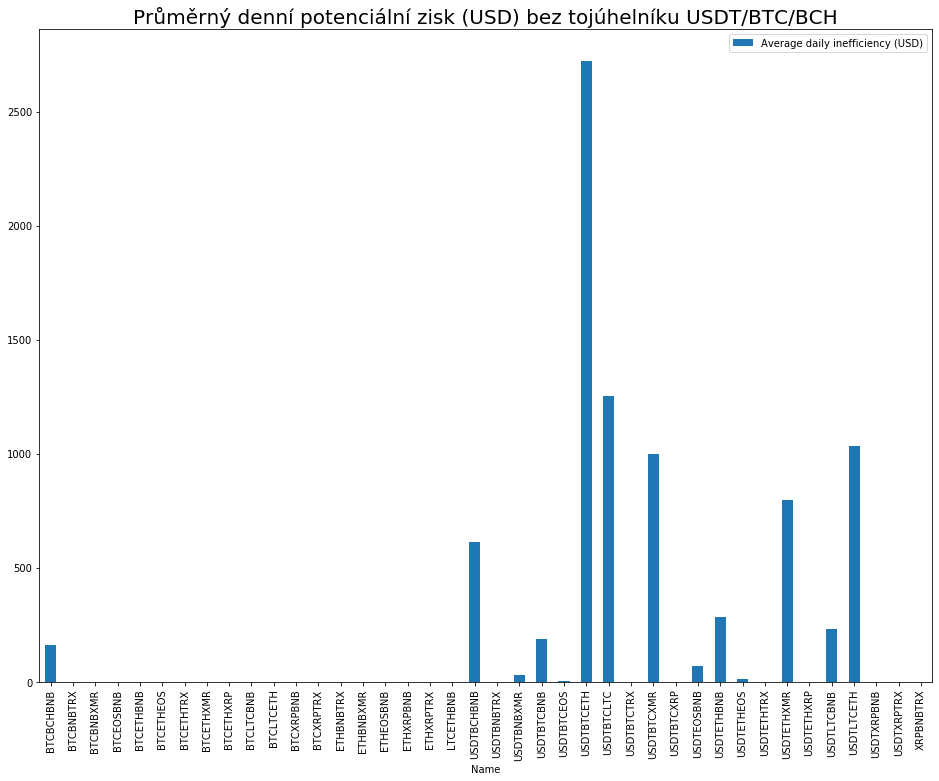

In [21]:
bar_plot_from_pandas_dataframe(stats_table, 'Name', 'Average daily inefficiency (USD)', "Průměrný denní potenciální zisk (USD)",
                              save=True, output_name='average_daily_inefficiency', output_directory='./images')
bar_plot_from_pandas_dataframe(stats_table.drop(22), 'Name', 'Average daily inefficiency (USD)', "Průměrný denní potenciální zisk (USD) bez tojúhelníku USDT/BTC/BCH",
                              save=True, output_name='average_daily_inefficiency_without_USDTBTCBCH', output_directory='./images')

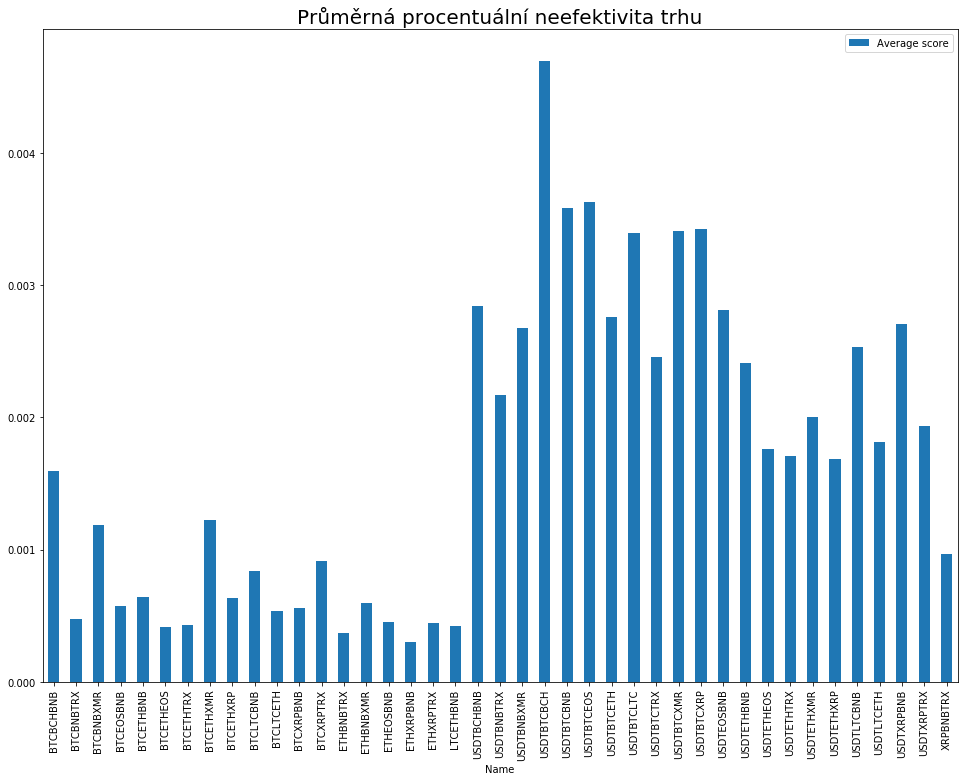

In [22]:
# bar_plot_from_pandas_dataframe(stats_table, 'Name', 'Average score', "Průměrný denní procentuální potenciální zisk")
df = deepcopy(stats_table)
df['Average score'] = df['Average score'].apply(lambda x: x - 1)
bar_plot_from_pandas_dataframe(df, 'Name', 'Average score', "Průměrná procentuální neefektivita trhu",
                              save=True, output_name='average_percentage_indefficiency', output_directory='./images')
df = None

# Porovnání grafu trojúhelníku a vývoje jednotlivých dvojic
#### BCHBTC
![](images/BCHBTC.png)
#### USDTBTC
![](images/USDTBTC.png)
#### USDTBCH
![](images/USDTBCH.png)
#### Trojúhelník USDTBTCBCH
![](images/USDTBTCBCH.png)


In [ ]:
df = None
df = pd.read_json("./output_data/USDTBTCBCH/USDTBTCBCH-2020-02-26.json")
df

In [ ]:
df = {}
with open("./output_data/USDTBTCBCH/USDTBTCBCH-2020-02-26.json") as f:
    df = json.loads(f.read())
df

In [ ]:
from statistics import median
median([x['demand_gain'] for x in df['arbitrage_stats'] if x['demand_gain'] > 0]) * rate['BCH']

In [ ]:
median([x['demand_gain'] for x in df['arbitrage_stats'] if x['demand_gain'] > 0]) * df['arbitrages_count'] * rate['BCH']

In [ ]:
sum([x['demand_gain'] for x in df['arbitrage_stats'] if x['demand_gain'] > 0]) * rate['BCH']

In [ ]:
# ts = []
# print("initializing")

# for i in range(stop):
#     ts.append(threading.Thread(target=basic_stats, args=(triangles[i], str(i),)))
# print("starting")
# for t in ts:
#     t.start()
# for t in ts:
#     t.join()
# print("done")